In [1]:
import scanpy as sc
#import gseapy as gs
import numpy as np
import scipy as sp
from scipy.stats import spearmanr, pearsonr

import pandas as pd

In [2]:
# Importing plotting
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import DivergingNorm
from matplotlib import cm

In [3]:
# Scanpy settings
sc.settings.verbosity = 3             # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_header()
sc.settings.set_figure_params(dpi=80, facecolor='white')

celltype = 'Monocyte'
master_dir = '../'

scanpy==1.6.0 anndata==0.7.5 umap==0.4.6 numpy==1.19.4 scipy==1.5.4 pandas==1.1.4 scikit-learn==0.23.2 statsmodels==0.12.1 python-igraph==0.8.3 louvain==0.7.0 leidenalg==0.8.3


In [4]:
# Get the dictionary associating pathway names with metabolic classifications
classifications = pd.read_csv(master_dir + 'data/KEGG_genesets/hsa00001.metab.keg-KEGGclassified.gmt', 
                              header=None, sep='\t')
classifications.index = classifications[0]
classifications = classifications.drop(columns=[0])
classifications.columns = ['classification']
classifications = classifications.to_dict()['classification']

In [5]:
adata_metab = sc.read_h5ad(master_dir + 'output/' + celltype + '-processed-analyzed-metab.h5ad')
adata = sc.read_h5ad(master_dir + 'output/' + celltype + '-processed-analyzed.h5ad')
adata_metab

AnnData object with n_obs × n_vars = 95361 × 1387
    obs: 'patient', 'ICU_status', 'IL6i_between_draws', 'no_IL6i', 'WHO_scale', 'Blood_draw_time', 'Sex', 'Age_at_baseline', 'Days_since_onset_of_symptoms', 'leiden', 'leiden_all', 'louvain', 'Days_since_onset_float', 'umap_density_ICU_status'
    uns: 'ICU_status_colors', 'leiden_all_colors', 'leiden_colors', 'louvain', 'louvain_colors', 'neighbors', 'patient_colors', 'pca', 'rank_genes_groups', 'umap', 'umap_density_ICU_status_params'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

In [6]:
# Loading in metabolics-relevant pathways from KEGG (based on Xiao et al. Nat Commun 2019)
#metab_pathway_list = pd.read_csv(master_dir + 'data/MSigDB/KEGG_metab_pathway_list_Xiao2019-JLmod200620.txt', 
#                                 sep='\t', header=None)
#metab_pathway_list = np.array(metab_pathway_list.iloc[:, 0])

# Genes in each KEGG pathway
metab_genes = pd.read_csv(master_dir + 'data/KEGG_genesets/hsa00001.metab.keg.gmt', 
                          sep='\t', header=None)
metab_genes.index = metab_genes.iloc[:, 0]
metab_genes = metab_genes.drop([0], axis=1)
# Drop the following pathways because none of the genes are found in the preprocessed adata
metab_genes = metab_genes.drop(index=['C5-Branched dibasic acid metabolism',
                                     'Lysine biosynthesis', 
                                     'D-Arginine and D-ornithine metabolism',
                                     'Polyketide sugar unit biosynthesis', 
                                     'Biosynthesis of vancomycin group antibiotics', 
                                     'Penicillin and cephalosporin biosynthesis'])

metab_pathway_list = metab_genes.index
metab_genes.head()

1       2     3      4    \
0                                                                       
Glycolysis / Gluconeogenesis                LDHC     HK3  LDHB   PFKP   
Citrate cycle (TCA cycle)                   DLST    ACO1    CS  IDH3B   
Pentose phosphate pathway                   PFKP   ALDOA  RPIA  ALDOB   
Pentose and glucuronate interconversions  UGT2B4  UGT2A1  XYLB  CRYL1   
Fructose and mannose metabolism              HK3  PFKFB3  PFKP   FCSK   

                                              5       6      7        8    \
0                                                                           
Glycolysis / Gluconeogenesis                ALDOA   ALDOB   ADH6   GAPDHS   
Citrate cycle (TCA cycle)                    ACLY  SUCLG2   DLAT    IDH3A   
Pentose phosphate pathway                    H6PD     RPE  RPEL1  PRPS1L1   
Pentose and glucuronate interconversions  UGT2B17  UGT1A3   UGDH   UGT1A4   
Fructose and mannose metabolism             ALDOA   ALDOB   GFUS     TPI1   

                                             9     10   ...  124  125  126  \
0                                                       ...                  
Glycolysis / Gluconeogenesis                DLAT  PGM1  ...  NaN  NaN  NaN   
Citrate cycle (TCA cycle)                 SUCLA2  PDHB  ...  NaN  NaN  NaN   
Pentose phosphate pathway                   PFKM  RBKS  ...  NaN  NaN  NaN   
Pentose and glucuronate interconversions  UGT1A8  UGP2  ...  NaN  NaN  NaN   
Fructose and mannose metabolism             PMM2  SORD  ...  NaN  NaN  NaN   

                                          127  128  129  130  131  132  133  
0                                                                            
Glycolysis / Gluconeogenesis              NaN  NaN  NaN  NaN  NaN  NaN  NaN  
Citrate cycle (TCA cycle)                 NaN  NaN  NaN  NaN  NaN  NaN  NaN  
Pentose phosphate pathway                 NaN  NaN  NaN  NaN  NaN  NaN  NaN  
Pentose and glucuronate interconversions  NaN  NaN  NaN  NaN  NaN  NaN  NaN  
Fructose and mannose metabolism           NaN  NaN  NaN  NaN  NaN  NaN  NaN  

[5 rows x 133 columns]

In [7]:
# Convert the metabolic pathways dataframe into a dictionary for GSEA
metab_genes_dict = metab_genes.transpose().to_dict(orient='series')
for element in metab_genes_dict:
    # Only include the genes that are also found in the single cell sequencing
    metab_genes_dict[element] = list(set(metab_genes_dict[element]).intersection(set(adata.var_names)))
    #metab_genes_dict[element] = metab_genes_dict[element][metab_genes_dict[element] != 'nan']
#metab_genes_dict['Glycolysis / Glucogeneogenesis_test'] = ['ACSS1', 'GAPDH']

In [8]:
# Also get a flat array of metabolism-related genes
metab_gene_list = []
for geneset in metab_genes_dict.values():
    for gene in geneset:
        metab_gene_list.append(gene)
metab_gene_list = np.array(metab_gene_list)
len(metab_gene_list)

2385

# Pathway activity analysis 
Modeled after Xiao et al. <i>Nat Commun</i> (2019) Fig. 2

For the i-th metabolic gene, the <u>mean expression level</u> across cells of the j-th cell type is

$E_{i,j} = \frac{\sum_{k=1}^{n_j} g_{i,k}}{n_j}, i \in 1 ... M, j \in 1 ... N $

in which $n_j$ is the number of cells in the j-th cell type, $g_{i,k}$ is the expression level of the i-th gene in the k-th cell in this cell type, M is the number of metabolic genes, and N is the number of cell types.

<u>Relative expression level</u> of gene i in cell type j is

$r_{i,j} = \frac{E_{i,j}}{1/N \sum_j^N E_{i,j}}$

Exclude genes with low expression level or high dropout rate:

Exclude outliers in each pathway defined by genes with relative expression levels >3 x 75th percentile expression or <1/3 x 25th percentile

<u>Pathway activity score for the t-th pathway and the j-th cell type is the weighted average of $r_{i,j}$ over all genes included in this pathway:</u>

$p_{t,j} = \frac{\sum_{i=1}^{m_t} w_i \times r_{i,j}}{\sum_{i=1}^{m_t} w_i}$

where $m_t$ is the number of genes in the pathway t, $w_i$ is the weighting factor equal to the reciprocal of the number of pathways that include the i-th gene.

In [9]:
pathways = [list(genes) for genes in list(metab_genes_dict.values())]

# wi is the reciprocal of the number of pathways that include the ith gene,
# summarized in array w
w = [[pathway.count(gene) / list(metab_gene_list).count(gene) for gene 
      in adata_metab.var_names.values] for pathway in pathways]

In [10]:
# Here, cell type is defined as individual clusters ('louvain')
# within a given group of immune cells (B cells, T cells, etc.)
# Clusters calculated from all genes rather than just metabolic genes
# in order to associate the metabolic gene set enrichment with the non-metabolic analyses
def pathway_activity(data, data_metab, cluster_label, print_labels=False, nanval=0, exclude_clusters=[]):
    cluster_ids = list(data.obs[cluster_label].unique())
    cluster_ids.sort()
    
    for cluster_id in exclude_clusters:
        cluster_ids.remove(cluster_id)
        
    mel = np.zeros([len(cluster_ids), len(data_metab.X[0])])
    for i, cluster_id in enumerate(cluster_ids):
        if print_labels:
            print(cluster_id)
        cluster = data_metab[data.obs[cluster_label]==cluster_id]
        g = cluster.X # Matrix of gene expression of ith gene in the kth cell of this cluster (cell type)
        n = len(cluster) # Number of cells in the cluster (cell type)
        # Calculate mean expression level
        mel[i] = np.sum(g, axis=0) / n # Sum gene expressions per gene across all cells in this cluster (cell type),
            # divided by number of cells in the cluster (cell type)        

    # Remove genes that are 0 in any cluster to avoid extreme ratio value
    mel = np.array(mel)
    m = min(mel[mel > 0])
    mel[mel==0] = m
            
    # Calculate relative expression level of each gene
    rel = mel / (np.sum(mel, axis=0) / len(mel))

    # Filtering
    lowExpr, highExpr = np.percentile(rel, [25, 75], axis=None) 
    
    tooHigh = (rel > 3 * highExpr) * rel
    tooLow = (rel < lowExpr / 3) * rel
    
    rel -= tooHigh
    rel -= tooLow
    rel = np.nan_to_num(rel, nan=nanval)
    
    # Calculate the pathway activity score
    # Pathway activity matrix
    # Each row is a pathway, each column is a cluster
    p = np.array([np.sum(w * rel[j], axis=1) / np.sum(w, axis=1) for j in range(len(rel))]).transpose()
    
    # Remove nan values
    p = np.nan_to_num(p, nan=1)
    
    return p


def pathway_gex_df(data, data_metab, cluster_label, print_labels=False, nanval=0, exclude_clusters=[]):
    mel = []
    cluster_ids = list(data.obs[cluster_label].unique())
    cluster_ids.sort()
    for cluster_id in exclude_clusters:
        cluster_ids.remove(cluster_id)
    for cluster_id in cluster_ids:
        if print_labels:
            print(cluster_id)
        cluster = data_metab[data.obs[cluster_label]==cluster_id]
        # Mean expression of all metabolic genes for all cells in the cluster
        #x = metab_genes_dict['Glycolysis / Gluconeogenesis']
        x = metab_gene_list
        g = np.mean(cluster.X[:, np.where(cluster.var_names.isin(x))[0]])
        
        mel.append(g)        
    
    df_p = pd.DataFrame(mel).transpose()
    df_p.columns = cluster_ids
    #df_p.index = metab_genes.index
    
    return df_p

In [12]:
adata_metab.obs['louvain'].unique()

['2', '1', '0', '3', '6', '8', '9', '7', '5', '4']
Categories (10, object): ['2', '1', '0', '3', ..., '9', '7', '5', '4']

In [15]:
adata.obs['louvain_metab'] = adata_metab.obs['louvain']
# Classify into broader metabolic groups
# metabolic clusters 8, 9 are neoplastic and dead cell clusters, respectively
adata.obs['louvain_metab_majors'] = [x if x in ['0', '1', '2', '8', '9'] else '3' 
                                     for x in adata.obs['louvain_metab']]
adata.obs['louvain_metab_majors'].unique()

array(['2', '1', '0', '3', '8', '9'], dtype=object)

In [16]:
adata.obs['severity'] = ['Severe' if x > 4 else 'Moderate' if x > 2 else 'Mild/healthy' 
                         for x in adata.obs['WHO_scale']]
adata_mild = adata[adata.obs['severity']=='Mild/healthy']
adata_mod = adata[adata.obs['severity']=='Moderate']
adata_severe = adata[adata.obs['severity']=='Severe']

adata_mild_metab = adata_metab[adata.obs['severity']=='Mild/healthy']
adata_mod_metab = adata_metab[adata.obs['severity']=='Moderate']
adata_severe_metab = adata_metab[adata.obs['severity']=='Severe']

In [26]:
adata_metab_list = [adata_mild_metab, adata_mod_metab, adata_severe_metab]

# Calculate pathway activity per cluster per severity group
df_p = pd.DataFrame()
for i, a in enumerate([adata_mild, adata_mod, adata_severe]):
    a_metab = adata_metab_list[i]
    # Exclude the cluster that comes from neoplasia or dead (cluster 8, 9)
    try:
        temp1 = pathway_gex_df(a, a_metab, 'louvain_metab_majors', print_labels=True, exclude_clusters=['8', '9'])
    except:
        temp1 = pathway_gex_df(a, a_metab, 'louvain_metab_majors', print_labels=True, exclude_clusters=['8'])
        
    # Multiply each column by the relative fraction of each metabolic cluster
    props = a.obs['louvain_metab_majors'].value_counts(normalize=True).transpose()
    x = list(a.obs[~a.obs['louvain_metab_majors'].isin(['8', '9'])]['louvain_metab_majors'].unique())
    x.sort()
    props = props.loc[x]
    #temp = temp1
    temp = temp1 * props
    
    temp = temp.add_prefix(str(i) + '_')
    try:
        df_p = pd.merge(df_p, temp, how='outer', left_index=True, right_index=True)
    except IndexError:
        df_p = df_p.reindex_axis(df_p.columns.union(temp.columns), axis=1)

0
1
2
3
0
1
2
3
0
1
2
3


In [27]:
df_p

0_0       0_1       0_2       0_3       1_0       1_1       1_2  \
0  0.180042  0.122532  0.078069  0.048399  0.181762  0.118625  0.043319   

        1_3       2_0       2_1       2_2       2_3  
0  0.131117  0.293784  0.095382  0.020386  0.091964

In [29]:
temp_sum = df_p #.loc['Glycolysis / Gluconeogenesis']#np.sum(df_p, axis=0)
total_metab_activities = pd.DataFrame(np.zeros([4, 4]))
total_metab_activities.columns = ['Mild/healthy', 'Moderate', 'Severe', 'louvain_metab_major']
total_metab_activities['Mild/healthy'] = temp_sum.iloc[:, :4].values.flatten()
total_metab_activities['Moderate'] = temp_sum.iloc[:, 4:8].values.flatten()
total_metab_activities['Severe'] = temp_sum.iloc[:, 8:].values.flatten()
total_metab_activities['louvain_metab_major'] = x
total_metab_activities

Mild/healthy  Moderate    Severe louvain_metab_major
0      0.180042  0.181762  0.293784                   0
1      0.122532  0.118625  0.095382                   1
2      0.078069  0.043319  0.020386                   2
3      0.048399  0.131117  0.091964                   3

In [34]:
sc.pl.umap(adata, color=['louvain_metab'], palette='Set3')

In [38]:
x

['0', '1', '2', '3']

In [46]:
x = ['0', '1', '3', '2']
with sns.axes_style('ticks'):
    palette = adata.uns['louvain_metab_colors']
    categories = total_metab_activities['louvain_metab_major'].unique()
    colors = [palette[int(i)] for i in x] #{cat:color for cat, color in zip(categories, palette)}
    #colors = [cmap[cat] for cat in categories]
    ax = total_metab_activities.iloc[[0, 1, 3, 2], :3].transpose().plot(kind='bar', stacked='True', color=colors)
    ax = plt.legend(['Active classical', 'Other classical', 'Other', 'Non-classical'], 
                    bbox_to_anchor=(1,0.8))
    ax = plt.ylabel('Integrated metabolic gene expressions')
    ax = plt.xlabel('Severity')
    plt.savefig(master_dir + 'output/Monocyte-All_metabolic_genes-GEX-by_severity-major_metabolic_clusters.pdf')

## Pathway activity analysis between clusters among all populations

In [13]:
p = pathway_activity(adata, adata_metab, 'louvain', print_labels=True)

0
1
2
3
4
5
6
7
8
9


Calculate <u>statistical significance</u>: random permutation test
1. Randomly shuffle cell type labels 5,000 times to simulate null distribution of pathway activity scores
2. Compare to the pathway activity scores in the original, non-shuffled dataset
3. p-value = fraction of random pathway activity scores 
    - $> p_{t,j}$ if $p_{t,j} > 1$, meaning that pathway activity is significantly higher 
    - $< p_{t,j}$ if $p_{t,j} < 1$, meaning that pathway activity is significantly lower

In [14]:
# Statistical significance of higher or lower pathway activity in a specific cell type
# Random permutation test
enriched = (p > 1)
decreased = (p < 1)

# Shuffle cell cluster labels 5000x
n = 5000
compares = np.zeros((len(p), len(p[0])))
for i in range(n):
    if i % 100 == 0:
        print(i)
    clusters_shuffled = np.random.permutation(adata.obs['louvain'])
    adata.obs['louvain_shuffle'] = clusters_shuffled
    adata_metab.obs['louvain_shuffle'] = clusters_shuffled
    
    # Compare new pathway activity scores to original dataset pathway activity scores
    p_shuffle = pathway_activity(adata, adata_metab, 'louvain_shuffle')
    compares += enriched * (p_shuffle > p) + decreased * (p_shuffle < p)

compares /= n

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900


In [15]:
# Non-significantly changed activity scores are reverted to 1 (no activity change)
significant = (compares < 0.01)
p_sig = p ** significant

In [10]:
# Save pathway activity scores
#df_p = pd.DataFrame(p_sig)
#df_p.to_csv(master_dir + 'output/pathway_activity/' + celltype + '-metab-cluster-pathway_activity.tabular', 
#                       sep='\t', header=None, index=None)
# Read saved pathway activity scores
df_p = pd.read_csv(master_dir + 'output/pathway_activity/' + celltype + '-metab-cluster-pathway_activity.tabular', 
                   sep='\t', header=None)
df_p.head()

0         1         2         3         4         5         6  \
0  1.000000  1.000000  0.758767  0.935687  0.335202  0.302048  0.848986   
1  0.879075  0.820157  0.764225  0.807739  0.266979  0.302467  0.803004   
2  0.951593  1.000000  0.788014  0.903242  0.271896  0.320762  0.857763   
3  0.884555  0.757981  0.613858  0.786291  0.183493  0.198029  0.675255   
4  0.801984  0.922712  0.735620  0.881174  0.452217  0.347253  0.792240   

          7         8         9  
0  0.525417  1.554526  1.175482  
1  0.588406  1.932783  1.217395  
2  0.461595  1.697069  1.309769  
3  0.371419  1.300898  1.000000  
4  0.628796  1.504673  1.089874

In [24]:
# Heatmap of pathway activities
# Need to double check best clustering parameters
fig = sns.clustermap(df_p, cmap='bwr', yticklabels=[], #yticklabels=metab_genes.index, 
                     norm=DivergingNorm(1.0), row_cluster=False, figsize=(6, 10))

#fig = plt.title('CD8 T cell metabolomics by Leiden cluster')
#fig = plt.xlabel('Leiden cluster')

### Metabolic clusters instead of overall clusters

In [12]:
adata.obs['louvain_metab'] = adata_metab.obs['louvain']

In [17]:
# Cluster 9 is dead cells probably
p = pathway_activity(adata, adata_metab, 'louvain_metab', print_labels=True, exclude_clusters=['9'])

0


/usr/lusers/jlee712/anaconda3/lib/python3.8/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):


1
2
3
4
5
6
7
8


In [19]:
# Statistical significance of higher or lower pathway activity in a specific cell type
# Random permutation test
enriched = (p > 1)
decreased = (p < 1)

# Shuffle cell cluster labels 5000x
n = 1000
compares = np.zeros((len(p), len(p[0])))

# Declare relevant variables before for loop to prevent memory leaks
adata.obs['louvain_metab_shuffle'] = pd.Series()
adata_metab.obs['louvain_metab_shuffle'] = pd.Series()
clusters_shuffled = np.zeros(len(adata.obs))
p_shuffle = np.zeros([len(w), len(adata.obs['louvain_metab'].unique())])

for i in range(n):
    if i % 100 == 0:
        print(i)
    clusters_shuffled = np.random.permutation(adata.obs['louvain_metab'])
    adata.obs['louvain_metab_shuffle'] = clusters_shuffled
    adata_metab.obs['louvain_metab_shuffle'] = clusters_shuffled
    
    # Compare new pathway activity scores to original dataset pathway activity scores
    p_shuffle = pathway_activity(adata, adata_metab, 'louvain_metab_shuffle', exclude_clusters=['9'])
    compares += enriched * (p_shuffle > p) + decreased * (p_shuffle < p)

compares /= n

# Non-significantly changed activity scores are reverted to 1 (no activity change)
significant = (compares < 0.01)
p_sig = p ** significant

<ipython-input-19-2a362c0b01c7>:11: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  adata.obs['louvain_metab_shuffle'] = pd.Series()
<ipython-input-19-2a362c0b01c7>:12: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  adata_metab.obs['louvain_metab_shuffle'] = pd.Series()


0
100
200
300
400
500
600
700
800
900


In [20]:
# Save pathway activity scores
df_p = pd.DataFrame(p_sig)
df_p.to_csv(master_dir + 'output/pathway_activity/' + celltype + '-metab-metab_cluster-pathway_activity.tabular', 
                       sep='\t', header=None, index=None)
# Read saved pathway activity scores
#df_p = pd.read_csv(master_dir + 'output/pathway_activity/' + celltype + '-metab-metab_cluster-pathway_activity.tabular', 
#                   sep='\t', header=None)
#df_p.head()

In [21]:
# Heatmap of pathway activities
# Need to double check best clustering parameters
df_p = pd.DataFrame(p_sig)
fig = sns.clustermap(df_p, cmap='coolwarm', yticklabels=[], #yticklabels=metab_genes.index, 
                     norm=DivergingNorm(1.0), row_cluster=False, figsize=(4, 10))

#fig = plt.title('CD8 T cell metabolomics by Leiden cluster')
#fig = plt.xlabel('Leiden cluster')

<ipython-input-21-a33b646a3c01>:5: MatplotlibDeprecationWarning: 
The DivergingNorm class was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use TwoSlopeNorm instead.
  norm=DivergingNorm(1.0), row_cluster=False, figsize=(4, 10))


Same as above, now excluding clusters 8, 1, 6

In [22]:
p = pathway_activity(adata, adata_metab, 'louvain_metab', print_labels=True, exclude_clusters=['1', '6', '8', '9'])

0
2
3
4
5
7


In [23]:
# Statistical significance of higher or lower pathway activity in a specific cell type
# Random permutation test
enriched = (p > 1)
decreased = (p < 1)

# Shuffle cell cluster labels 5000x
n = 1000
compares = np.zeros((len(p), len(p[0])))

# Declare relevant variables before for loop to prevent memory leaks
adata.obs['louvain_metab_shuffle'] = pd.Series()
adata_metab.obs['louvain_metab_shuffle'] = pd.Series()
clusters_shuffled = np.zeros(len(adata.obs))
p_shuffle = np.zeros([len(w), len(adata.obs['louvain_metab'].unique())])

for i in range(n):
    if i % 100 == 0:
        print(i)
    clusters_shuffled = np.random.permutation(adata.obs['louvain_metab'])
    adata.obs['louvain_metab_shuffle'] = clusters_shuffled
    adata_metab.obs['louvain_metab_shuffle'] = clusters_shuffled
    
    # Compare new pathway activity scores to original dataset pathway activity scores
    p_shuffle = pathway_activity(adata, adata_metab, 'louvain_metab_shuffle', exclude_clusters=['1', '6', '8', '9'])
    compares += enriched * (p_shuffle > p) + decreased * (p_shuffle < p)

compares /= n

# Non-significantly changed activity scores are reverted to 1 (no activity change)
significant = (compares < 0.01)
p_sig = p ** significant

<ipython-input-23-bd3b1da8da2f>:11: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  adata.obs['louvain_metab_shuffle'] = pd.Series()
<ipython-input-23-bd3b1da8da2f>:12: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  adata_metab.obs['louvain_metab_shuffle'] = pd.Series()


0
100
200
300
400
500
600
700
800
900


In [24]:
# Save pathway activity scores
df_p = pd.DataFrame(p_sig)
df_p.to_csv(master_dir + 'output/pathway_activity/' + celltype + 
            '-metab-metab_cluster_0_2_3_4_5_7-pathway_activity.tabular', 
                       sep='\t', header=None, index=None)
# Read saved pathway activity scores
#df_p = pd.read_csv(master_dir + 'output/pathway_activity/' + celltype + '-metab-metab_cluster-pathway_activity.tabular', 
#                   sep='\t', header=None)
#df_p.head()

<ipython-input-25-b70ff5bda009>:6: MatplotlibDeprecationWarning: 
The DivergingNorm class was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use TwoSlopeNorm instead.
  norm=DivergingNorm(1.0), row_cluster=False, figsize=(3, 10))


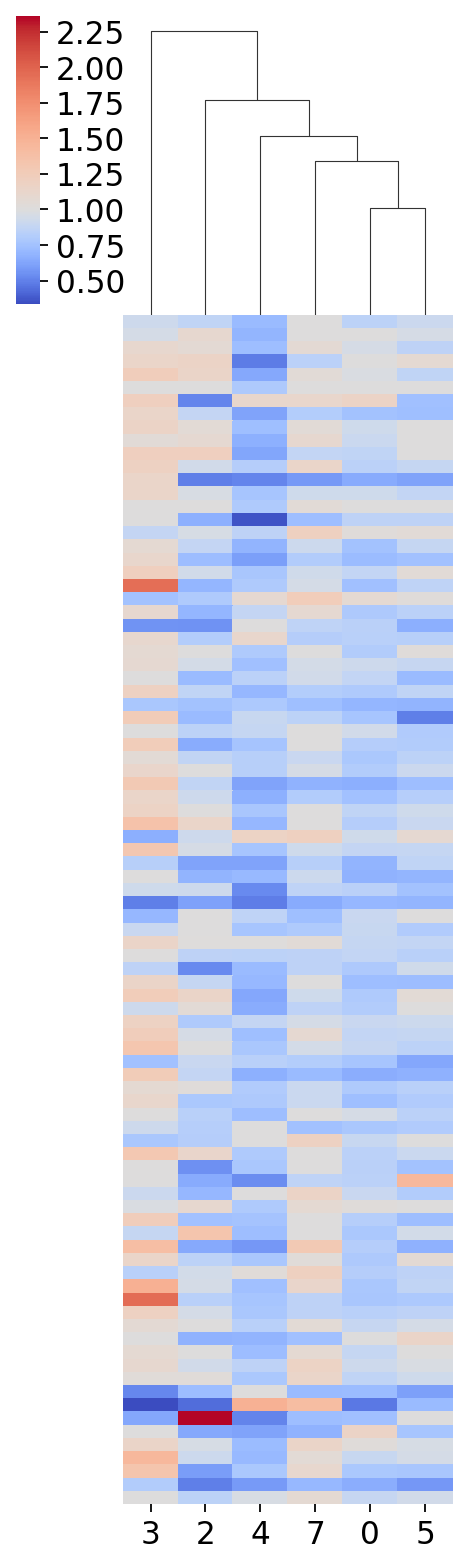

In [25]:
# Heatmap of pathway activities
# Need to double check best clustering parameters
df_p = pd.DataFrame(p_sig)
fig = sns.clustermap(df_p, cmap='coolwarm', yticklabels=[], #yticklabels=metab_genes.index,
                     xticklabels=['0', '2', '3', '4', '5', '7'],  
                     norm=DivergingNorm(1.0), row_cluster=False, figsize=(3, 10))

## Pathway activity based on treatment status


In [22]:
adata.obs['no_IL6i_time'] = adata.obs['no_IL6i'].astype(str) + '.' + adata.obs['Blood_draw_time'].astype(str)

In [23]:
# Here, cell type is defined as individual clusters ('louvain')
# within a given group of immune cells (B cells, T cells, etc.)
# Clusters calculated from all genes rather than just metabolic genes
# in order to associate the metabolic gene set enrichment with the non-metabolic analyses
p = pathway_activity(adata, adata_metab, 'no_IL6i_time', print_labels=True)

Healthy.Healthy
after.T2
before.T1
no.T1
no.T2


In [13]:
# Statistical significance of higher or lower pathway activity in a specific cell type
# Random permutation test
enriched = (p > 1)
decreased = (p < 1)

# Shuffle cell cluster labels 5000x
n = 5000
compares = np.zeros((len(p), len(p[0])))
for i in range(n):
    if i % 100 == 0:
        print(i)
    clusters_shuffled = np.random.permutation(adata.obs['no_IL6i_time'])
    adata.obs['no_IL6i_time_shuffle'] = clusters_shuffled
    adata_metab.obs['no_IL6i_time_shuffle'] = clusters_shuffled
    
    # Compare new pathway activity scores to original dataset pathway activity scores
    p_shuffle = pathway_activity(adata, adata_metab, 'no_IL6i_time_shuffle');
    compares += enriched * (p_shuffle > p) + decreased * (p_shuffle < p)

compares /= n

# Non-significantly changed activity scores are reverted to 1 (no activity change)
significant = (compares < 0.01)
p_sig = p ** significant
#p_sig

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900


In [56]:
# Save pathway activity scores
df_p = pd.DataFrame(p_sig)
df_p.to_csv(master_dir + 'output/pathway_activity/' + celltype + '-metab-no_IL6i-pathway_activity.tabular', 
                       sep='\t', header=None, index=None)

<ipython-input-24-9ec73cca64d0>:6: MatplotlibDeprecationWarning: 
The DivergingNorm class was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use TwoSlopeNorm instead.
  row_cluster=None, norm=DivergingNorm(1.0), figsize=(3.5, 10))


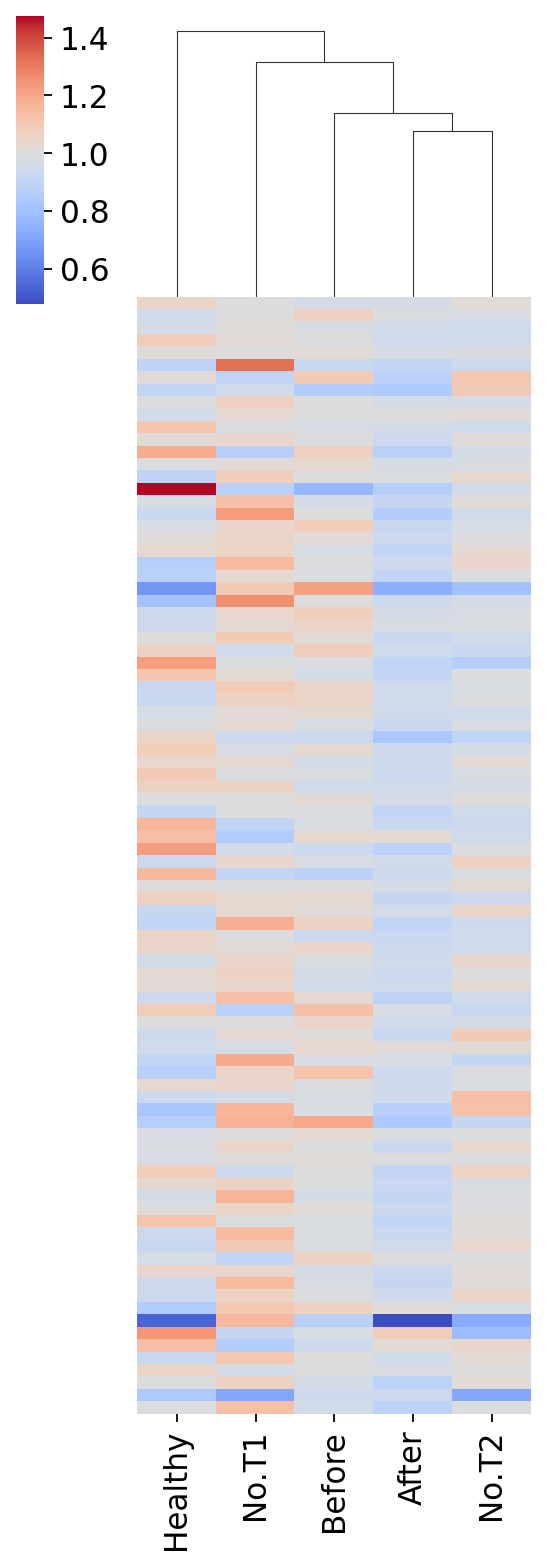

In [24]:
# Heatmap of pathway activities
#fig = plt.figure(figsize=(15, 20))
p_sig_reorder = p[:, [0, 2, 1, 3, 4]]
fig = sns.clustermap(p_sig_reorder, cmap='coolwarm', yticklabels=[], #metab_genes.index, 
                     xticklabels=['Healthy', 'Before', 'After', 'No.T1', 'No.T2'], 
                     row_cluster=None, norm=DivergingNorm(1.0), figsize=(3.5, 10))
#fig.set_xticklabels(adata.obs['no_IL6i'].unique())
#fig.set_xlabel('Patient IL6i status')
#fig = plt.title('CD8 T cell metabolomics by Leiden cluster')
#fig = plt.xlabel('Leiden cluster')

### Subset analysis (7/3/20)

In [59]:
p = pathway_activity(adata, adata_metab, 'louvain', print_labels=True, exclude_clusters=['8', '9'])

0
1
2
3
4
5
6
7


In [60]:
# Statistical significance of higher or lower pathway activity in a specific cell type
# Random permutation test
enriched = (p > 1)
decreased = (p < 1)

# Shuffle cell cluster labels 5000x
data = adata[adata.obs['louvain'] != '8']
data = data[data.obs['louvain'] != '9']

data_metab = adata_metab[data.obs['louvain'].index]

n = 5000
compares = np.zeros((len(p), len(p[0])))
for i in range(n):
    if i % 100 == 0:
        print(i)
    clusters_shuffled = np.random.permutation(data.obs['louvain'])
    data.obs['louvain_shuffle'] = clusters_shuffled
    data_metab.obs['louvain_shuffle'] = clusters_shuffled
    
    # Compare new pathway activity scores to original dataset pathway activity scores
    p_shuffle = pathway_activity(data, data_metab, 'louvain_shuffle')
    compares += enriched * (p_shuffle > p) + decreased * (p_shuffle < p)

compares /= n

0


Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.


100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900


In [26]:
# Non-significantly changed activity scores are reverted to 1 (no activity change)
#significant = (compares < 0.01)
#p_sig = p ** significant

# Save pathway activity scores
#df_p = pd.DataFrame(p_sig)
#df_p.to_csv(master_dir + 'output/pathway_activity/' + celltype + '-metab-cluster_wo_8_9-pathway_activity.tabular', 
#                       sep='\t', header=None, index=None)

# Read previously saved file
df_p = pd.read_csv(master_dir + 'output/pathway_activity/' + celltype + '-metab-cluster_wo_8_9-pathway_activity.tabular', 
                       sep='\t', header=None)
df_p.head()

0         1         2         3         4         5         6  \
0  1.269933  1.245714  1.161151  1.168757  0.405865  0.391888  1.095304   
1  1.253939  1.188719  1.000000  1.157423  0.385891  0.439595  1.173798   
2  1.332024  1.264875  1.082460  1.286228  0.354537  0.404020  1.163273   
3  1.187085  1.166651  1.000000  1.390074  0.291137  0.380995  1.143976   
4  1.211042  1.285650  1.093694  1.238251  0.644359  0.480916  1.163528   

          7  
0  0.711510  
1  0.836356  
2  0.615205  
3  0.721394  
4  0.852729

In [27]:
# Heatmap of pathway activities
# Need to double check best clustering parameters
fig = sns.clustermap(df_p, cmap='bwr', yticklabels=[], #metab_genes.index, 
                     row_cluster=False, norm=DivergingNorm(1.0), figsize=(6, 10))
#fig = plt.title('CD8 T cell metabolomics by Leiden cluster')
#fig = plt.xlabel('Leiden cluster')

In [63]:
# Now without clusters 4, 5, 8, 9
p = pathway_activity(adata, adata_metab, 'louvain', print_labels=True, exclude_clusters=['4', '5', '8', '9'],
                    nanval=1)

0
1
2
3
6
7


In [70]:
p_healthy = pathway_activity(adata[adata.obs['WHO_scale']==0], 
                            adata_metab[adata.obs['WHO_scale']==0], 'louvain', 
                             print_labels=True, exclude_clusters=['4', '5', '8', '9'],
                            nanval=1)

0
1
2
3
6
7


In [71]:
p_nonICU = pathway_activity(adata[adata.obs['ICU_status']=='Non-ICU'], 
                            adata_metab[adata.obs['ICU_status']=='Non-ICU'], 'louvain', 
                             print_labels=True, exclude_clusters=['4', '5', '8', '9'],
                            nanval=1)

0
1
2
3
6
7


In [72]:
p_ICU = pathway_activity(adata[adata.obs['ICU_status']=='ICU'], 
                            adata_metab[adata.obs['ICU_status']=='ICU'], 'louvain', 
                             print_labels=True, exclude_clusters=['4', '5', '8', '9'],
                            nanval=1)

0
1
2
3
6
7


In [66]:
# Statistical significance of higher or lower pathway activity in a specific cell type
# Random permutation test
enriched = (p > 1)
decreased = (p < 1)

# Shuffle cell cluster labels 5000x
data = adata[adata.obs['louvain'].isin(['0', '1', '2', '3', '6', '7'])]

data_metab = adata_metab[data.obs['louvain'].index]

n = 5000
compares = np.zeros((len(p), len(p[0])))
for i in range(n):
    if i % 100 == 0:
        print(i)
    clusters_shuffled = np.random.permutation(data.obs['louvain'])
    data.obs['louvain_shuffle'] = clusters_shuffled
    data_metab.obs['louvain_shuffle'] = clusters_shuffled
    
    # Compare new pathway activity scores to original dataset pathway activity scores
    p_shuffle = pathway_activity(data, data_metab, 'louvain_shuffle')
    compares += enriched * (p_shuffle > p) + decreased * (p_shuffle < p)

compares /= n

0


Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.


100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900


In [28]:
# Non-significantly changed activity scores are reverted to 1 (no activity change)
#significant = (compares < 0.01)
#p_sig = p ** significant
#p_sig

# Save pathway activity scores
#df_p = pd.DataFrame(p_sig)
#df_p.to_csv(master_dir + 'output/pathway_activity/' + celltype + '-metab-cluster_wo_4_5_8_9-pathway_activity.tabular', 
#                       sep='\t', header=None, index=None)
df_p = pd.read_csv(master_dir + 'output/pathway_activity/' + celltype + '-metab-cluster_wo_4_5_8_9-pathway_activity.tabular', 
                       sep='\t', header=None)
df_p.head()

0         1         2         3         4         5
0  1.000000  1.000000  1.000000  1.000000  0.921849  0.596736
1  1.000000  1.000000  0.917541  1.000000  1.000000  0.713411
2  1.106028  1.053556  0.904311  1.060293  1.000000  0.495121
3  1.390660  1.000000  0.853480  1.166655  1.000000  0.649370
4  1.058167  1.114285  0.963604  1.076078  1.000000  0.742756

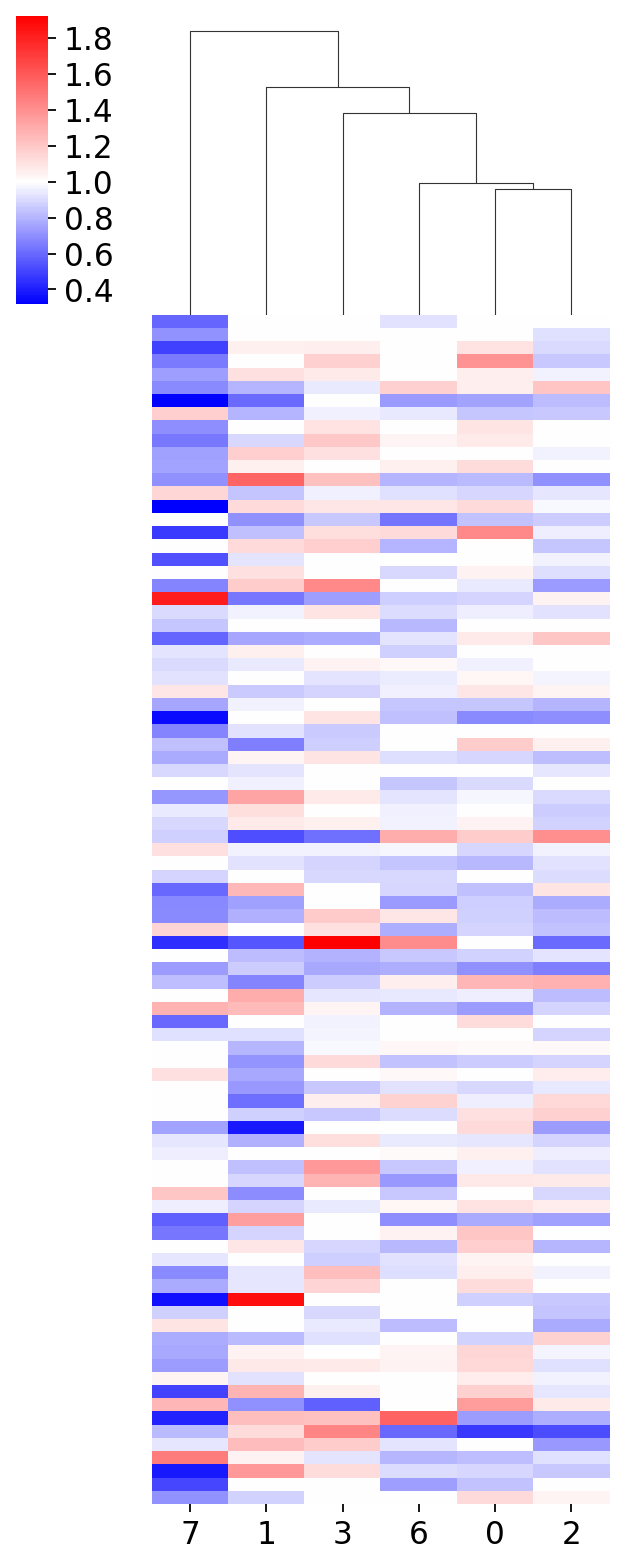

In [30]:
# Heatmap of pathway activities
# Need to double check best clustering parameters
fig = sns.clustermap(df_p, cmap='bwr', yticklabels=[], #metab_genes.index, 
                     row_cluster=False,
                     xticklabels=['0', '1', '2', '3', '6', '7'], 
                     norm=DivergingNorm(1.0), figsize=(4, 10))
#fig = plt.title('CD8 T cell metabolomics by Leiden cluster')
#fig = plt.xlabel('Leiden cluster')

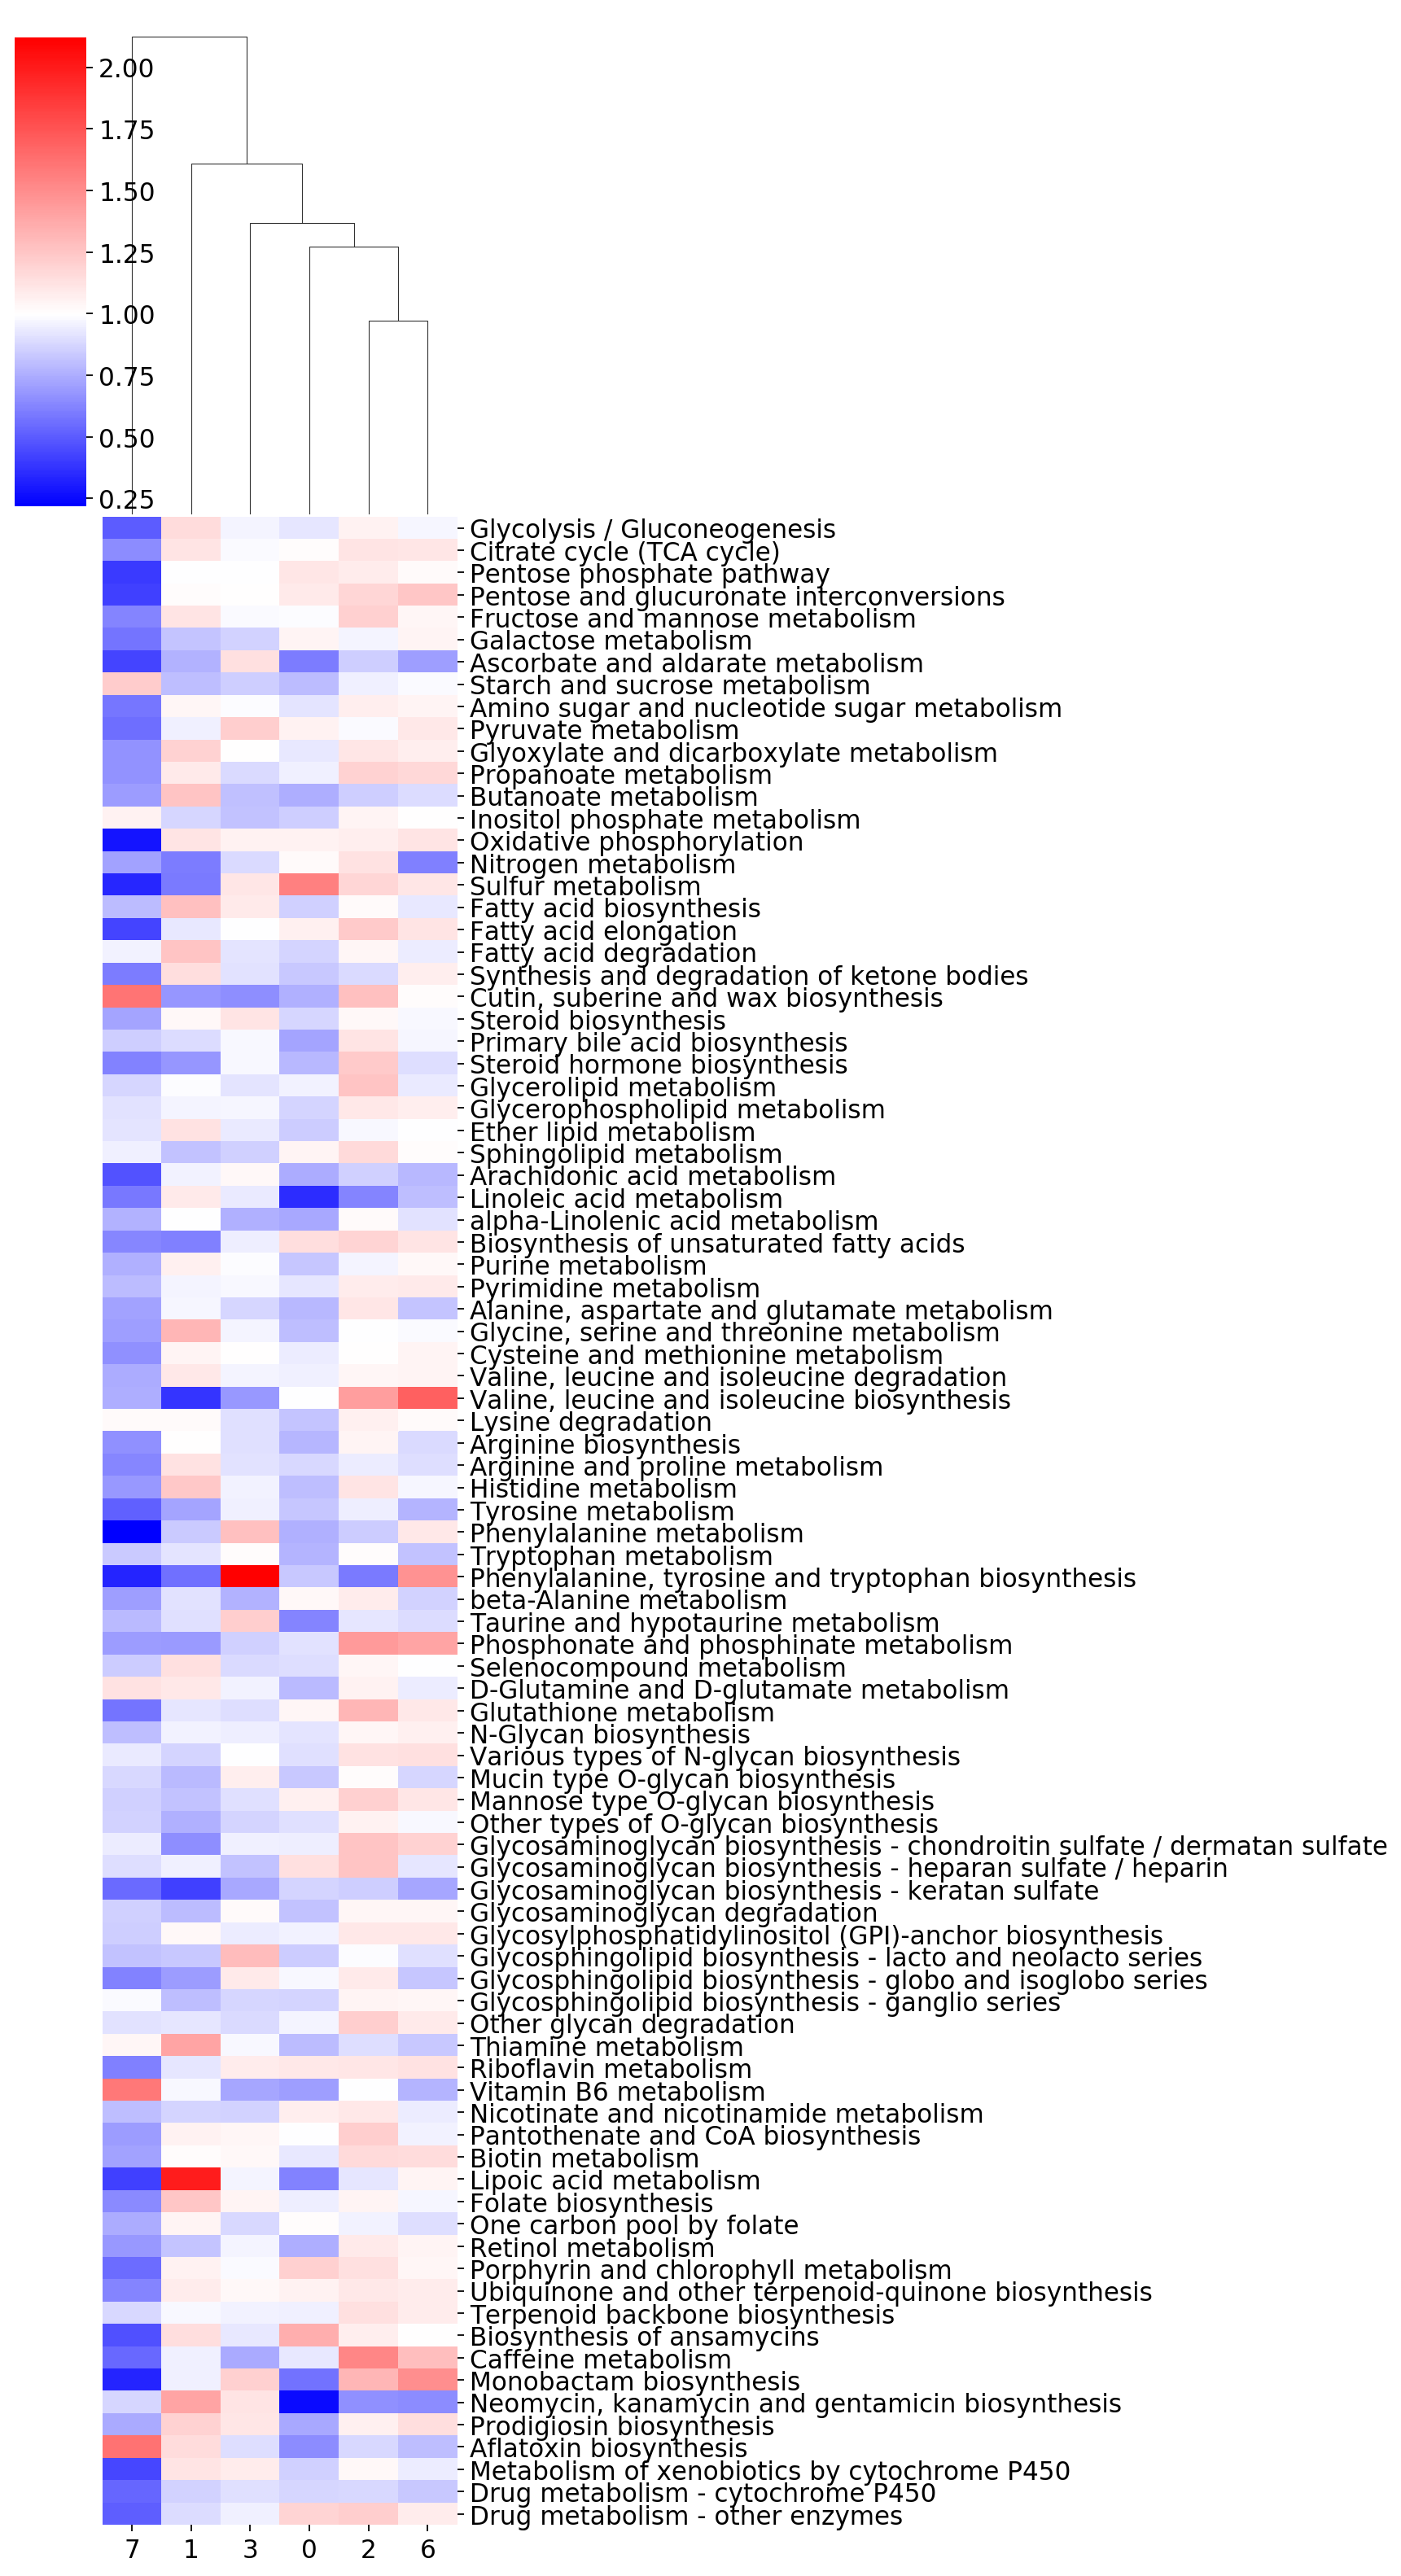

In [73]:
fig = sns.clustermap(p_healthy, cmap='bwr', yticklabels=metab_genes.index, row_cluster=False,
                     xticklabels=['0', '1', '2', '3', '6', '7'], figsize=(11, 20),
                     norm=DivergingNorm(1.0))

In [74]:
# Non-significantly changed activity scores are reverted to 1 (no activity change)
#significant = (compares < 0.01)
#p_sig = p ** significant
#p_sig

# Save pathway activity scores
df_p = pd.DataFrame(p_healthy)
df_p.to_csv(master_dir + 'output/pathway_activity/' + celltype + 
            '-healthy-metab-cluster_wo_4_5_8_9-pathway_activity.tabular', 
                       sep='\t', header=None, index=None)

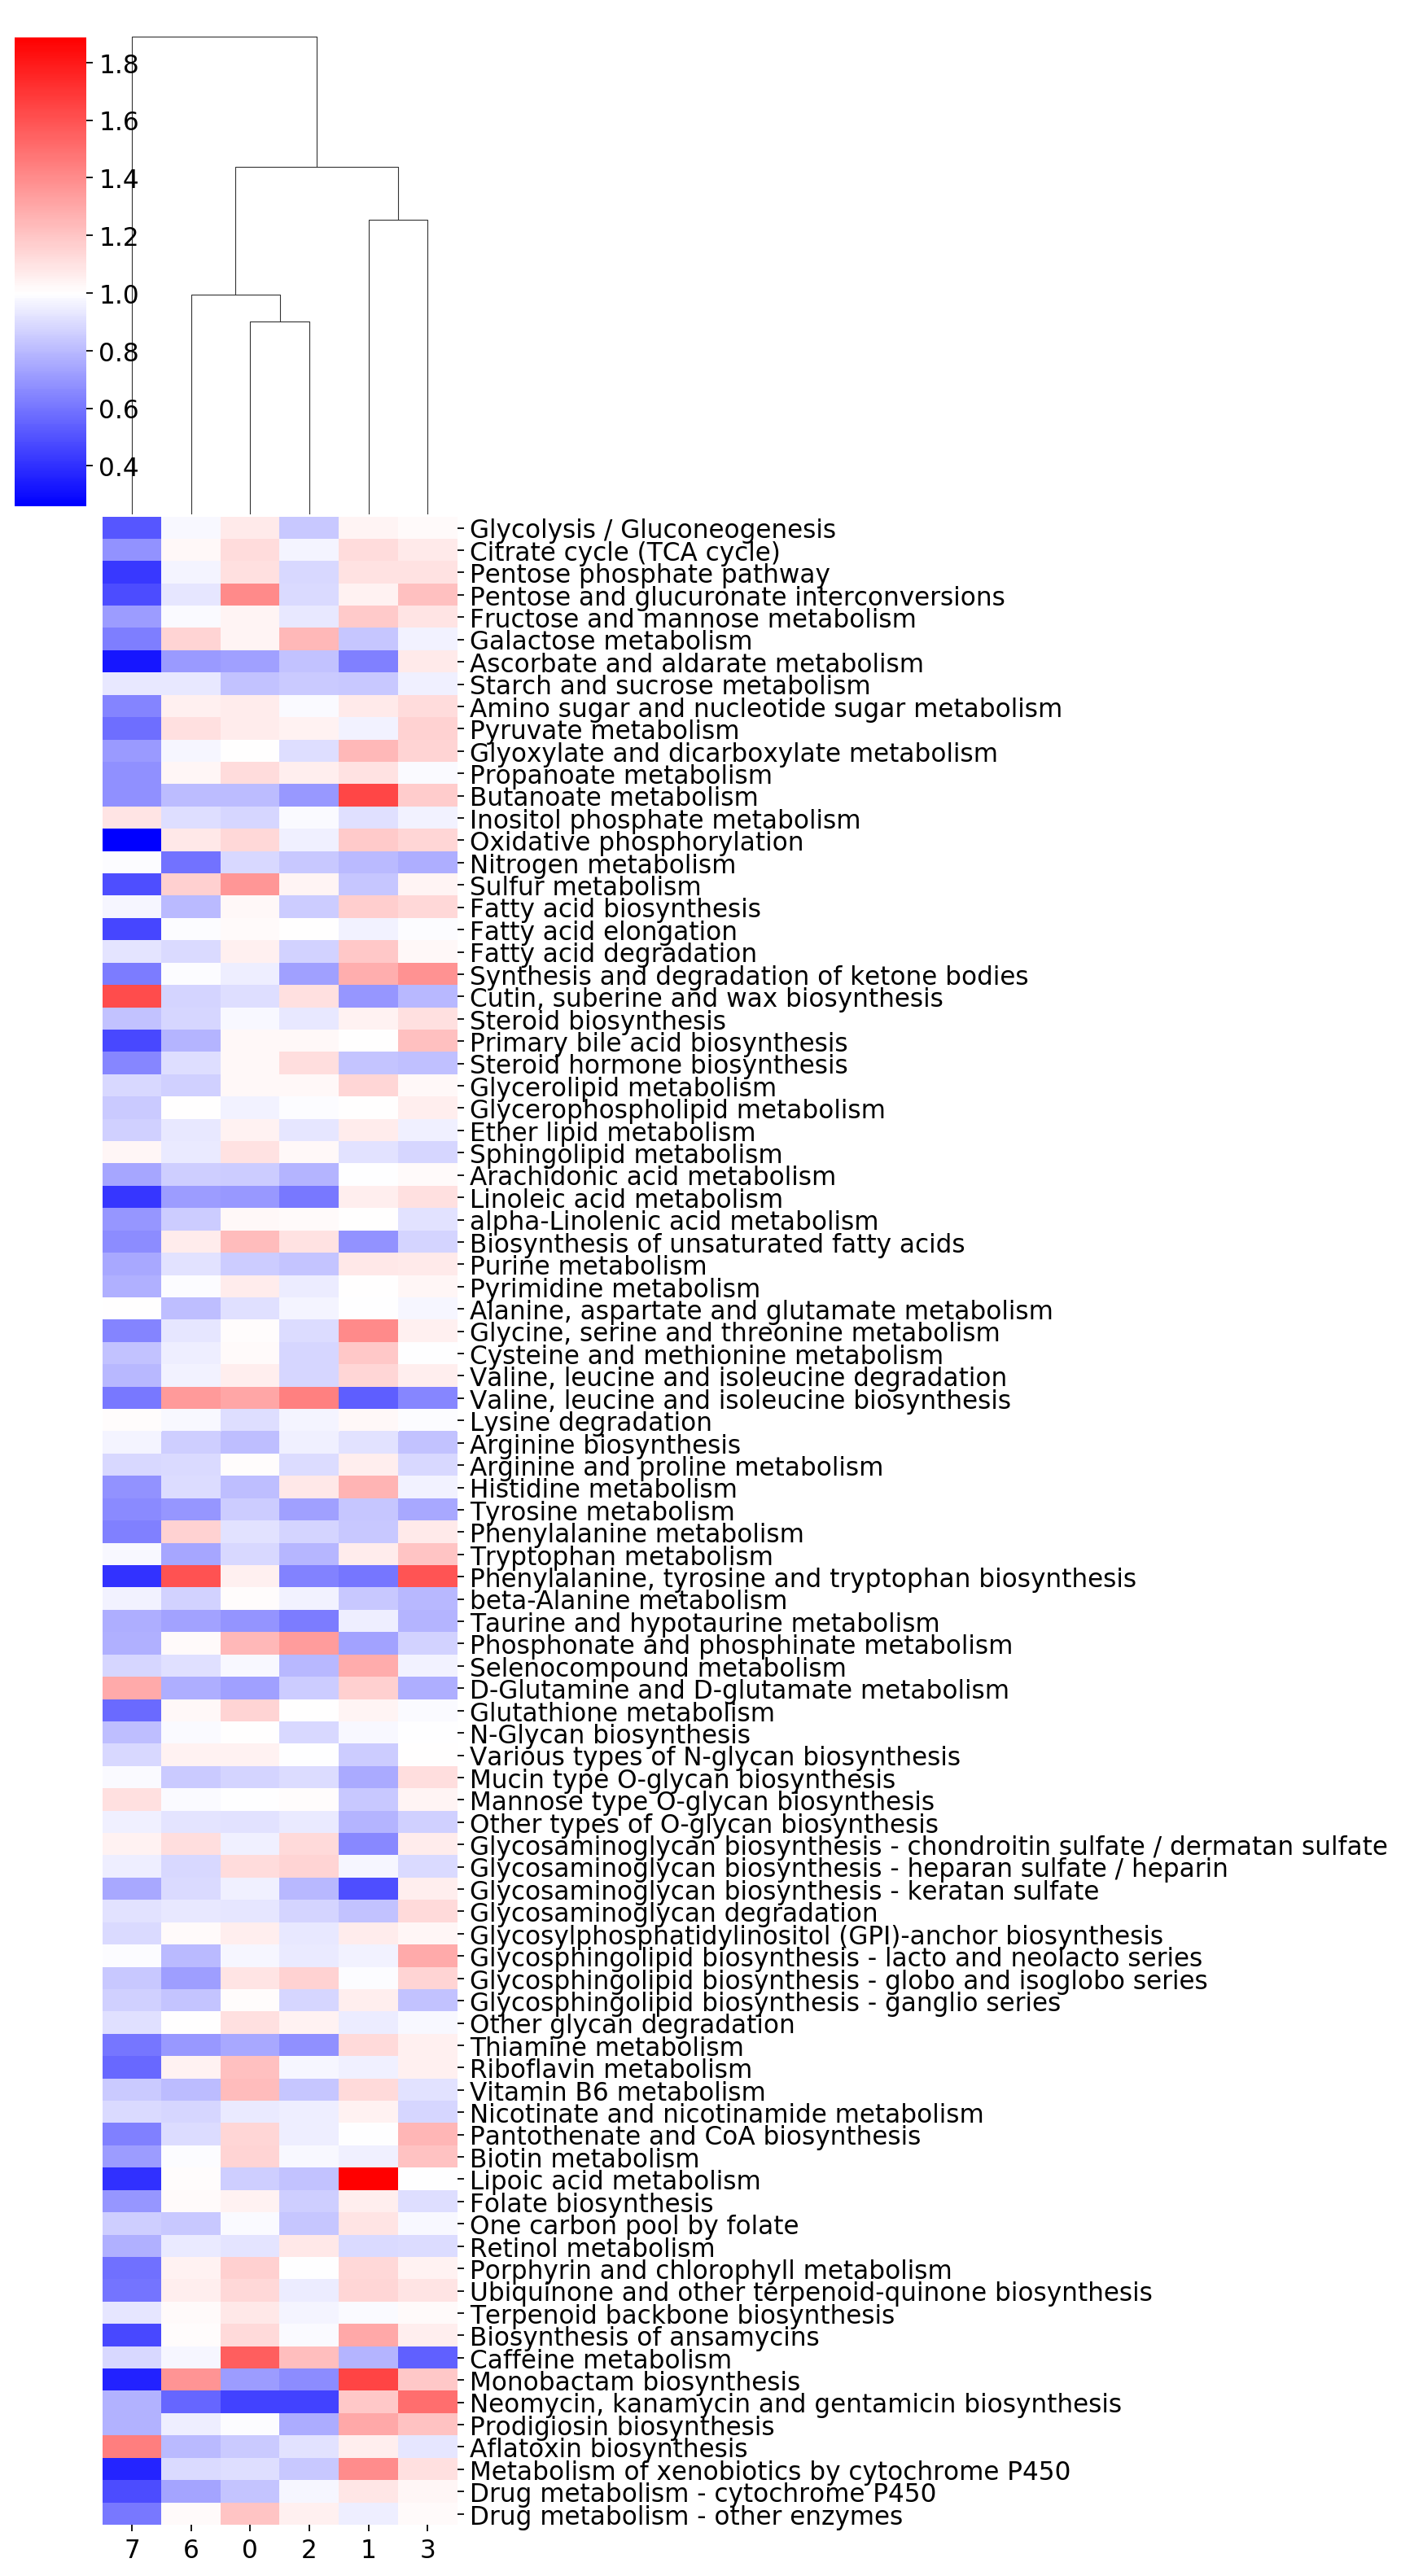

In [75]:
fig = sns.clustermap(p_nonICU, cmap='bwr', yticklabels=metab_genes.index, row_cluster=False,
                     xticklabels=['0', '1', '2', '3', '6', '7'], figsize=(11, 20),
                     norm=DivergingNorm(1.0))

In [76]:
# Non-significantly changed activity scores are reverted to 1 (no activity change)
#significant = (compares < 0.01)
#p_sig = p ** significant
#p_sig

# Save pathway activity scores
df_p = pd.DataFrame(p_nonICU)
df_p.to_csv(master_dir + 'output/pathway_activity/' + celltype + 
            '-nonICU-metab-cluster_wo_4_5_8_9-pathway_activity.tabular', 
                       sep='\t', header=None, index=None)

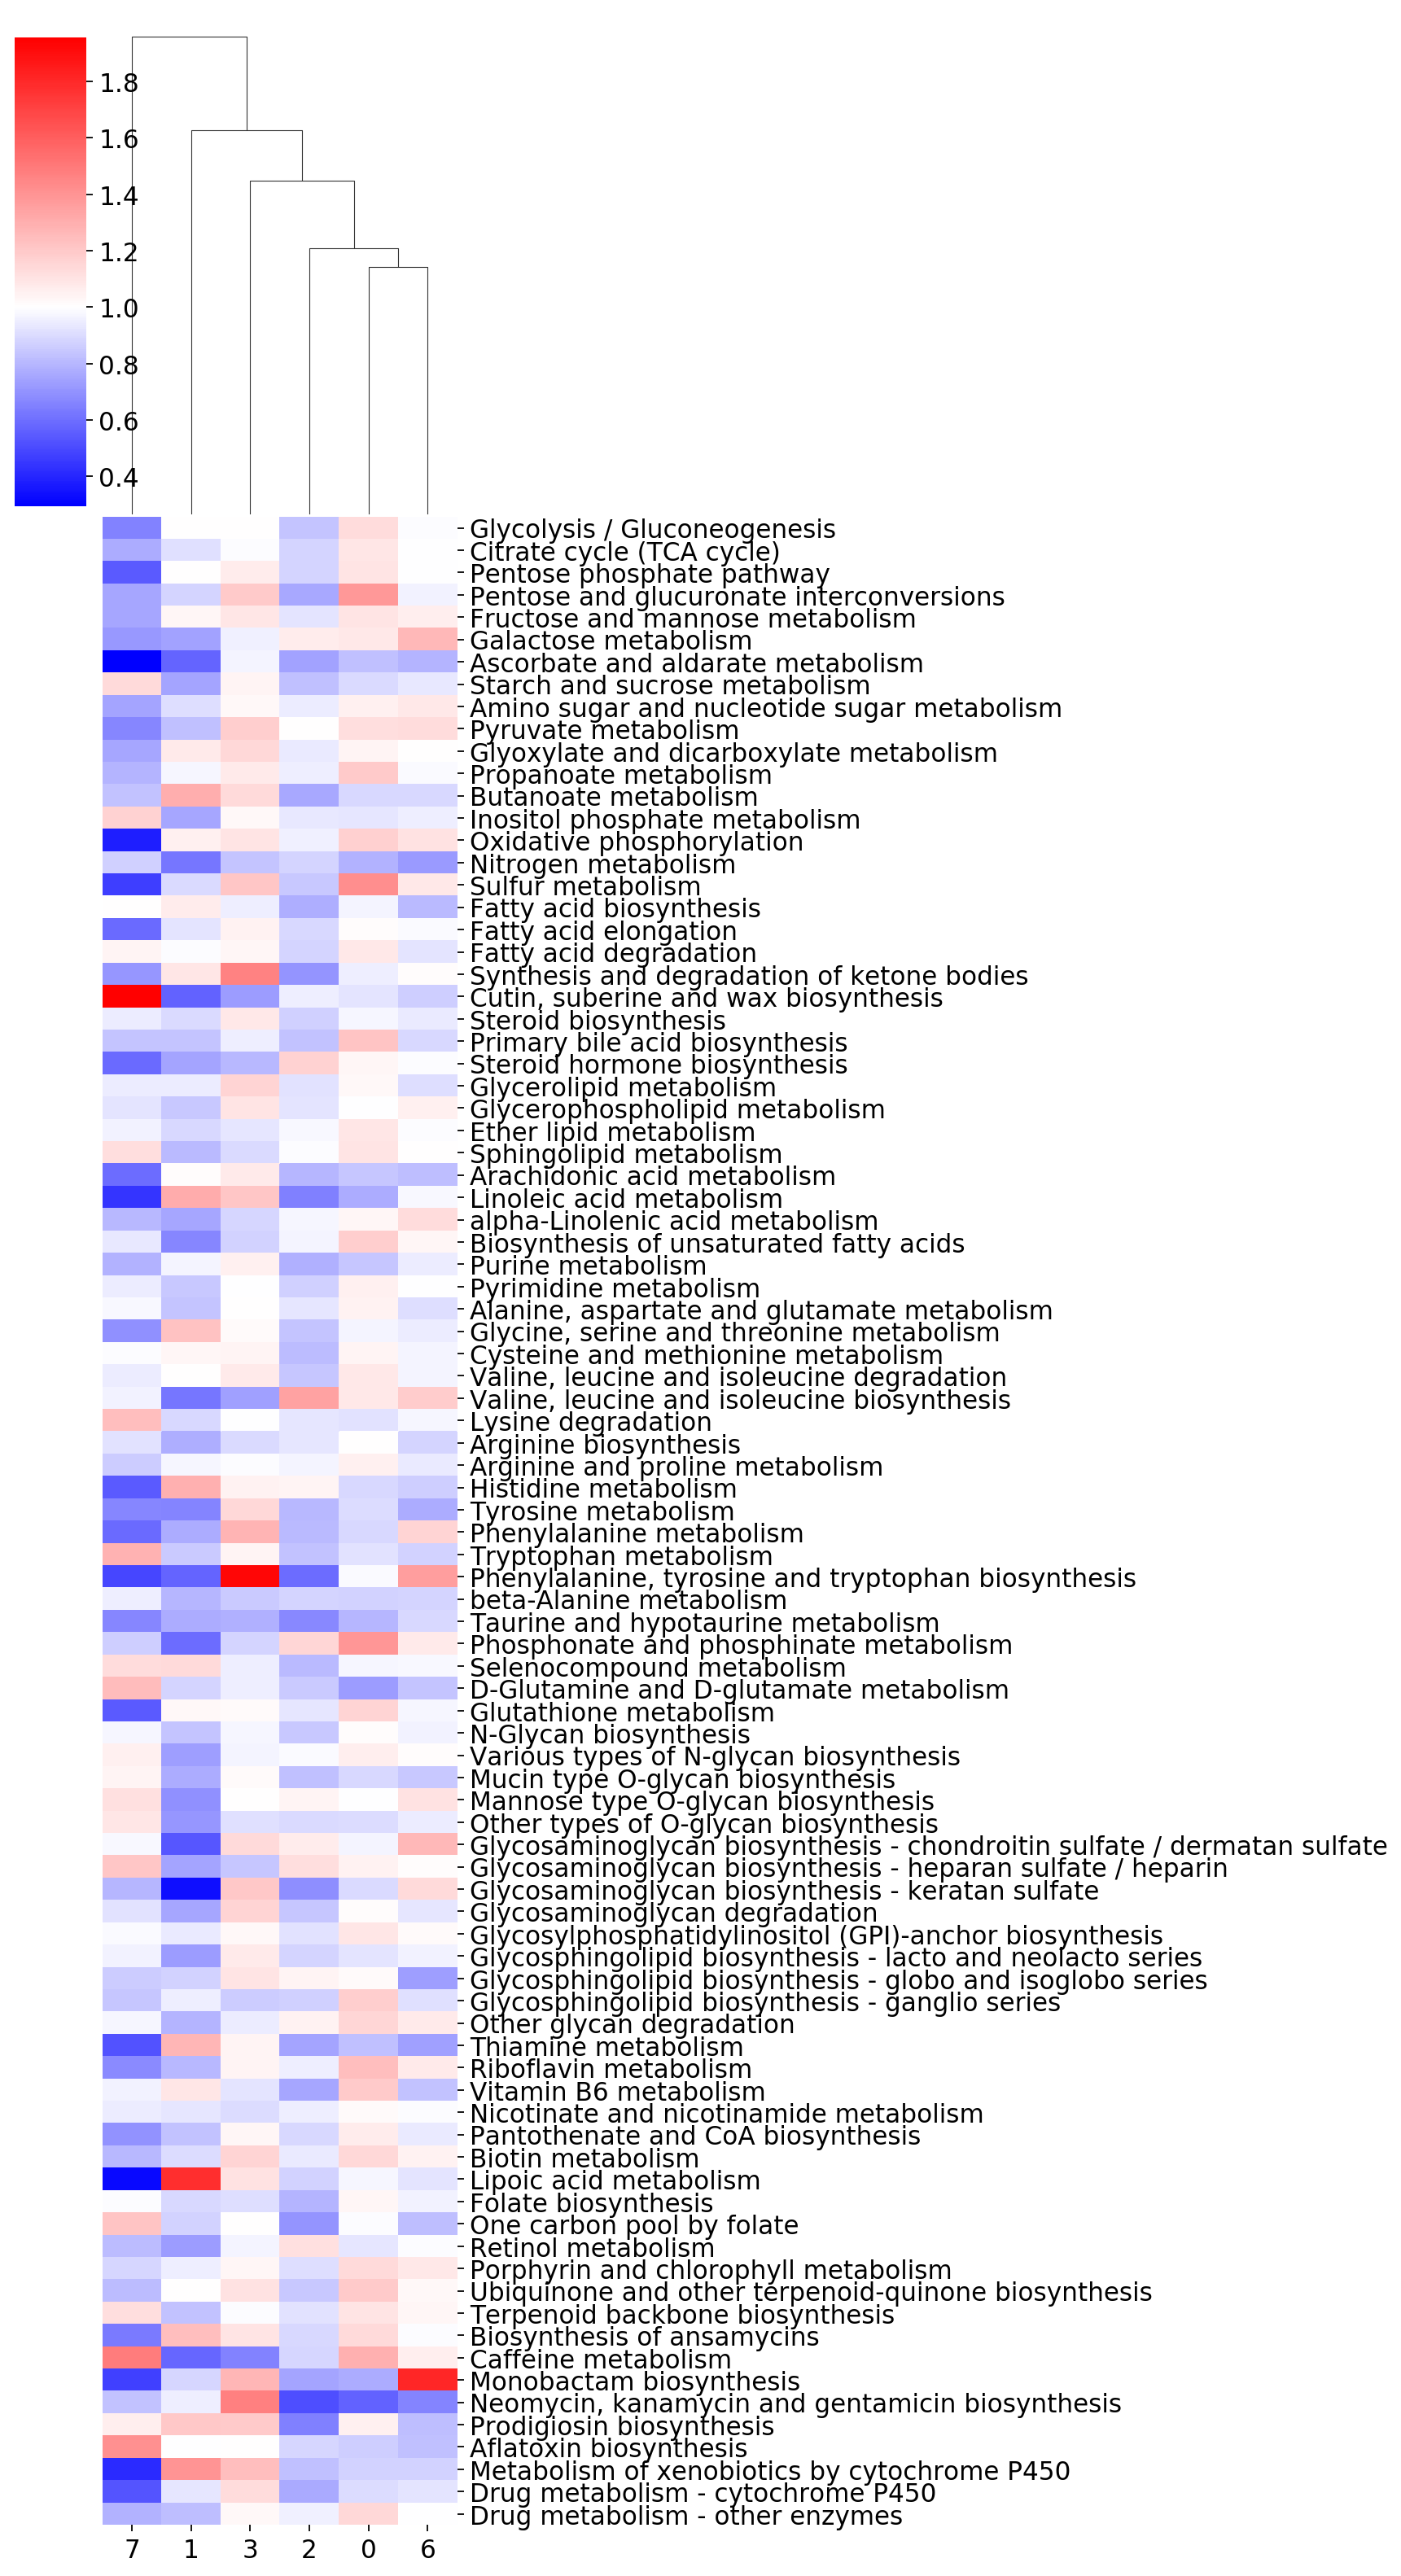

In [77]:
fig = sns.clustermap(p_ICU, cmap='bwr', yticklabels=metab_genes.index, row_cluster=False,
                     xticklabels=['0', '1', '2', '3', '6', '7'], figsize=(11, 20),
                     norm=DivergingNorm(1.0))

In [78]:
# Non-significantly changed activity scores are reverted to 1 (no activity change)
#significant = (compares < 0.01)
#p_sig = p ** significant
#p_sig

# Save pathway activity scores
df_p = pd.DataFrame(p_ICU)
df_p.to_csv(master_dir + 'output/pathway_activity/' + celltype + 
            '-ICU-metab-cluster_wo_4_5_8_9-pathway_activity.tabular', 
                       sep='\t', header=None, index=None)

### Analysis per patient

#### All cells

In [11]:
# Not using subpopulations here for now
p = pathway_activity(adata, adata_metab, 'patient', print_labels=True)

1-1
1-2
10-1
10-2
11-1
11-2
12-1
12-2
13-1


/usr/lusers/jlee712/anaconda3/lib/python3.8/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):


13-2
14-1
15-1
15-2
16-1
16-2
17-1
17-2
19-1
19-2
2-1
2-2
20-1
20-2
22-1
22-2
23-1
23-2
24-1
24-2
25-1
25-2
3-1
3-2
31-1
31-2
33-1
33-2
36-1
36-2
4-1
4-2
5-1
5-2
6-1
6-2
7-1
7-2
8-1
9-1
9-2
BP0219101
BP0319250
BP05191345
BP08191115
CL2
Mix_donor1


<ipython-input-12-722fed5ff44e>:16: MatplotlibDeprecationWarning: 
The DivergingNorm class was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use TwoSlopeNorm instead.
  norm=DivergingNorm(1.0))


Text(0.5, 91.5746527777778, '')

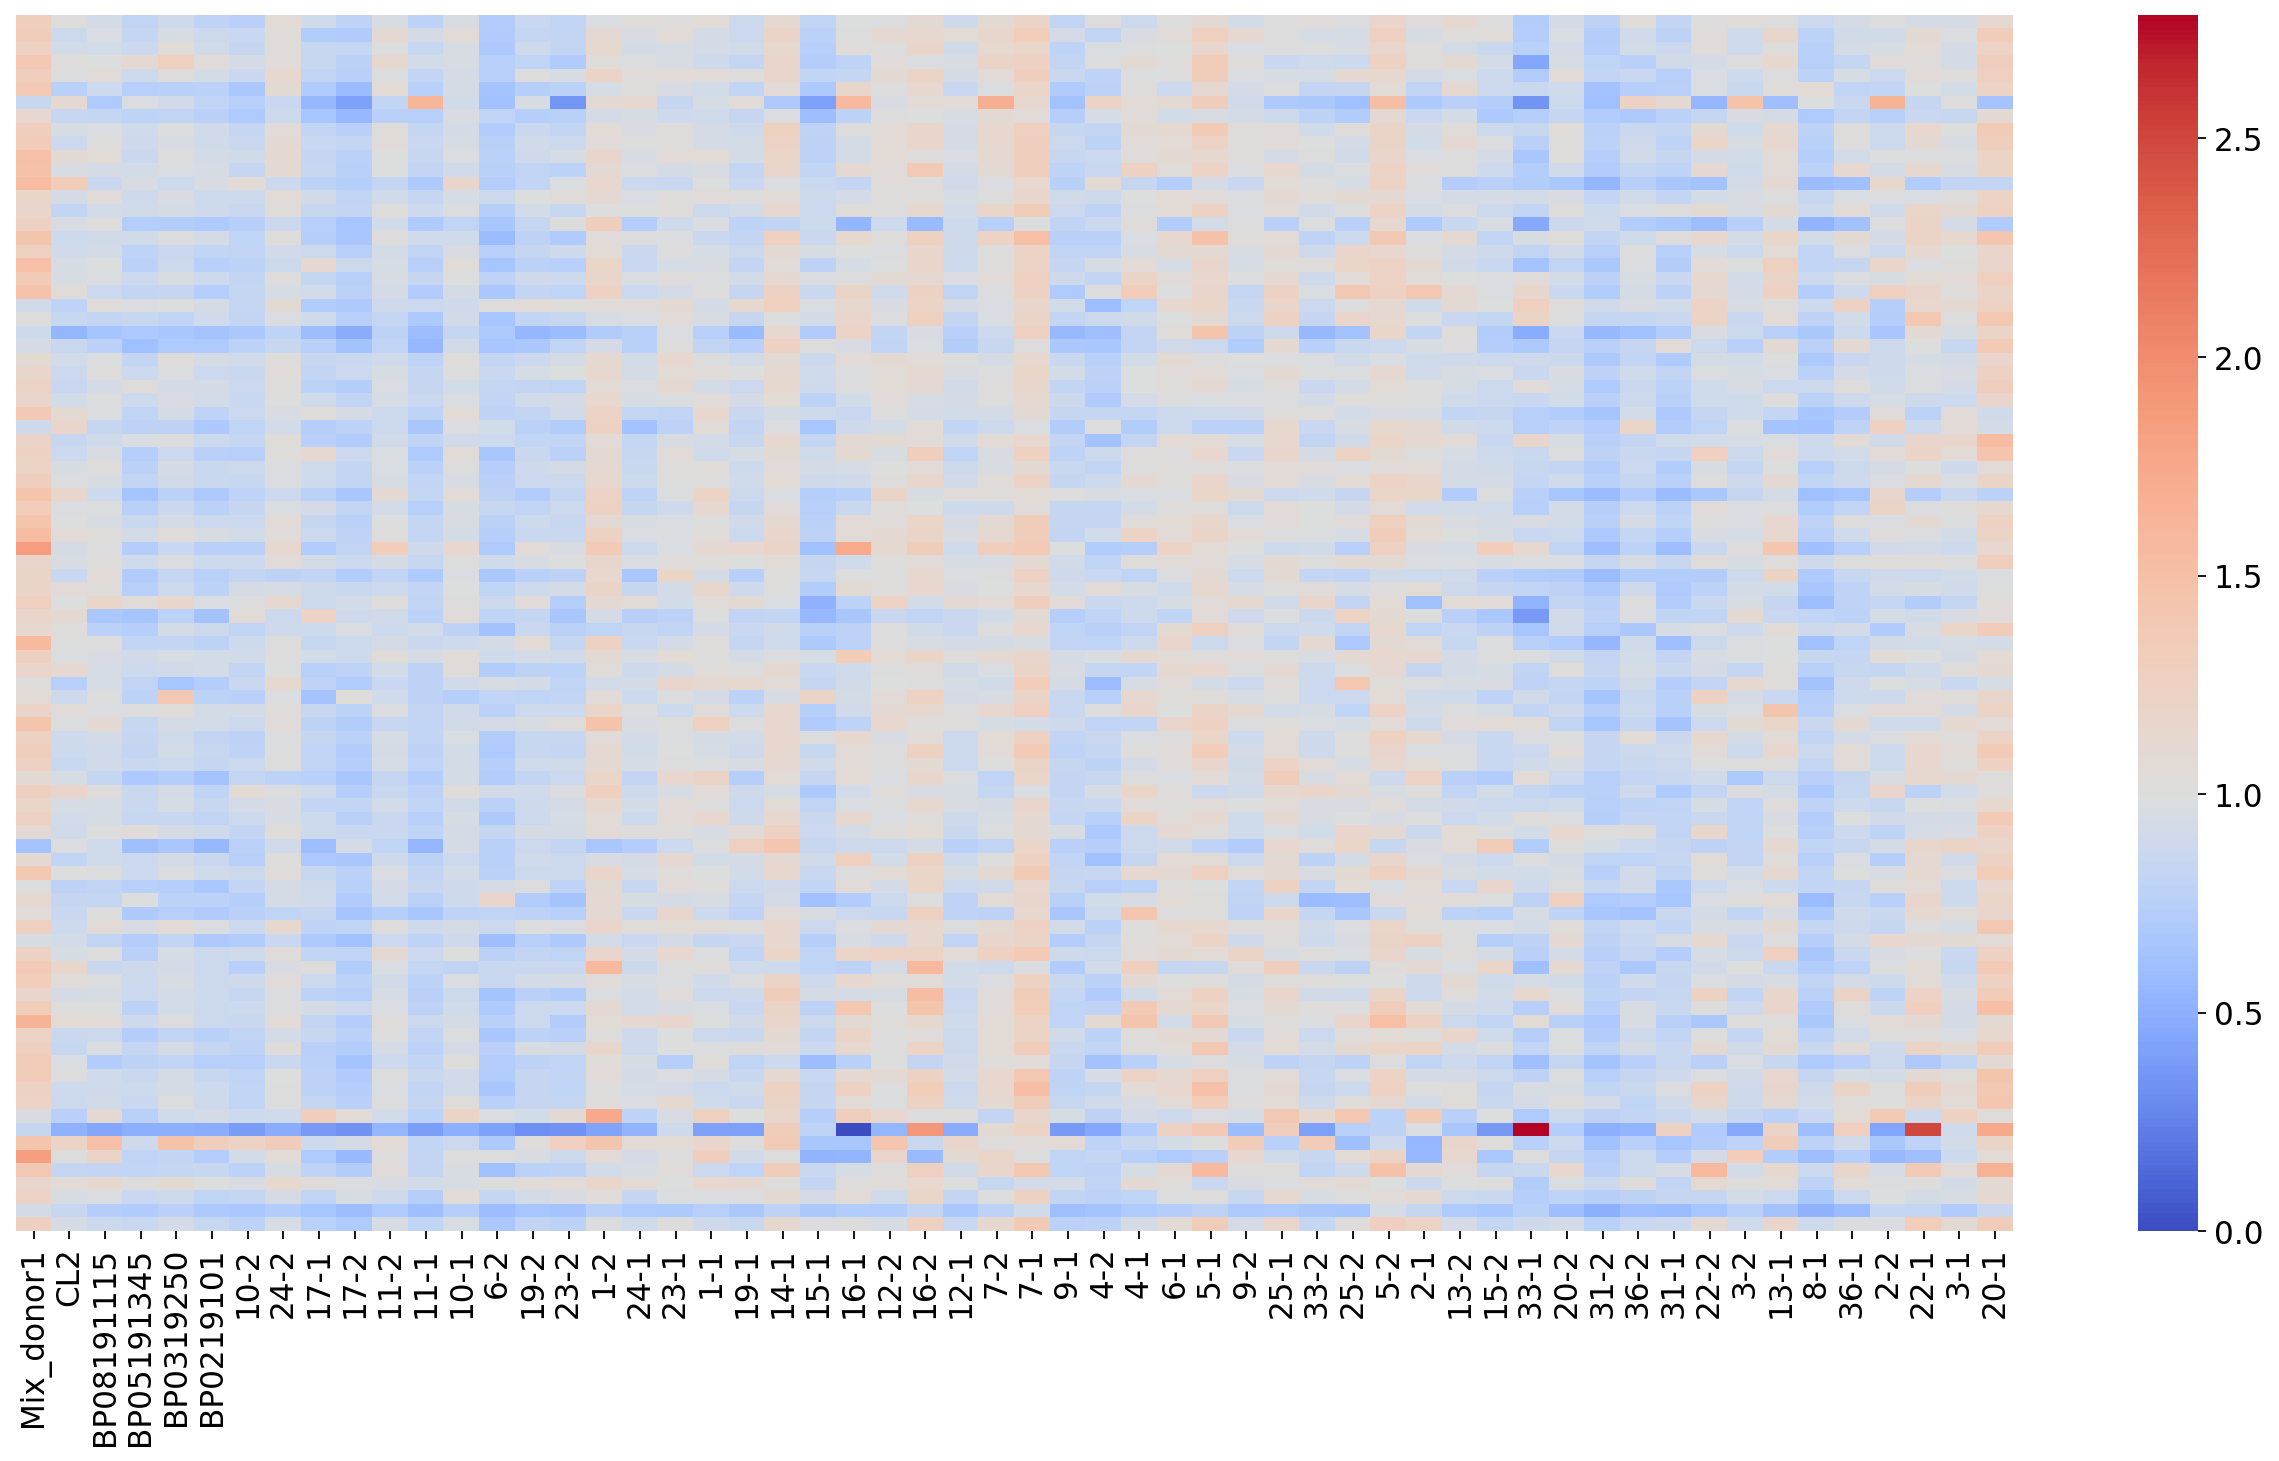

In [12]:
df_p = pd.DataFrame(p)
df_p.index = metab_genes.index
patients = adata.obs['patient'].unique().astype(str)
patients.sort()
df_p.columns = patients

# Plot in order of increasing WHO score
patients_WHO = adata.obs.sort_values(by='WHO_scale', axis=0)['patient'].unique()
#patients_ICU = adata.obs.sort_values(by='ICU_status', axis=0)['patient'].unique()
#patients_age = adata.obs.sort_values(by='Age_at_baseline', axis=0)['patient'].unique()
#patients_days = adata.obs.sort_values(by='Days_since_onset_of_symptoms', axis=0)['patient'].unique()
df_p = df_p.loc[:, patients_WHO]

ax = plt.figure(figsize=(20, 10))
ax = sns.heatmap(df_p, cmap='coolwarm', yticklabels=metab_genes.index, vmin=0,
                     norm=DivergingNorm(1.0))
ax.set_yticks([])
ax.set_ylabel('')
ax.set_xlabel('')

In [61]:
# Statistical significance of higher or lower pathway activity in a specific cell type
# Random permutation test
enriched = (p > 1)
decreased = (p < 1)

# Shuffle cell cluster labels 5000x

n = 1000
compares = np.zeros((len(p), len(p[0])))
for i in range(n):
    if i % 100 == 0:
        print(i)
    clusters_shuffled = np.random.permutation(adata.obs['patient'])
    adata.obs['patient_shuffled'] = clusters_shuffled
    adata_metab.obs['patient_shuffled'] = clusters_shuffled
    
    # Compare new pathway activity scores to original dataset pathway activity scores
    p_shuffle = pathway_activity(adata, adata_metab, 'patient_shuffled')
    compares += enriched * (p_shuffle > p) + decreased * (p_shuffle < p)

compares /= n

# Non-significantly changed activity scores are reverted to 1 (no activity change)
significant = (compares < 0.01)
p_sig = p ** significant

# Save pathway activity scores
df_p = pd.DataFrame(p_sig)
df_p.to_csv(master_dir + 'output/pathway_activity/' + celltype + 
            '-metab-patient-pathway_activity.tabular', 
                       sep='\t', header=None, index=None)

0
100
200
300
400
500
600
700
800
900


<ipython-input-13-c9ef2c2fd1ea>:20: MatplotlibDeprecationWarning: 
The DivergingNorm class was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use TwoSlopeNorm instead.
  norm=DivergingNorm(1.0))


Text(0.5, 67.5746527777778, '')

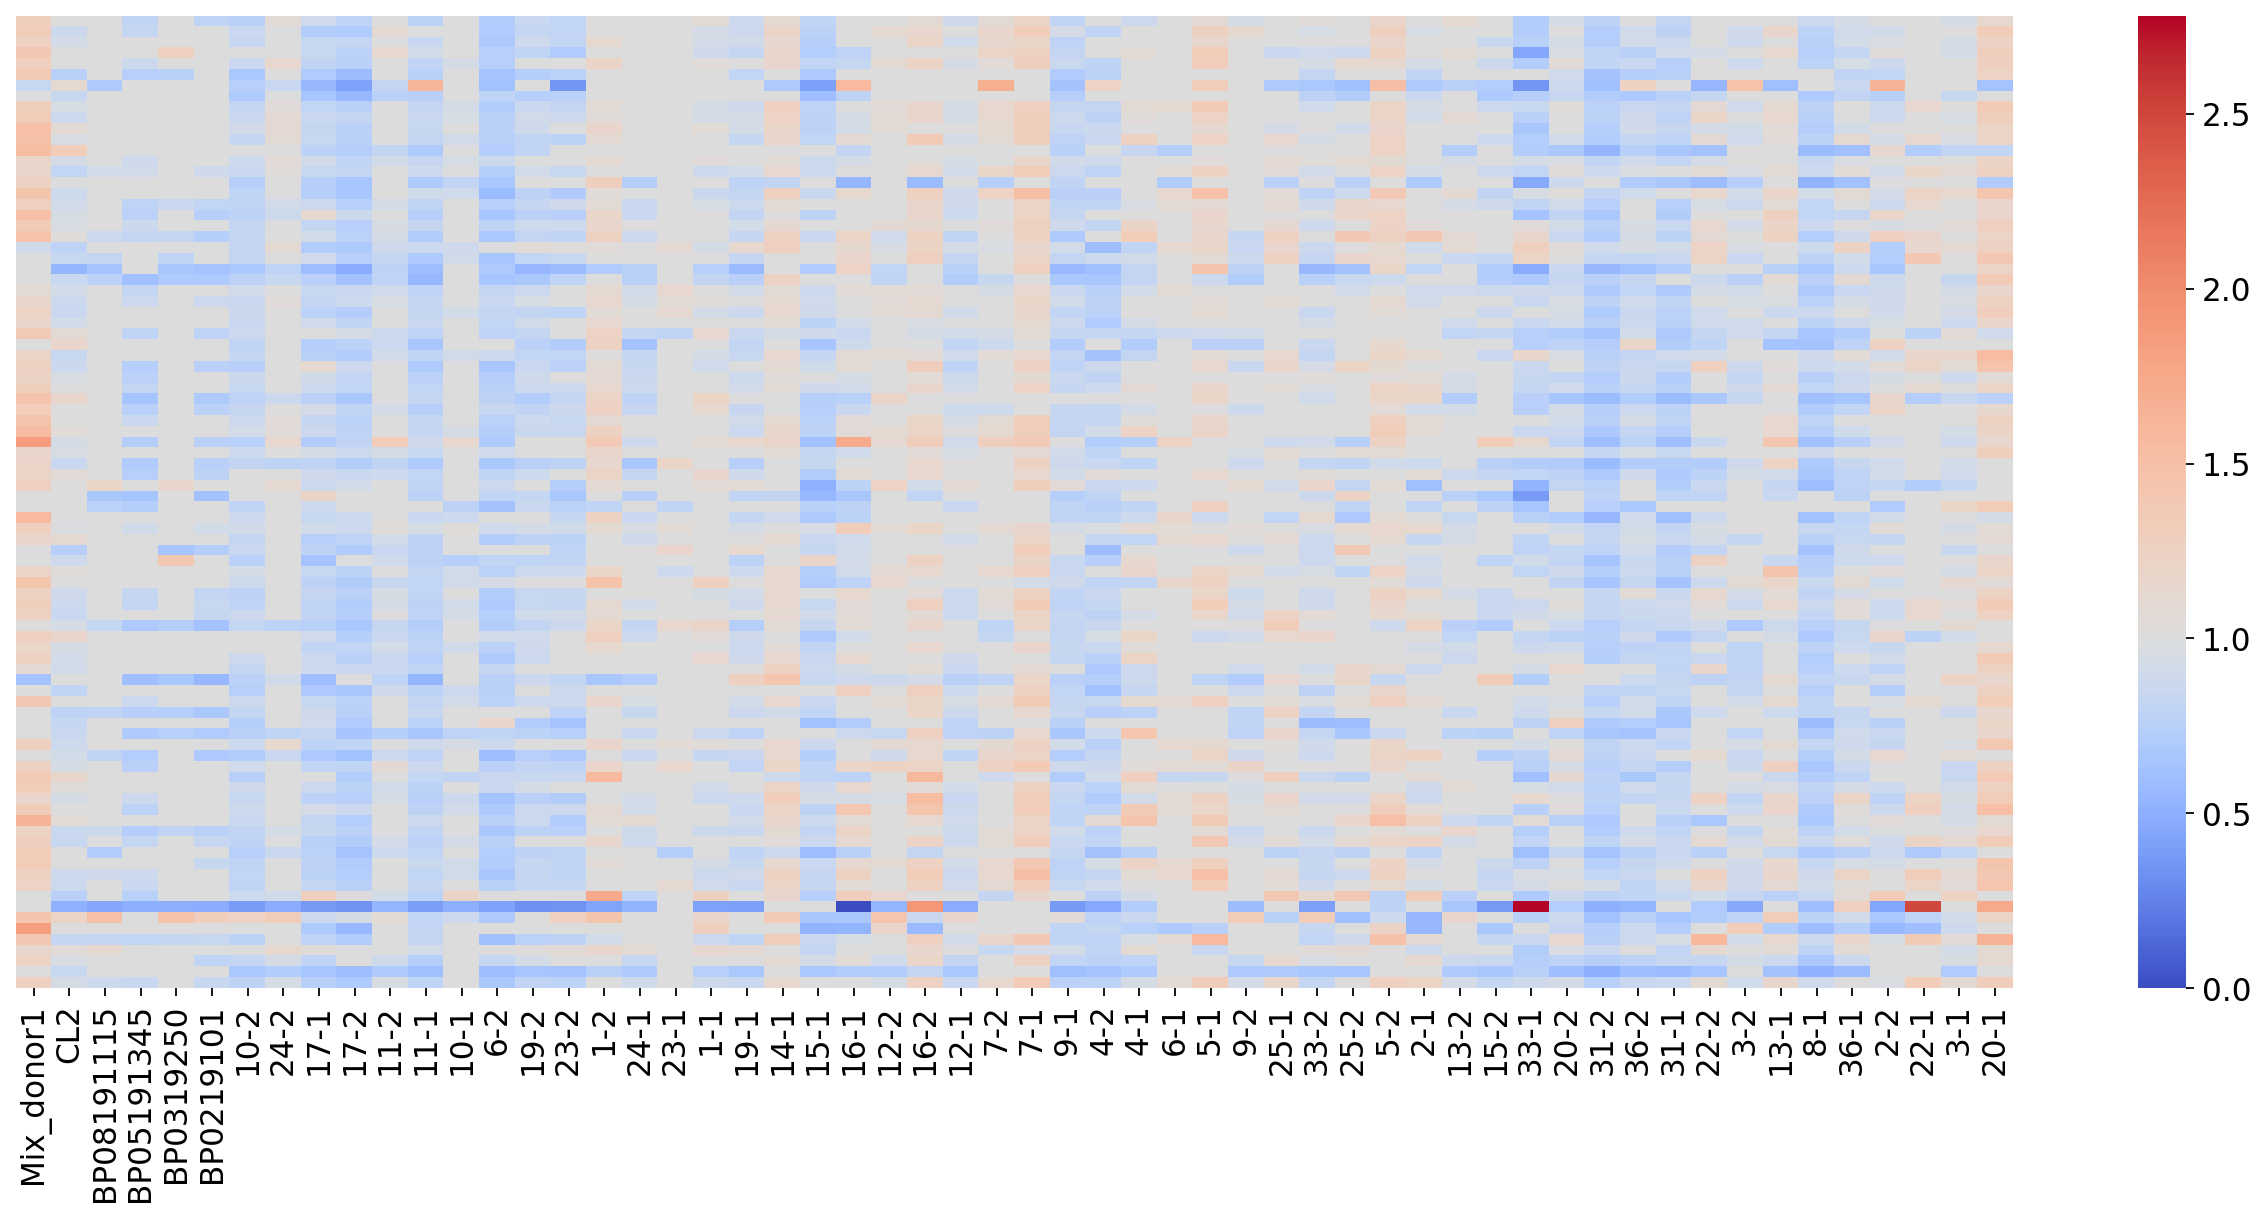

In [13]:
df_p = pd.read_csv(master_dir + 'output/pathway_activity/' + celltype + 
            '-metab-patient-pathway_activity.tabular', 
                       sep='\t', header=None)

#df_p = pd.DataFrame(p_sig)
df_p.index = metab_genes.index
patients = adata.obs['patient'].unique().astype(str)
patients.sort()
df_p.columns = patients

# Plot in order of increasing WHO score
patients_WHO = adata.obs.sort_values(by='WHO_scale', axis=0)['patient'].unique()
#patients_ICU = adata.obs.sort_values(by='ICU_status', axis=0)['patient'].unique()
#patients_age = adata.obs.sort_values(by='Age_at_baseline', axis=0)['patient'].unique()
#patients_days = adata.obs.sort_values(by='Days_since_onset_of_symptoms', axis=0)['patient'].unique()
df_p = df_p.loc[:, patients_WHO]

ax = plt.figure(figsize=(20, 8))
ax = sns.heatmap(df_p, cmap='coolwarm', yticklabels=metab_genes.index, vmin=0,
                     norm=DivergingNorm(1.0))
ax.set_yticks([])
ax.set_ylabel('')
ax.set_xlabel('')

<Figure size 320x320 with 0 Axes>

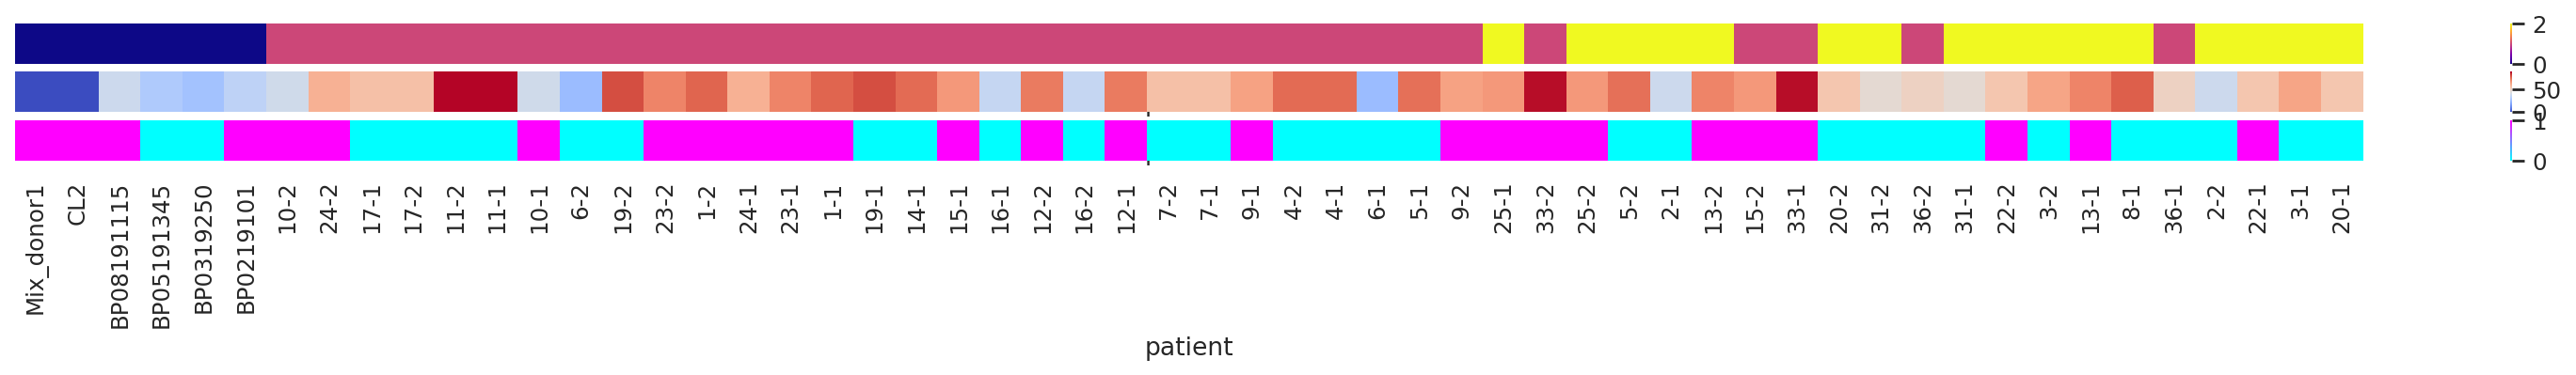

<Figure size 1280x24 with 0 Axes>

<Figure size 1280x24 with 0 Axes>

<Figure size 1280x24 with 0 Axes>

In [20]:
# Other patient attributes
adata_obs_by_patient = adata.obs.copy()
adata_obs_by_patient.index = adata_obs_by_patient['patient']
#adata_obs_by_patient.groupby(by='patient').first()
adata_obs_by_patient = adata_obs_by_patient.reset_index(drop=True)
adata_obs_by_patient = adata_obs_by_patient.groupby(by='patient').first() # All characteristics except clustering should be the same
adata_obs_by_patient['WHO_scale'] = adata_obs_by_patient['WHO_scale'].astype(int)
adata_obs_by_patient['Age_at_baseline'] = adata_obs_by_patient['Age_at_baseline'].str.replace('Not Recorded', 
                                                                                              '0').astype(int)
adata_obs_by_patient['Age_at_baseline'] = adata_obs_by_patient['Age_at_baseline'].astype(int)

# Plotting the other patient attributes
sns.set(style='white')
#sns.set(style='ticks')
sns.despine()

f, axes = plt.subplots(3, 1, figsize=(25, 1.2), sharex=False, sharey=False)

#df = adata_obs_by_patient.loc[patients_WHO, ['WHO_scale']]
#fig = plt.figure(figsize=(16, 0.3))
#fig = sns.heatmap(df.transpose(), xticklabels=[''], yticklabels=[''],
#                 cmap='Oranges', ax=axes[0])
patients_WHO = adata.obs.sort_values(by='WHO_scale', axis=0)['patient'].unique()
df = adata_obs_by_patient.loc[patients_WHO, ['ICU_status']]
df['ICU_status'] = df['ICU_status'].map({'Healthy': 0, 'Non-ICU': 1, 'ICU': 2}).astype(int)
fig = plt.figure(figsize=(16, 0.3))
fig = sns.heatmap(df.transpose(), xticklabels=[''], yticklabels=[''],
                 cmap='plasma', ax=axes[0])

#df = adata_obs_by_patient.loc[patients_WHO, ['no_IL6i']]
#df['no_IL6i'] = df['no_IL6i'].map({'Healthy': 0, 'before': 1, 'after': 2, 'no': 3}).astype(int)
#fig = plt.figure(figsize=(16, 0.3))
#fig = sns.heatmap(df.transpose(), xticklabels=[''], yticklabels=[''],
#                 cmap='viridis', ax=axes[2])

df = adata_obs_by_patient.loc[patients_WHO, ['Age_at_baseline']]
fig = plt.figure(figsize=(16, 0.3))
fig = sns.heatmap(df.transpose(), xticklabels=[''], yticklabels=[''], vmin=0,
                 cmap='coolwarm', ax=axes[1])

df = adata_obs_by_patient.loc[patients_WHO, ['Sex']]
df['Sex'] = df['Sex'].map({'Female': 1, 'Male': 0}).astype(int)
fig = plt.figure(figsize=(16, 0.3))
fig = sns.heatmap(df.transpose(), xticklabels=patients_WHO, yticklabels=[''],
                 cmap='cool', ax=axes[2])

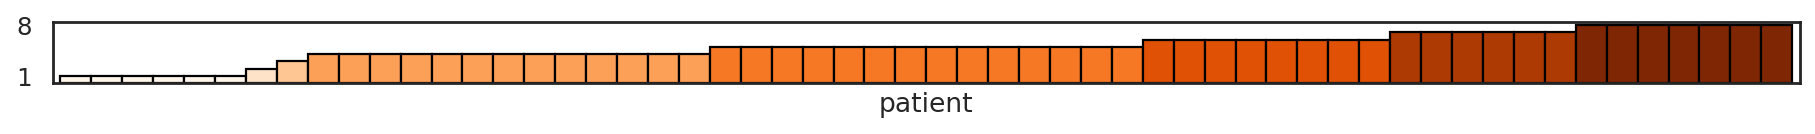

In [21]:
df = adata_obs_by_patient.loc[patients_WHO, ['WHO_scale']]
df['WHO_scale'] += 1 # Add 1 to all values in order to make all bars visible
fig = plt.figure(figsize=(14, 0.5))
oranges = cm.get_cmap('Oranges', 8)
df['c'] = [oranges(s - 1) for s in df['WHO_scale']]
fig = df['WHO_scale'].plot(kind='bar', color=df['c'], edgecolor='black', width=1)
#fig = plt.bar(x=df.index, height=df['WHO_scale'] + 1, color='brown')
                  #cmap='Oranges')
fig = plt.yticks([1, 8])
fig = plt.xticks([])

In [17]:
# For correlation, not using the statistically deleted values (need raw values)
df_p = pd.DataFrame(p)
df_p.index = metab_genes.index
patients = adata.obs['patient'].unique().astype(str)
patients.sort()
df_p.columns = patients

# Plot in order of increasing WHO score
patients_WHO = adata.obs.sort_values(by='WHO_scale', axis=0)['patient'].unique()
#patients_ICU = adata.obs.sort_values(by='ICU_status', axis=0)['patient'].unique()
#patients_age = adata.obs.sort_values(by='Age_at_baseline', axis=0)['patient'].unique()
#patients_days = adata.obs.sort_values(by='Days_since_onset_of_symptoms', axis=0)['patient'].unique()
df_p = df_p.loc[:, patients_WHO]

spr_corr = df_p.apply(lambda col: spearmanr(col, adata_obs_by_patient.loc[patients_WHO, ['WHO_scale']])[0], 
                      axis=1)
spr_pvalues = df_p.apply(lambda col: spearmanr(col, adata_obs_by_patient.loc[patients_WHO, ['WHO_scale']])[1], 
                         axis=1)

sig_pathways = pd.DataFrame([spr_corr, spr_pvalues]).transpose()
sig_pathways = sig_pathways[sig_pathways.loc[:, 1]<0.05]
sig_pathways.columns = ['Spearman', 'p-value']
sig_pathways['Spearman_abs'] = abs(sig_pathways['Spearman'])
sig_pathways['-log10(p)'] = -np.log10(sig_pathways['p-value'])
sig_pathways = sig_pathways.sort_values(by='Spearman_abs', ascending=False)
#pd.DataFrame(sig_pathways).to_csv(master_dir + 'output/pathway_activity/pathway_activity_trends/' + 
#                                 celltype + '-all_cells' + '.csv')
sig_pathways

Spearman   p-value  \
0                                                                        
Monobactam biosynthesis                            -0.487841  0.000137   
Histidine metabolism                               -0.465017  0.000305   
Thiamine metabolism                                 0.456110  0.000411   
Caffeine metabolism                                 0.448699  0.000524   
Glycosaminoglycan biosynthesis - keratan sulfate    0.429423  0.000958   
Prodigiosin biosynthesis                            0.412792  0.001569   
Steroid hormone biosynthesis                        0.394316  0.002637   
Glutathione metabolism                              0.341882  0.009911   
Ubiquinone and other terpenoid-quinone biosynth...  0.338507  0.010715   
Butanoate metabolism                               -0.328104  0.013561   
Terpenoid backbone biosynthesis                     0.322154  0.015463   
Oxidative phosphorylation                           0.320032  0.016195   
Drug metabolism - other enzymes                     0.319579  0.016355   
N-Glycan biosynthesis                               0.309246  0.020387   
Sulfur metabolism                                   0.307054  0.021343   
Steroid biosynthesis                                0.299747  0.024807   
Primary bile acid biosynthesis                      0.287743  0.031522   
Synthesis and degradation of ketone bodies          0.286595  0.032237   
Folate biosynthesis                                 0.282907  0.034626   
One carbon pool by folate                           0.281237  0.035755   
Biosynthesis of unsaturated fatty acids             0.278314  0.037804   
alpha-Linolenic acid metabolism                     0.267424  0.046313   

                                                    Spearman_abs  -log10(p)  
0                                                                            
Monobactam biosynthesis                                 0.487841   3.863687  
Histidine metabolism                                    0.465017   3.515481  
Thiamine metabolism                                     0.456110   3.386067  
Caffeine metabolism                                     0.448699   3.281041  
Glycosaminoglycan biosynthesis - keratan sulfate        0.429423   3.018732  
Prodigiosin biosynthesis                                0.412792   2.804457  
Steroid hormone biosynthesis                            0.394316   2.578818  
Glutathione metabolism                                  0.341882   2.003896  
Ubiquinone and other terpenoid-quinone biosynth...      0.338507   1.969992  
Butanoate metabolism                                    0.328104   1.867710  
Terpenoid backbone biosynthesis                         0.322154   1.810702  
Oxidative phosphorylation                               0.320032   1.790624  
Drug metabolism - other enzymes                         0.319579   1.786362  
N-Glycan biosynthesis                                   0.309246   1.690653  
Sulfur metabolism                                       0.307054   1.670753  
Steroid biosynthesis                                    0.299747   1.605422  
Primary bile acid biosynthesis                          0.287743   1.501380  
Synthesis and degradation of ketone bodies              0.286595   1.491639  
Folate biosynthesis                                     0.282907   1.460596  
One carbon pool by folate                               0.281237   1.446661  
Biosynthesis of unsaturated fatty acids                 0.278314   1.422458  
alpha-Linolenic acid metabolism                         0.267424   1.334301

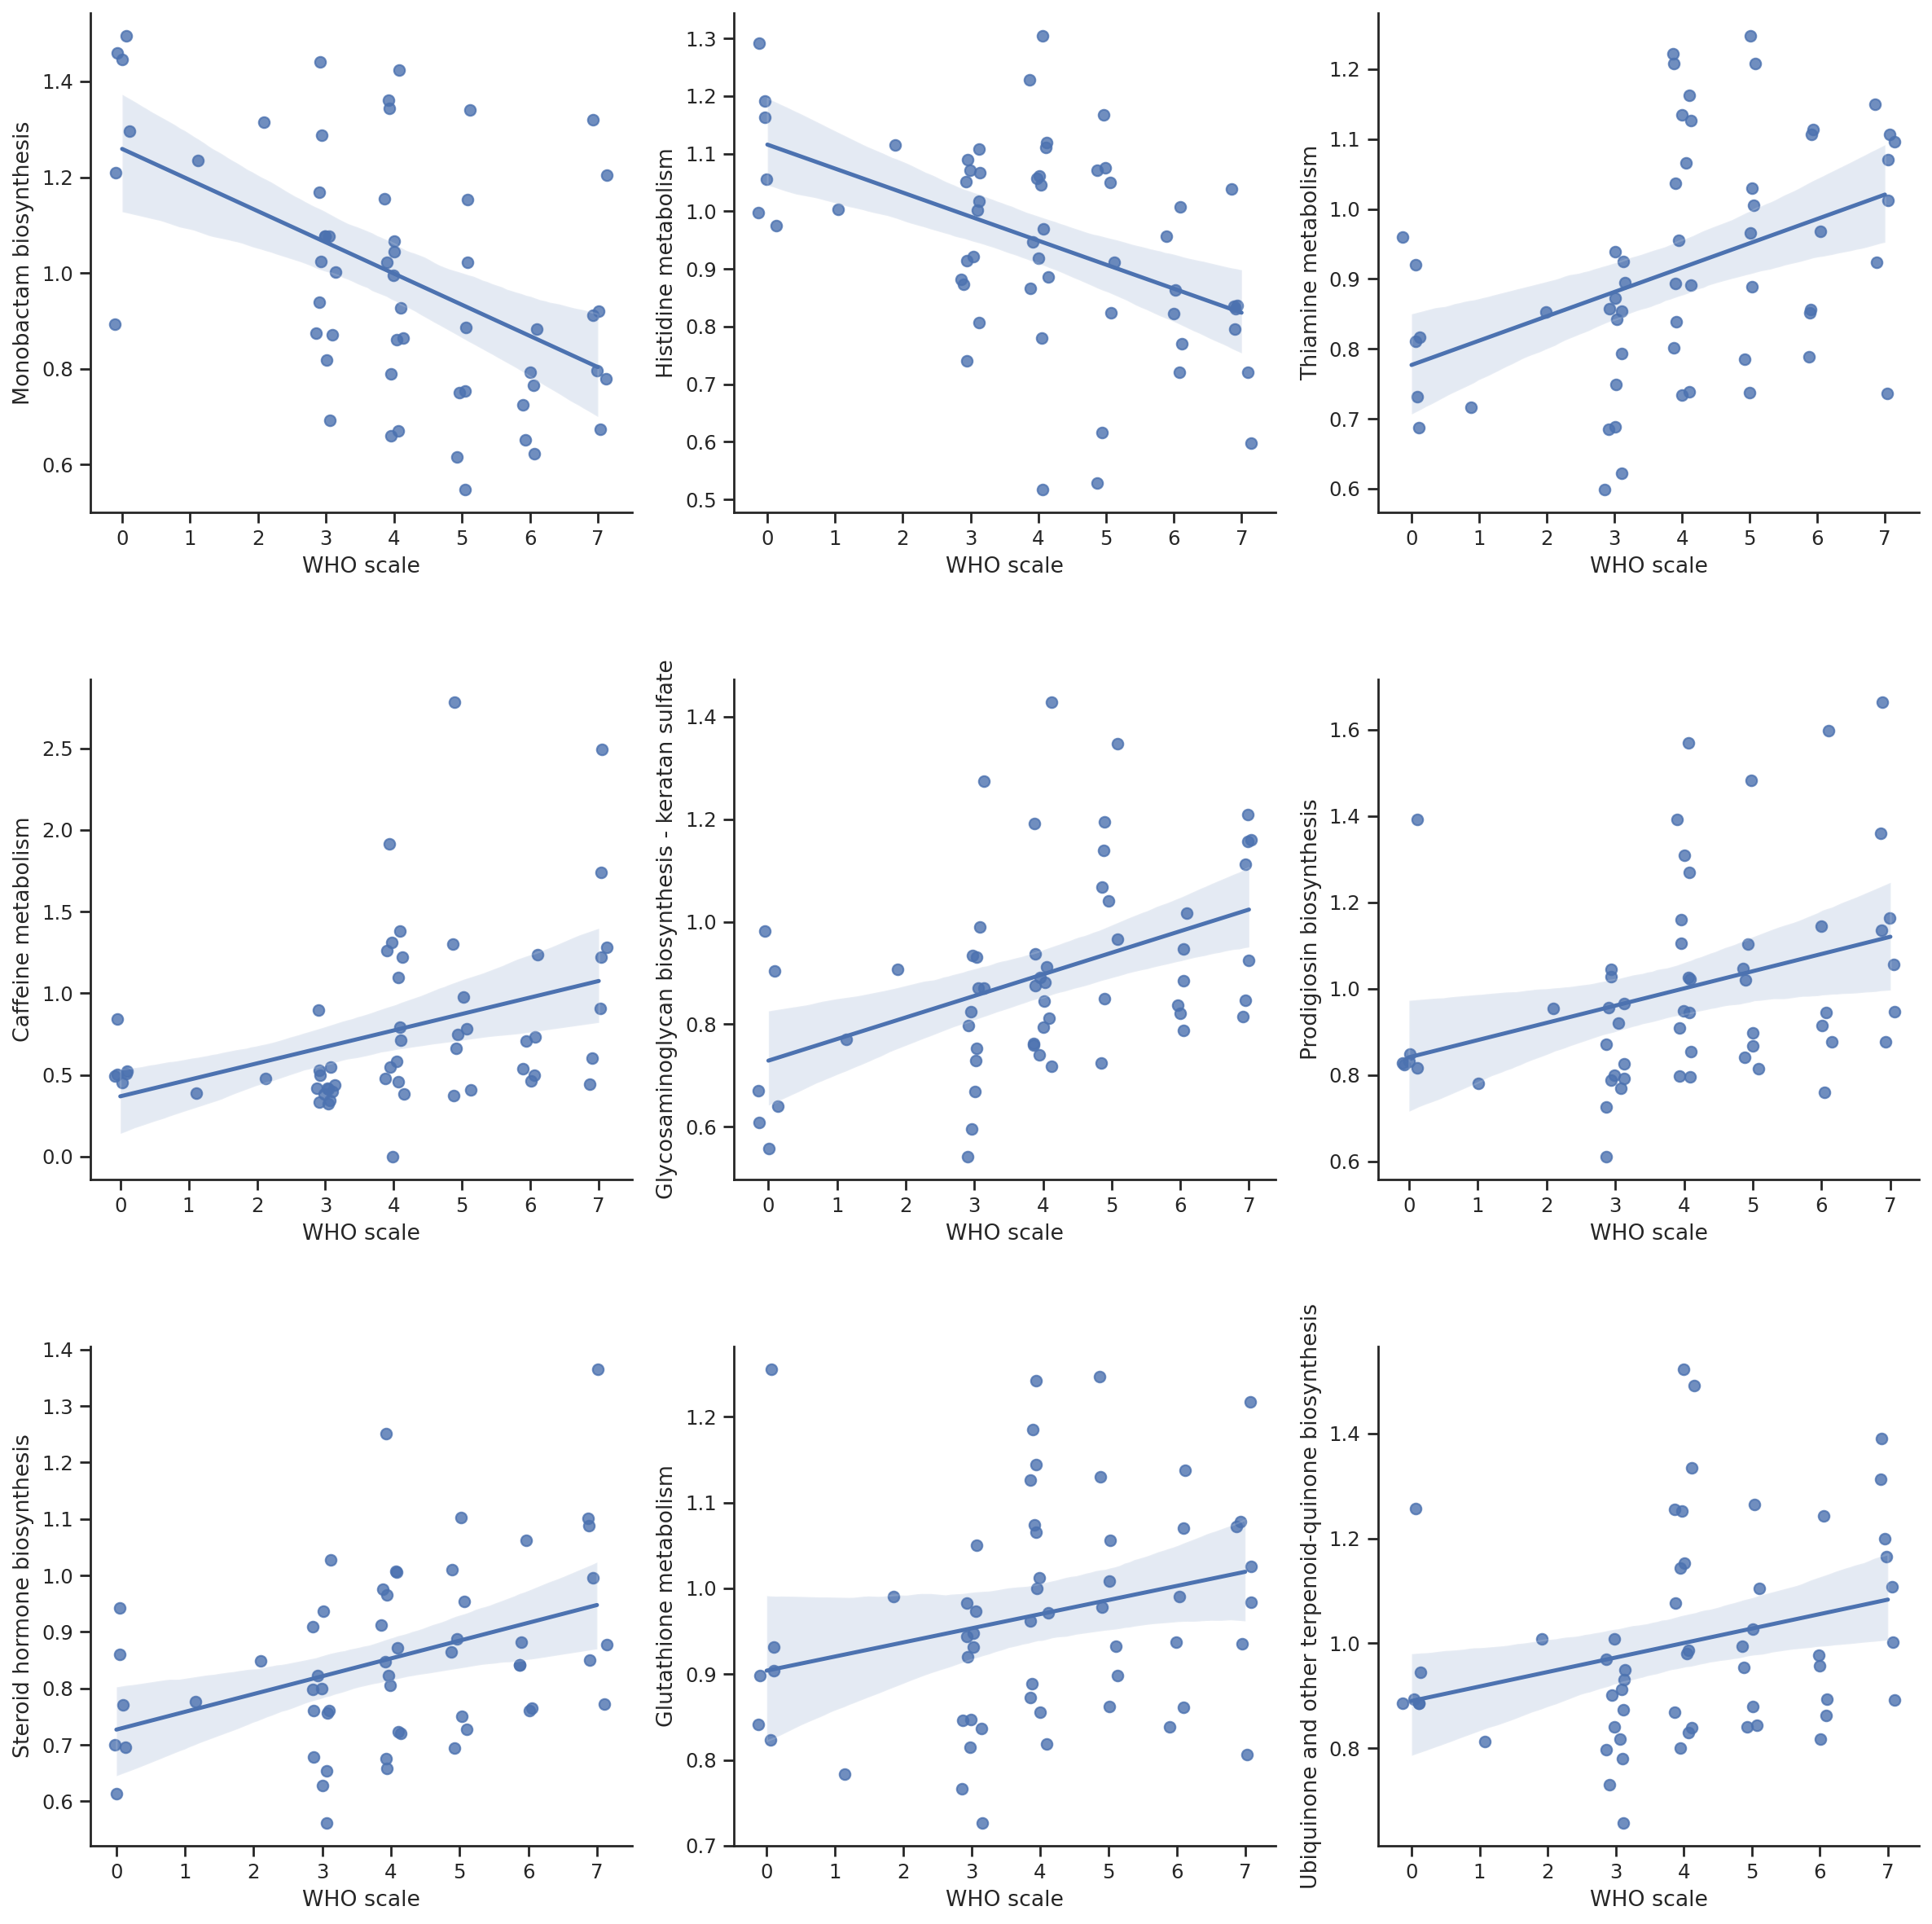

In [18]:
# Plot the top corresponding ones
sns.set_style('white')
sns.set_style('ticks')
f, axes = plt.subplots(3, 3, figsize=(15, 15), sharex=False, sharey=False)
sns.despine()

k = 0
x = adata_obs_by_patient.loc[patients_WHO, ['WHO_scale']]
for i in range(3):
    for j in range(3):
        f = sns.regplot(x=x, y=df_p.loc[sig_pathways.index[k]], x_jitter=0.15, ax=axes[i, j])
        f.set_ylabel(sig_pathways.index[k])
        f.set_xlabel('WHO scale')
        f.set_xticks(range(8))
        k += 1

plt.tight_layout()

#### Correlating pathway activity plotting functions

In [24]:
def plot_corresponding(df_all, sig_pathways, orig_adata, figsize=(15, 3), cmap='coolwarm'):
    # Plot the top corresponding ones
    df_p_corresponding = pd.DataFrame(df_all)
    df_p_corresponding.index = metab_genes.index
    patients = orig_adata.obs['patient'].unique().astype(str)
    patients.sort()
    df_p_corresponding.columns = patients

    df_p_corresponding = df_p_corresponding.reindex(columns=list(patients_WHO), fill_value=1)
    df_p_corresponding = df_p_corresponding.loc[sig_pathways.index, list(patients_WHO)]

    # When plotting, sort by metabolic pathway group first, then by spearman r
    df_p_corresponding['category'] = df_p_corresponding.index.map(classifications)
    df_p_corresponding['Spearman'] = sig_pathways['Spearman']
    df_p_corresponding = df_p_corresponding.sort_values(by=['category', 'Spearman'], ascending=[True, False])
    print(df_p_corresponding['category'])
    df_p_corresponding = df_p_corresponding.drop(columns=['category', 'Spearman'])

    ax = plt.figure(figsize=figsize)
    ax = sns.heatmap(df_p_corresponding, cmap=cmap, yticklabels=[], vmin=0,
                         norm=DivergingNorm(1.0))
    #ax.set_yticks([])
    ax.set_ylabel('')
    ax.set_xlabel('')
    
    return df_p_corresponding

def plot_spearman_dots(sig_pathways, df_corresponding, figsize=(5, 3)):
    # Dot plot for the significant ones
    sns.set_style('white')
    sns.set_style('ticks')
    fig = plt.figure(figsize=figsize)
    fig = sns.scatterplot(x=np.zeros(len(sig_pathways)), y=np.arange(0, len(sig_pathways), 1)[::-1], 
                          hue='Spearman', size='-log10(p)', hue_order=np.arange(0, 0.5, 0.1), 
                          sizes=(10, 40), data=sig_pathways.loc[df_corresponding.index])
    fig.legend(loc='right', bbox_to_anchor=(1.25, 0.5), ncol=1, fontsize=6)
    sns.despine()

0
Histidine metabolism                                                         Amino acid metabolism
Caffeine metabolism                                    Biosynthesis of other secondary metabolites
Prodigiosin biosynthesis                               Biosynthesis of other secondary metabolites
Monobactam biosynthesis                                Biosynthesis of other secondary metabolites
Butanoate metabolism                                                       Carbohydrate metabolism
Oxidative phosphorylation                                                        Energy metabolism
Sulfur metabolism                                                                Energy metabolism
Glycosaminoglycan biosynthesis - keratan sulfate                Glycan biosynthesis and metabolism
N-Glycan biosynthesis                                           Glycan biosynthesis and metabolism
Steroid hormone biosynthesis                                                      Lipid metabolism
Steroid 

<ipython-input-19-83e3f223a9cd>:21: MatplotlibDeprecationWarning: 
The DivergingNorm class was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use TwoSlopeNorm instead.
  norm=DivergingNorm(1.0))


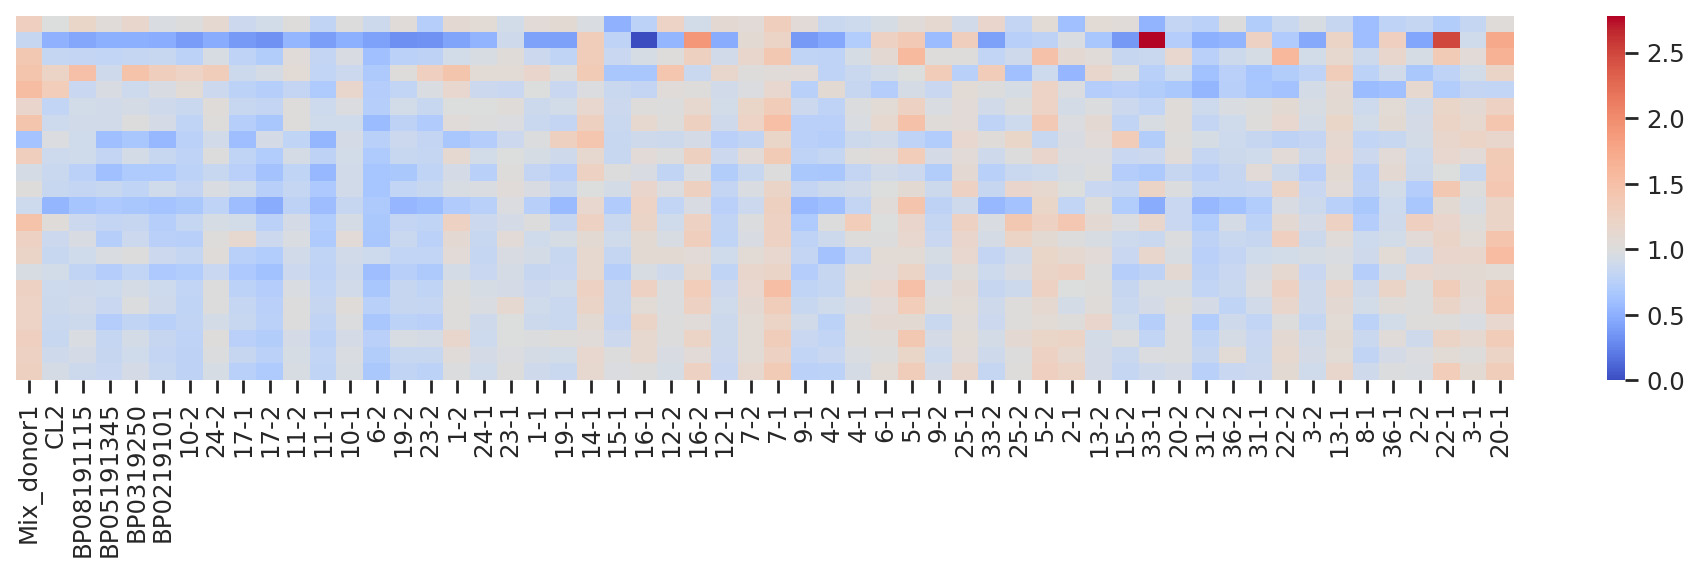

In [20]:
df_corresponding = plot_corresponding(p, sig_pathways, adata)

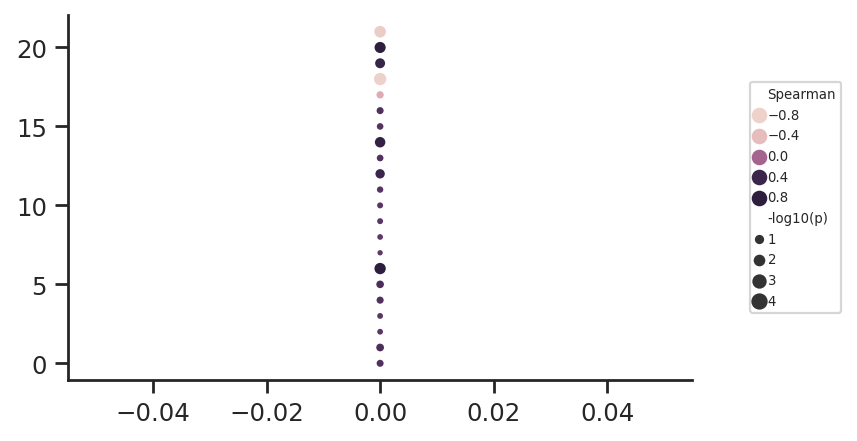

In [21]:
plot_spearman_dots(sig_pathways, df_corresponding)

#### Special inflammatory only (metabolic cluster 1)

In [14]:
# 0 seems to be a more moderate version of 1, found in overall clusters 0 and 1 in descending order of frequency
spec_prolif = ['1']
adata_spec_prolif = adata[adata.obs['louvain_metab'].isin(spec_prolif)].copy()
adata_metab_spec_prolif = adata_metab[adata.obs['louvain_metab'].isin(spec_prolif)].copy()
# Not using subpopulations here for now
p = pathway_activity(adata_spec_prolif, adata_metab_spec_prolif, 'patient', print_labels=True)

1-1
1-2
10-1
10-2
11-1
11-2
12-1
12-2
13-1
13-2
14-1
15-1
15-2
16-1
16-2
17-1
17-2
19-1
19-2
2-1
2-2
20-1
20-2
22-1
22-2
23-1
23-2
24-1
24-2
25-1
25-2
3-1
3-2
31-1
31-2
33-1
33-2
36-1
36-2
4-1
4-2
5-1
5-2
6-1
6-2
7-1
7-2
8-1
9-1
9-2
BP0219101
BP0319250
BP05191345
BP08191115
CL2
Mix_donor1


In [16]:
# Statistical significance of higher or lower pathway activity in a specific cell type
# Random permutation test
enriched = (p > 1)
decreased = (p < 1)

# Shuffle cell cluster labels 5000x

n = 1000
compares = np.zeros((len(p), len(p[0])))
for i in range(n):
    if i % 100 == 0:
        print(i)
    clusters_shuffled = np.random.permutation(adata_spec_prolif.obs['patient'])
    adata_spec_prolif.obs['patient_shuffled'] = clusters_shuffled
    adata_metab_spec_prolif.obs['patient_shuffled'] = clusters_shuffled
    
    # Compare new pathway activity scores to original dataset pathway activity scores
    p_shuffle = pathway_activity(adata_spec_prolif, adata_metab_spec_prolif, 'patient_shuffled')
    compares += enriched * (p_shuffle > p) + decreased * (p_shuffle < p)

compares /= n

# Non-significantly changed activity scores are reverted to 1 (no activity change)
significant = (compares < 0.01)
p_sig = p ** significant

# Save pathway activity scores
df_p = pd.DataFrame(p_sig)
df_p.to_csv(master_dir + 'output/pathway_activity/' + celltype + 
            '-metab-patient-cluster_1-pathway_activity.tabular', 
                       sep='\t', header=None, index=None)

0
100
200
300
400
500
600
700
800
900


In [22]:
df_p = pd.DataFrame(p)
df_p.index = metab_genes.index
patients = adata_spec_prolif.obs['patient'].unique().astype(str)
patients.sort()
df_p.columns = patients

# Plot in order of increasing WHO score
df_p = df_p.reindex(columns=list(patients_WHO)).dropna(axis=1)

spr_corr = df_p.apply(lambda col: spearmanr(col, adata_obs_by_patient.loc[patients_WHO, ['WHO_scale']])[0], 
                      axis=1)
spr_pvalues = df_p.apply(lambda col: spearmanr(col, adata_obs_by_patient.loc[patients_WHO, ['WHO_scale']])[1], 
                         axis=1)

sig_pathways = pd.DataFrame([spr_corr, spr_pvalues]).transpose()
sig_pathways = sig_pathways[sig_pathways.loc[:, 1]<0.05]
sig_pathways.columns = ['Spearman', 'p-value']
sig_pathways['Spearman_abs'] = abs(sig_pathways['Spearman'])
sig_pathways = sig_pathways.sort_values(by='Spearman_abs', ascending=False)
sig_pathways['-log10(p)'] = -np.log10(sig_pathways['p-value'])
pd.DataFrame(sig_pathways).to_csv(master_dir + 'output/pathway_activity/pathway_activity_trends/' + 
                                 celltype + '-metab_cluster_1' + '.csv')
sig_pathways

Spearman       p-value  \
0                                                                            
Tryptophan metabolism                              -0.623432  2.863942e-07   
Valine, leucine and isoleucine degradation         -0.602034  9.190689e-07   
Valine, leucine and isoleucine biosynthesis        -0.592083  1.536343e-06   
Drug metabolism - cytochrome P450                  -0.590274  1.683683e-06   
Monobactam biosynthesis                            -0.554054  9.425958e-06   
Neomycin, kanamycin and gentamicin biosynthesis    -0.552314  1.018773e-05   
Histidine metabolism                               -0.549078  1.175861e-05   
Pentose phosphate pathway                          -0.542189  1.587868e-05   
Pentose and glucuronate interconversions           -0.533873  2.262112e-05   
Aflatoxin biosynthesis                             -0.521417  3.778322e-05   
Propanoate metabolism                              -0.510214  5.893369e-05   
Selenocompound metabolism                          -0.504229  7.426024e-05   
Arachidonic acid metabolism                        -0.502698  7.872983e-05   
Glycosphingolipid biosynthesis - lacto and neol... -0.497862  9.452317e-05   
Other types of O-glycan biosynthesis               -0.493234  1.123063e-04   
Glyoxylate and dicarboxylate metabolism            -0.490312  1.250658e-04   
Metabolism of xenobiotics by cytochrome P450       -0.489198  1.302661e-04   
Butanoate metabolism                               -0.486902  1.416224e-04   
Other glycan degradation                           -0.485336  1.498770e-04   
alpha-Linolenic acid metabolism                    -0.474237  2.222221e-04   
Arginine and proline metabolism                    -0.474028  2.238458e-04   
Glycosaminoglycan biosynthesis - keratan sulfate    0.462894  3.278511e-04   
Inositol phosphate metabolism                      -0.460633  3.537166e-04   
Porphyrin and chlorophyll metabolism               -0.457327  3.948636e-04   
Alanine, aspartate and glutamate metabolism        -0.454961  4.269340e-04   
Sphingolipid metabolism                            -0.449047  5.177035e-04   
Ether lipid metabolism                             -0.445741  5.757212e-04   
Pyruvate metabolism                                -0.436243  7.766426e-04   
D-Glutamine and D-glutamate metabolism             -0.435825  7.867740e-04   
Glycerolipid metabolism                            -0.426570  1.044244e-03   
Glycine, serine and threonine metabolism           -0.426048  1.060798e-03   
Glycerophospholipid metabolism                     -0.415366  1.455716e-03   
Fructose and mannose metabolism                    -0.413557  1.534325e-03   
Retinol metabolism                                 -0.408164  1.791671e-03   
Pyrimidine metabolism                              -0.406564  1.875129e-03   
Lysine degradation                                 -0.404824  1.969764e-03   
Fatty acid elongation                              -0.399535  2.284159e-03   
Citrate cycle (TCA cycle)                          -0.385861  3.313371e-03   
Vitamin B6 metabolism                              -0.374623  4.447006e-03   
Tyrosine metabolism                                -0.371526  4.814076e-03   
beta-Alanine metabolism                            -0.363245  5.929627e-03   
Cysteine and methionine metabolism                 -0.361575  6.180218e-03   
Mannose type O-glycan biosynthesis                 -0.359627  6.484244e-03   
Taurine and hypotaurine metabolism                 -0.352251  7.756798e-03   
Glycosylphosphatidylinositol (GPI)-anchor biosy... -0.349676  8.249555e-03   
Ascorbate and aldarate metabolism                  -0.347762  8.633217e-03   
Arginine biosynthesis                              -0.346336  8.929213e-03   
Nicotinate and nicotinamide metabolism             -0.337429  1.098420e-02   
Phenylalanine metabolism                           -0.332731  1.222379e-02   
Caffeine metabolism                                 0.329078  1.326946e-02

0
Phenylalanine, tyrosine and tryptophan biosynthesis                                 Amino acid metabolism
Phenylalanine metabolism                                                            Amino acid metabolism
Arginine biosynthesis                                                               Amino acid metabolism
Cysteine and methionine metabolism                                                  Amino acid metabolism
Tyrosine metabolism                                                                 Amino acid metabolism
Lysine degradation                                                                  Amino acid metabolism
Glycine, serine and threonine metabolism                                            Amino acid metabolism
Alanine, aspartate and glutamate metabolism                                         Amino acid metabolism
Arginine and proline metabolism                                                     Amino acid metabolism
Histidine metabolism                        

<ipython-input-24-83e3f223a9cd>:21: MatplotlibDeprecationWarning: 
The DivergingNorm class was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use TwoSlopeNorm instead.
  norm=DivergingNorm(1.0))


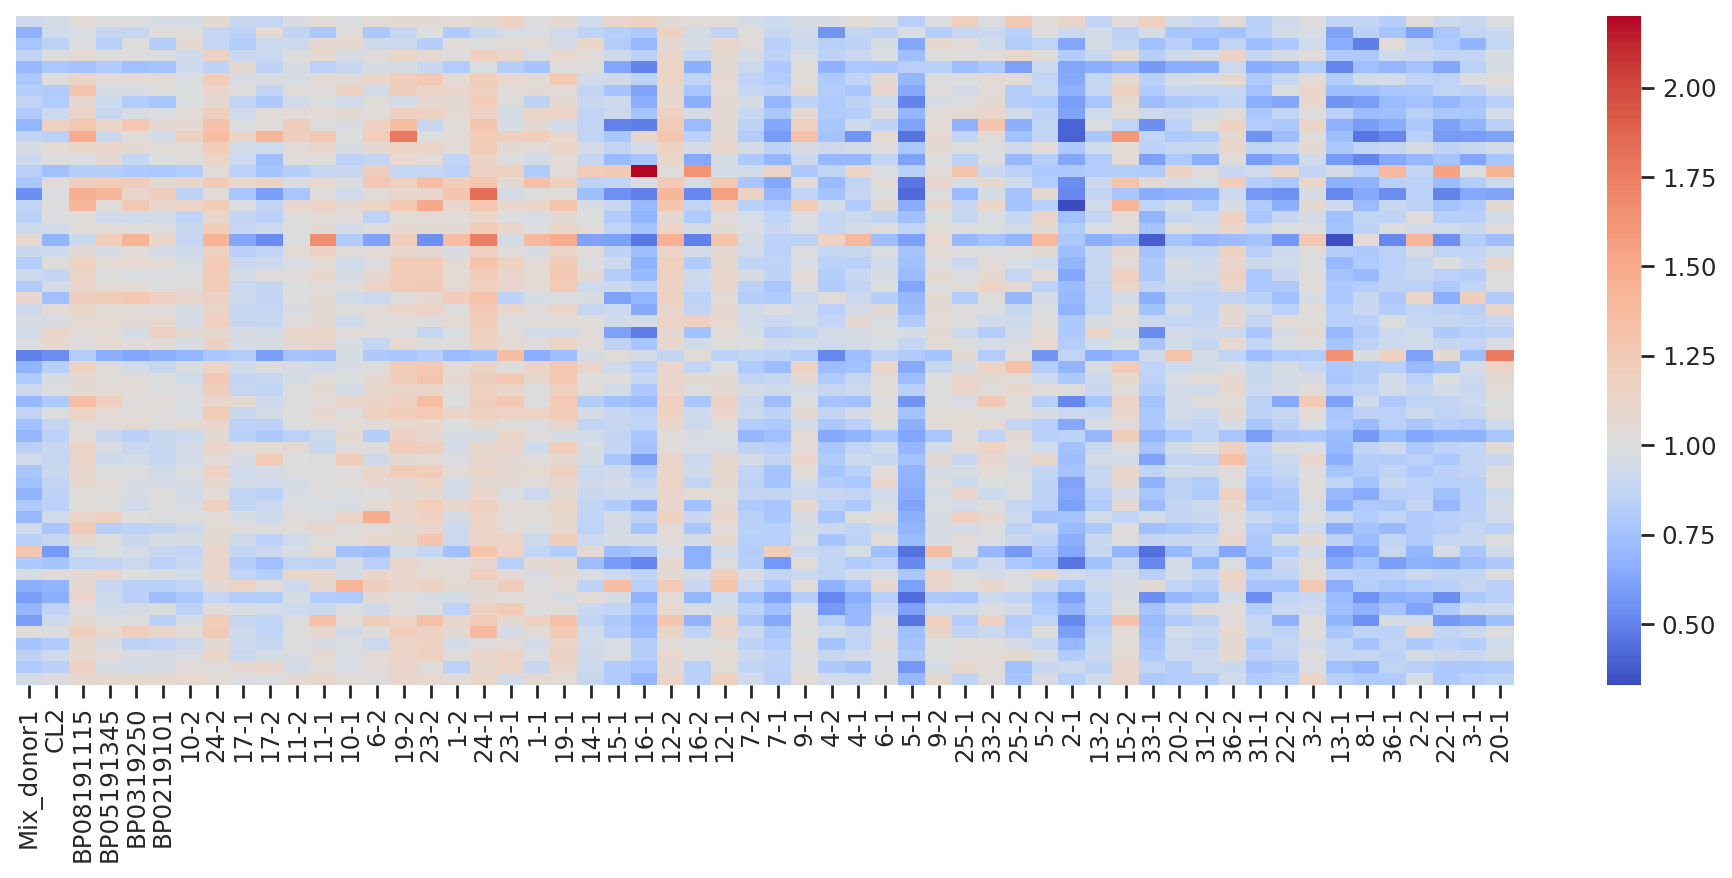

In [30]:
df_corresponding = plot_corresponding(p, sig_pathways, adata_spec_prolif, figsize=(15, 5.5))

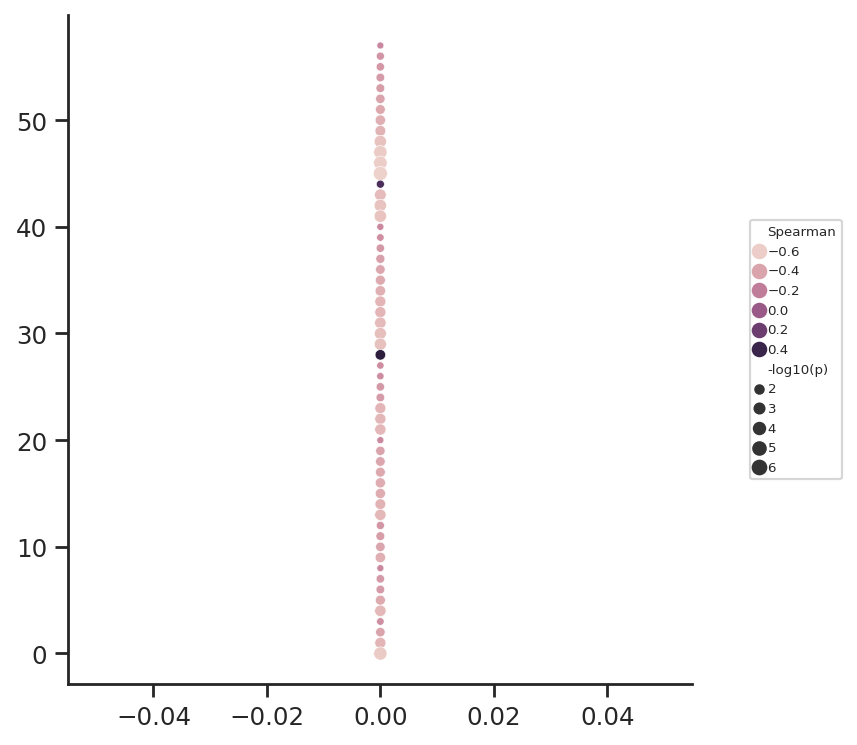

In [31]:
plot_spearman_dots(sig_pathways, df_corresponding, figsize=(5, 5.5))

#### Other classical inflammatory (metabolic cluster 0)

In [34]:
# 0 seems to be a more moderate version of 1, found in overall clusters 0 and 1 in descending order of frequency
other_prolif = ['0']
adata_other_prolif = adata[adata.obs['louvain_metab'].isin(other_prolif)].copy()
adata_metab_other_prolif = adata_metab[adata.obs['louvain_metab'].isin(other_prolif)].copy()
# Not using subpopulations here for now
p = pathway_activity(adata_other_prolif, adata_metab_other_prolif, 'patient', print_labels=True)

1-1
1-2
10-1
10-2
11-1
11-2
12-1
12-2
13-1
13-2
14-1
15-1
15-2
16-1
16-2
17-1
17-2
19-1
19-2
2-1
2-2
20-1
20-2
22-1
22-2
23-1
23-2
24-1
24-2
25-1
25-2
3-1
3-2
31-1
31-2
33-1
33-2
36-1
36-2
4-1
4-2
5-1
5-2
6-1
6-2
7-1
7-2
8-1
9-1
9-2
BP0219101
BP0319250
BP05191345
BP08191115
CL2
Mix_donor1


In [35]:
df_p = pd.DataFrame(p)
df_p.index = metab_genes.index
patients = adata_other_prolif.obs['patient'].unique().astype(str)
patients.sort()
df_p.columns = patients

# Plot in order of increasing WHO score
df_p = df_p.reindex(columns=list(patients_WHO)).dropna(axis=1)

spr_corr = df_p.apply(lambda col: spearmanr(col, adata_obs_by_patient.loc[patients_WHO, ['WHO_scale']])[0], 
                      axis=1)
spr_pvalues = df_p.apply(lambda col: spearmanr(col, adata_obs_by_patient.loc[patients_WHO, ['WHO_scale']])[1], 
                         axis=1)

sig_pathways = pd.DataFrame([spr_corr, spr_pvalues]).transpose()
sig_pathways = sig_pathways[sig_pathways.loc[:, 1]<0.05]
sig_pathways.columns = ['Spearman', 'p-value']
sig_pathways['Spearman_abs'] = abs(sig_pathways['Spearman'])
sig_pathways = sig_pathways.sort_values(by='Spearman_abs', ascending=False)
sig_pathways['-log10(p)'] = -np.log10(sig_pathways['p-value'])
pd.DataFrame(sig_pathways).to_csv(master_dir + 'output/pathway_activity/pathway_activity_trends/' + 
                                 celltype + '-metab_cluster_0' + '.csv')
sig_pathways

Spearman   p-value  \
0                                                                        
Thiamine metabolism                                 0.516894  0.000045   
Mucin type O-glycan biosynthesis                    0.473472  0.000228   
Caffeine metabolism                                 0.430815  0.000918   
Prodigiosin biosynthesis                            0.425074  0.001092   
Phenylalanine metabolism                            0.419159  0.001303   
Histidine metabolism                               -0.415332  0.001457   
Steroid hormone biosynthesis                        0.413731  0.001527   
Biosynthesis of ansamycins                          0.409208  0.001739   
Ubiquinone and other terpenoid-quinone biosynth...  0.397900  0.002390   
Steroid biosynthesis                                0.382834  0.003590   
Folate biosynthesis                                 0.376606  0.004225   
One carbon pool by folate                           0.375736  0.004321   
N-Glycan biosynthesis                               0.374553  0.004455   
Glycosphingolipid biosynthesis - ganglio series     0.371144  0.004861   
Glycosaminoglycan biosynthesis - chondroitin su...  0.364463  0.005753   
Drug metabolism - other enzymes                     0.354965  0.007265   
Aflatoxin biosynthesis                             -0.339203  0.010545   
Valine, leucine and isoleucine biosynthesis        -0.338368  0.010750   
Glutathione metabolism                              0.321145  0.015807   
Monobactam biosynthesis                            -0.313839  0.018501   
Arachidonic acid metabolism                        -0.312168  0.019169   
Oxidative phosphorylation                           0.309872  0.020120   
Biosynthesis of unsaturated fatty acids             0.308759  0.020596   
Sulfur metabolism                                   0.307054  0.021343   
Butanoate metabolism                               -0.303714  0.022872   
alpha-Linolenic acid metabolism                     0.293797  0.027967   
Lipoic acid metabolism                             -0.291884  0.029053   
Tyrosine metabolism                                 0.286595  0.032237   
Arginine biosynthesis                               0.270729  0.043579   
Pentose and glucuronate interconversions           -0.266519  0.047085   

                                                    Spearman_abs  -log10(p)  
0                                                                            
Thiamine metabolism                                     0.516894   4.343939  
Mucin type O-glycan biosynthesis                        0.473472   3.641630  
Caffeine metabolism                                     0.430815   3.037159  
Prodigiosin biosynthesis                                0.425074   2.961645  
Phenylalanine metabolism                                0.419159   2.885212  
Histidine metabolism                                    0.415332   2.836483  
Steroid hormone biosynthesis                            0.413731   2.816273  
Biosynthesis of ansamycins                              0.409208   2.759689  
Ubiquinone and other terpenoid-quinone biosynth...      0.397900   2.621597  
Steroid biosynthesis                                    0.382834   2.444873  
Folate biosynthesis                                     0.376606   2.374166  
One carbon pool by folate                               0.375736   2.364398  
N-Glycan biosynthesis                                   0.374553   2.351155  
Glycosphingolipid biosynthesis - ganglio series         0.371144   2.313252  
Glycosaminoglycan biosynthesis - chondroitin su...      0.364463   2.240139  
Drug metabolism - other enzymes                         0.354965   2.138744  
Aflatoxin biosynthesis                                  0.339203   1.976953  
Valine, leucine and isoleucine biosynthesis             0.338368   1.968601  
Glutathione metabolism                                  0.321145   1.801140  
Monobactam biosynthesis                      

0
Phenylalanine metabolism                                                                         Amino acid metabolism
Tyrosine metabolism                                                                              Amino acid metabolism
Arginine biosynthesis                                                                            Amino acid metabolism
Valine, leucine and isoleucine biosynthesis                                                      Amino acid metabolism
Histidine metabolism                                                                             Amino acid metabolism
Caffeine metabolism                                                        Biosynthesis of other secondary metabolites
Prodigiosin biosynthesis                                                   Biosynthesis of other secondary metabolites
Monobactam biosynthesis                                                    Biosynthesis of other secondary metabolites
Aflatoxin biosynthesis                        

<ipython-input-24-83e3f223a9cd>:21: MatplotlibDeprecationWarning: 
The DivergingNorm class was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use TwoSlopeNorm instead.
  norm=DivergingNorm(1.0))


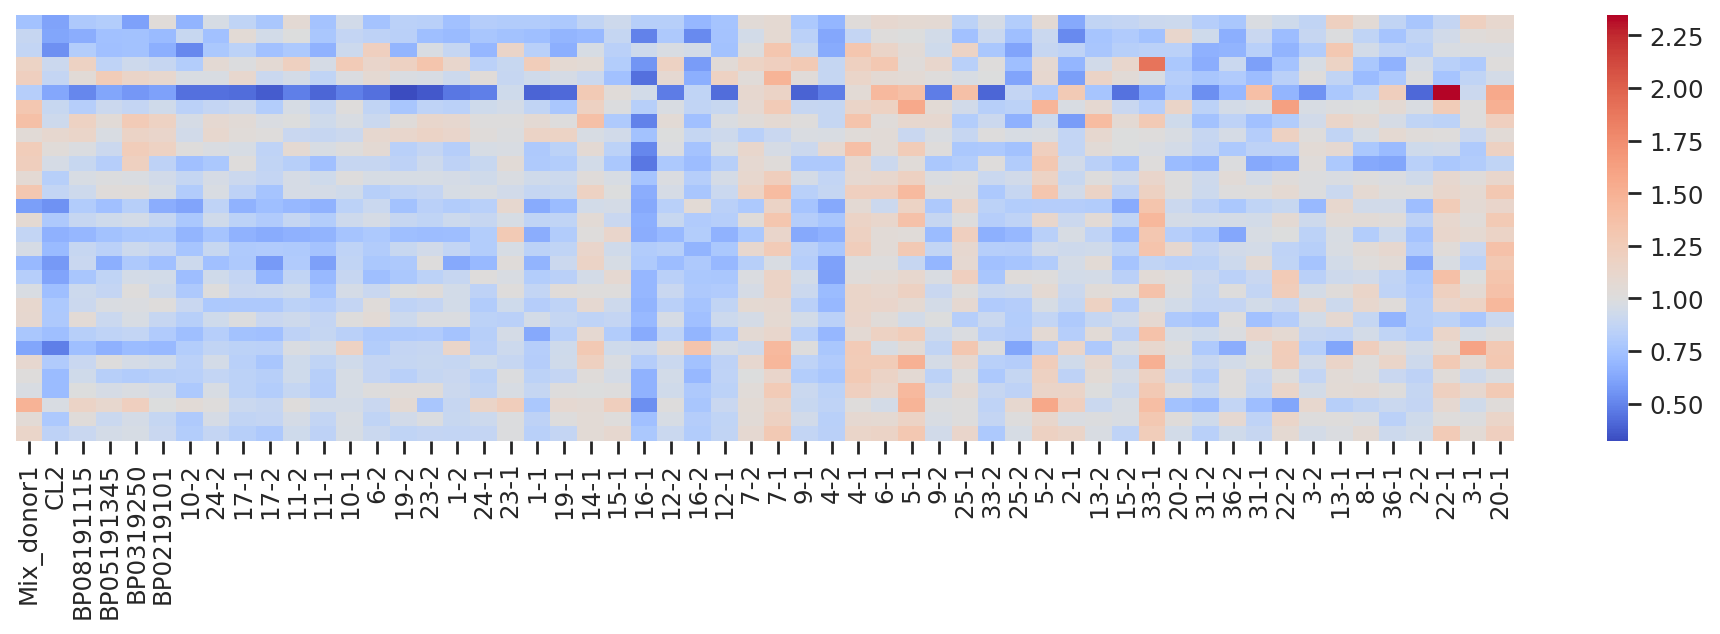

In [38]:
df_corresponding = plot_corresponding(p, sig_pathways, adata_spec_prolif, figsize=(15, 3.5))

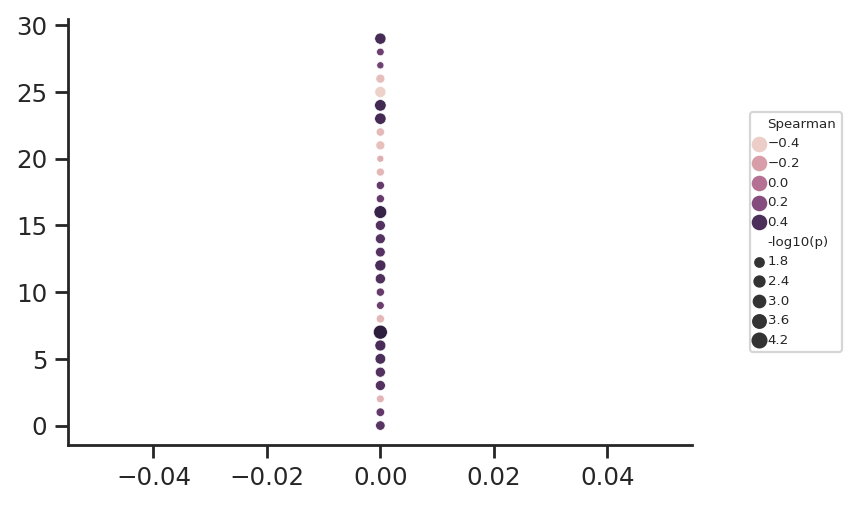

In [39]:
plot_spearman_dots(sig_pathways, df_corresponding, figsize=(5, 3.5))

#### Inflammatory only (metabolic clusters 0, 1)

In [24]:
# 0 seems to be a more moderate version of 1, found in overall clusters 0 and 1 in descending order of frequency
prolif = ['0', '1']
adata_prolif = adata[adata.obs['louvain_metab'].isin(prolif)].copy()
adata_metab_prolif = adata_metab[adata.obs['louvain_metab'].isin(prolif)].copy()
# Not using subpopulations here for now
p = pathway_activity(adata_prolif, adata_metab_prolif, 'patient', print_labels=True)

/usr/lusers/jlee712/anaconda3/lib/python3.8/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):


1-1
1-2
10-1
10-2
11-1
11-2
12-1
12-2
13-1
13-2
14-1
15-1
15-2
16-1
16-2
17-1
17-2
19-1
19-2
2-1
2-2
20-1
20-2
22-1
22-2
23-1
23-2
24-1
24-2
25-1
25-2
3-1
3-2
31-1
31-2
33-1
33-2
36-1
36-2
4-1
4-2
5-1
5-2
6-1
6-2
7-1
7-2
8-1
9-1
9-2
BP0219101
BP0319250
BP05191345
BP08191115
CL2
Mix_donor1


In [ ]:
df_p = pd.DataFrame(p)
df_p.index = metab_genes.index
patients = adata_prolif.obs['patient'].unique().astype(str)
patients.sort()
df_p.columns = patients

# Plot in order of increasing WHO score
#patients_WHO = adata_prolif.obs.sort_values(by='WHO_scale', axis=0)['patient'].unique()
#patients_ICU = adata.obs.sort_values(by='ICU_status', axis=0)['patient'].unique()
#patients_age = adata.obs.sort_values(by='Age_at_baseline', axis=0)['patient'].unique()
#patients_days = adata.obs.sort_values(by='Days_since_onset_of_symptoms', axis=0)['patient'].unique()
df_p = df_p.reindex(columns=patients_WHO, fill_value=1)
df_p = df_p.loc[:, patients_WHO]

ax = plt.figure(figsize=(20, 10))
ax = sns.heatmap(df_p, cmap='coolwarm', yticklabels=metab_genes.index, vmin=0,
                     norm=DivergingNorm(1.0))
ax.set_yticks([])
ax.set_ylabel('')
ax.set_xlabel('')

In [ ]:
# Statistical significance of higher or lower pathway activity in a specific cell type
# Random permutation test
enriched = (p > 1)
decreased = (p < 1)

# Shuffle cell cluster labels 5000x

n = 5000
compares = np.zeros((len(p), len(p[0])))
for i in range(n):
    if i % 100 == 0:
        print(i)
    clusters_shuffled = np.random.permutation(adata_effectors.obs['patient'])
    adata_effectors.obs['patient_shuffled'] = clusters_shuffled
    adata_metab_effectors.obs['patient_shuffled'] = clusters_shuffled
    
    # Compare new pathway activity scores to original dataset pathway activity scores
    p_shuffle = pathway_activity(adata_effectors, adata_metab_effectors, 'patient_shuffled')
    compares += enriched * (p_shuffle > p) + decreased * (p_shuffle < p)

compares /= n

# Non-significantly changed activity scores are reverted to 1 (no activity change)
significant = (compares < 0.01)
p_sig = p ** significant

# Save pathway activity scores
df_p = pd.DataFrame(p_sig)
df_p.to_csv(master_dir + 'output/pathway_activity/' + celltype + 
            '-metab-patient-cluster_0_2_8-pathway_activity.tabular', 
                       sep='\t', header=None, index=None)

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000


In [25]:
df_p = pd.DataFrame(p_sig)
df_p.index = metab_genes.index
patients = adata.obs['patient'].unique().astype(str)
patients.sort()
df_p.columns = patients

# Plot in order of increasing WHO score
patients_WHO = adata.obs.sort_values(by='WHO_scale', axis=0)['patient'].unique()
#patients_ICU = adata.obs.sort_values(by='ICU_status', axis=0)['patient'].unique()
#patients_age = adata.obs.sort_values(by='Age_at_baseline', axis=0)['patient'].unique()
#patients_days = adata.obs.sort_values(by='Days_since_onset_of_symptoms', axis=0)['patient'].unique()
df_p = df_p.reindex(columns=patients_WHO, fill_value=1)
df_p = df_p.loc[:, patients_WHO]

ax = plt.figure(figsize=(20, 10))
ax = sns.heatmap(df_p, cmap='bwr', yticklabels=metab_genes.index, vmin=0,
                     norm=DivergingNorm(1.0))
ax.set_yticks([])
ax.set_ylabel('')
ax.set_xlabel('')

NameError: name 'p_sig' is not defined

In [26]:
df_p = pd.DataFrame(p)
df_p.index = metab_genes.index
patients = adata_prolif.obs['patient'].unique().astype(str)
patients.sort()
df_p.columns = patients

# Plot in order of increasing WHO score
#patients_WHO = adata_prolif.obs.sort_values(by='WHO_scale', axis=0)['patient'].unique()
#patients_ICU = adata.obs.sort_values(by='ICU_status', axis=0)['patient'].unique()
#patients_age = adata.obs.sort_values(by='Age_at_baseline', axis=0)['patient'].unique()
#patients_days = adata.obs.sort_values(by='Days_since_onset_of_symptoms', axis=0)['patient'].unique()
df_p = df_p.reindex(columns=list(patients_WHO)).dropna(axis=1)

spr_corr = df_p.apply(lambda col: spearmanr(col, adata_obs_by_patient.loc[patients_WHO, ['WHO_scale']])[0], 
                      axis=1)
spr_pvalues = df_p.apply(lambda col: spearmanr(col, adata_obs_by_patient.loc[patients_WHO, ['WHO_scale']])[1], 
                         axis=1)

sig_pathways = pd.DataFrame([spr_corr, spr_pvalues]).transpose()
sig_pathways = sig_pathways[sig_pathways.loc[:, 1]<0.05]
sig_pathways.columns = ['Spearman', 'p-value']
sig_pathways['Spearman_abs'] = abs(sig_pathways['Spearman'])
sig_pathways = sig_pathways.sort_values(by='Spearman_abs', ascending=False)
sig_pathways['-log10(p)'] = -np.log10(sig_pathways['p-value'])
pd.DataFrame(sig_pathways).to_csv(master_dir + 'output/pathway_activity/pathway_activity_trends/' + 
                                 celltype + '-metab_cluster_0_1' + '.csv')
sig_pathways

Spearman   p-value  \
0                                                                      
Caffeine metabolism                               0.413801  0.001524   
Steroid hormone biosynthesis                      0.408408  0.001779   
Histidine metabolism                             -0.391811  0.002824   
Glycosaminoglycan biosynthesis - keratan sulfate  0.357400  0.006848   
Thiamine metabolism                               0.355591  0.007156   
Mucin type O-glycan biosynthesis                  0.334993  0.011613   
One carbon pool by folate                         0.307367  0.021204   
Terpenoid backbone biosynthesis                   0.284821  0.033369   
Prodigiosin biosynthesis                          0.278941  0.037357   
Synthesis and degradation of ketone bodies        0.274209  0.040846   
Folate biosynthesis                               0.271112  0.043271   
N-Glycan biosynthesis                             0.270346  0.043889   

                                                  Spearman_abs  -log10(p)  
0                                                                          
Caffeine metabolism                                   0.413801   2.817150  
Steroid hormone biosynthesis                          0.408408   2.749759  
Histidine metabolism                                  0.391811   2.549191  
Glycosaminoglycan biosynthesis - keratan sulfate      0.357400   2.164459  
Thiamine metabolism                                   0.355591   2.145338  
Mucin type O-glycan biosynthesis                      0.334993   1.935067  
One carbon pool by folate                             0.307367   1.673588  
Terpenoid backbone biosynthesis                       0.284821   1.476656  
Prodigiosin biosynthesis                              0.278941   1.427625  
Synthesis and degradation of ketone bodies            0.274209   1.388850  
Folate biosynthesis                                   0.271112   1.363801  
N-Glycan biosynthesis                                 0.270346   1.357648

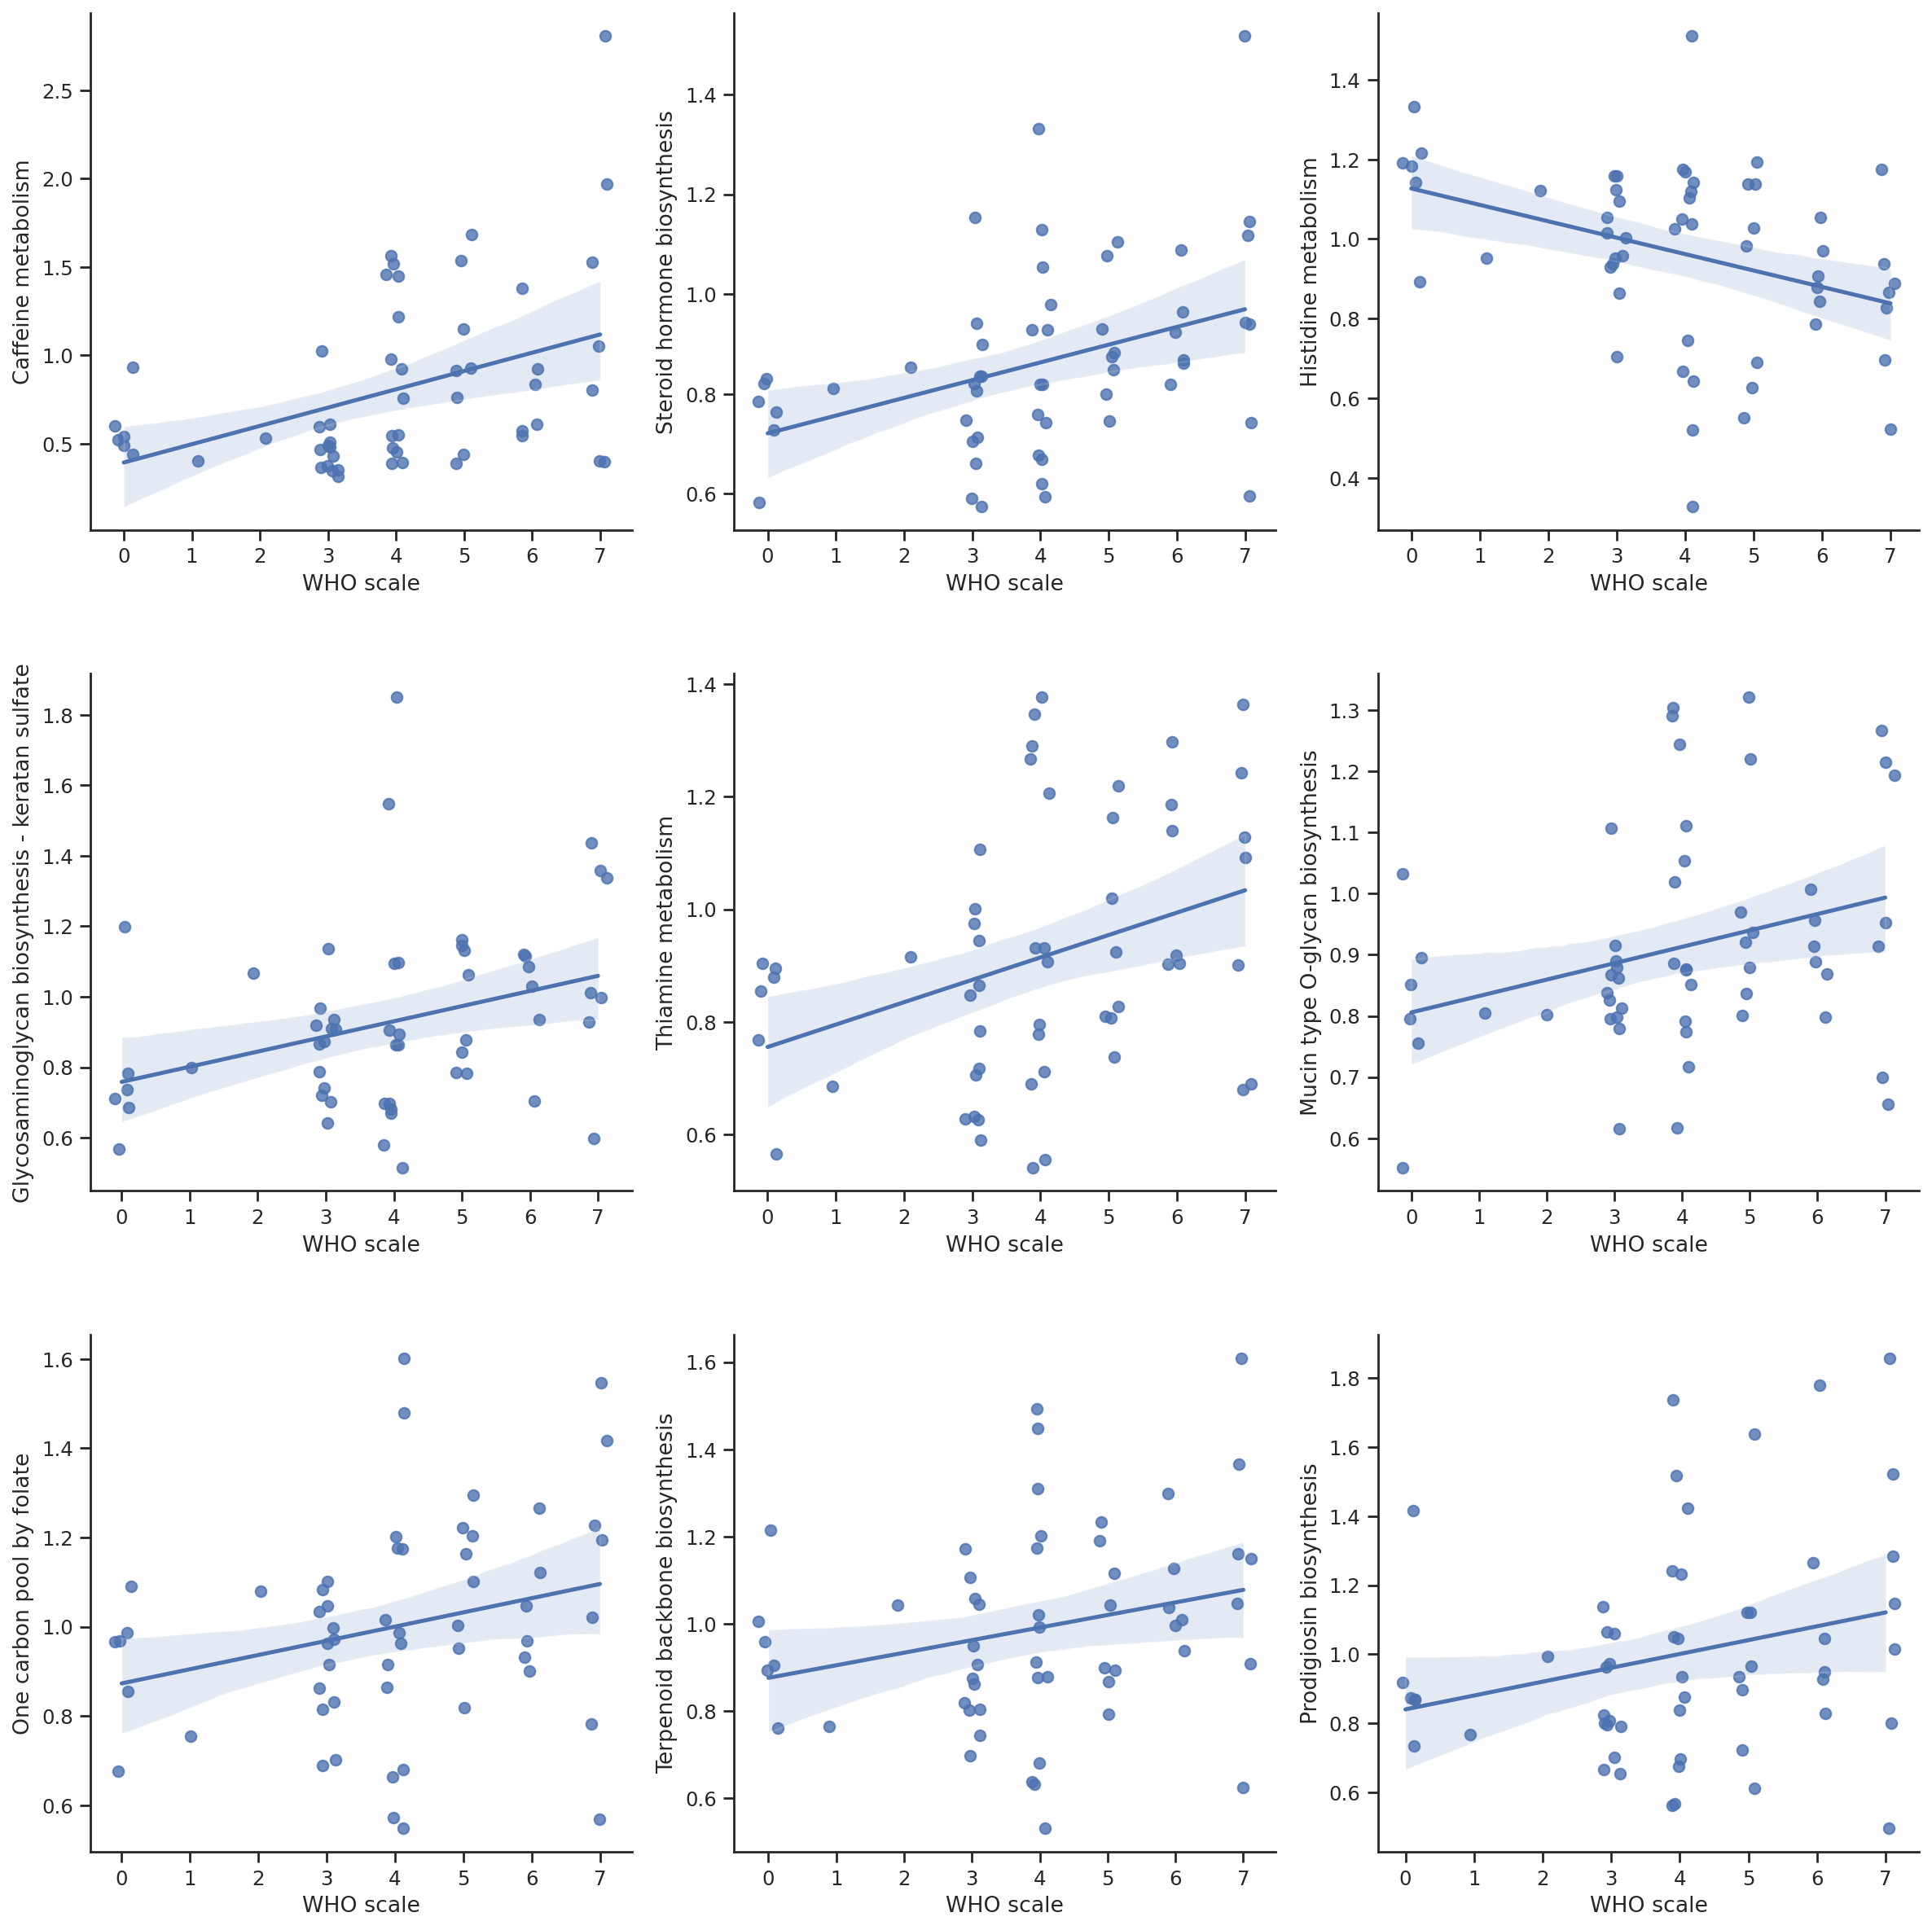

In [27]:
# Plot the top corresponding ones
sns.set_style('white')
sns.set_style('ticks')
f, axes = plt.subplots(3, 3, figsize=(15, 15), sharex=False, sharey=False)
sns.despine()

k = 0
x = adata_obs_by_patient.loc[df_p.columns, ['WHO_scale']]
for i in range(3):
    for j in range(3):
        f = sns.regplot(x=x, y=df_p.loc[sig_pathways.index[k]], x_jitter=0.15, ax=axes[i, j])
        f.set_ylabel(sig_pathways.index[k])
        f.set_xlabel('WHO scale')
        f.set_xticks(range(8))
        k += 1

plt.tight_layout()

0
Histidine metabolism                                                      Amino acid metabolism
Caffeine metabolism                                 Biosynthesis of other secondary metabolites
Prodigiosin biosynthesis                            Biosynthesis of other secondary metabolites
Glycosaminoglycan biosynthesis - keratan sulfate             Glycan biosynthesis and metabolism
Mucin type O-glycan biosynthesis                             Glycan biosynthesis and metabolism
N-Glycan biosynthesis                                        Glycan biosynthesis and metabolism
Steroid hormone biosynthesis                                                   Lipid metabolism
Synthesis and degradation of ketone bodies                                     Lipid metabolism
Thiamine metabolism                                        Metabolism of cofactors and vitamins
One carbon pool by folate                                  Metabolism of cofactors and vitamins
Terpenoid backbone biosynthesis       

<ipython-input-19-83e3f223a9cd>:21: MatplotlibDeprecationWarning: 
The DivergingNorm class was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use TwoSlopeNorm instead.
  norm=DivergingNorm(1.0))


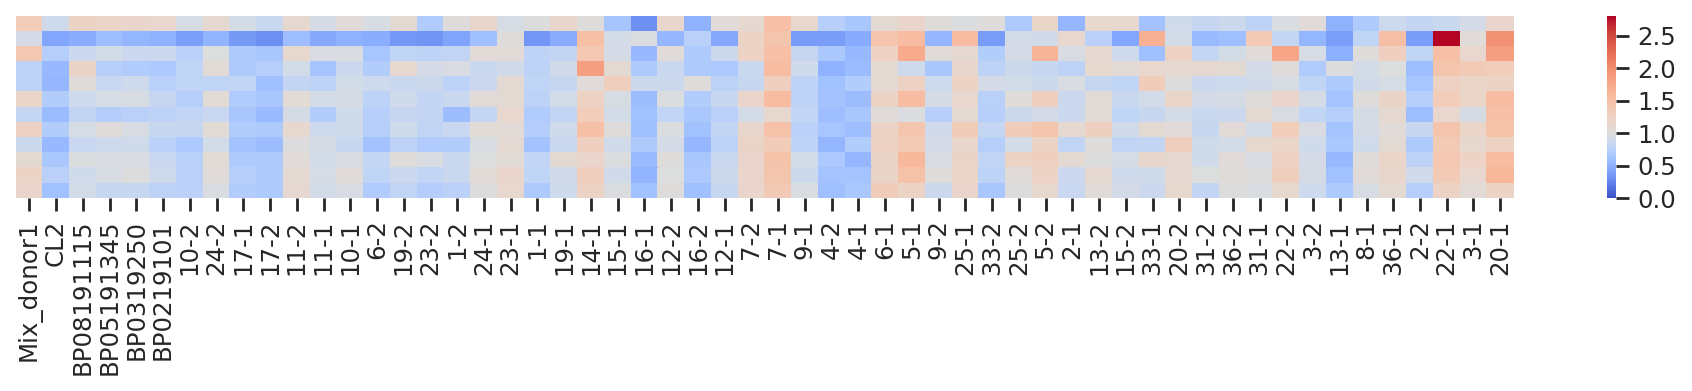

In [28]:
df_corresponding = plot_corresponding(p, sig_pathways, adata_prolif, figsize=(15, 1.5))

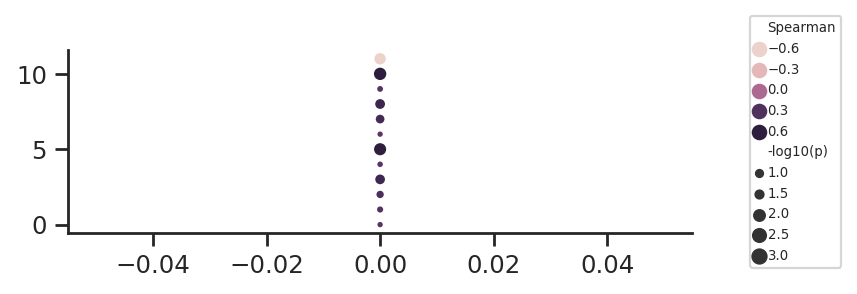

In [29]:
plot_spearman_dots(sig_pathways, df_corresponding, figsize=(5, 1.5))

#### Antiinflammatory only (METABOLIC cluster 2 is unique to antiinflammatory)

In [31]:
mem_metab = ['2']
adata_mem_metab = adata[adata.obs['louvain_metab'].isin(mem_metab)].copy()
adata_metab_mem_metab = adata_metab[adata.obs['louvain_metab'].isin(mem_metab)].copy()
# Not using subpopulations here for now
p = pathway_activity(adata_mem_metab, adata_metab_mem_metab, 'patient', print_labels=True)

/usr/lusers/jlee712/anaconda3/lib/python3.8/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):


1-1
1-2
10-1
10-2
11-1
11-2
12-1
12-2
13-1
13-2
14-1
15-1
15-2
16-2
17-1
17-2
19-1
19-2
2-1
2-2
20-1
20-2
22-2
23-1
23-2
24-1
24-2
25-1
25-2
3-1
3-2
31-1
31-2
33-2
36-1
36-2
4-1
4-2
5-1
5-2
6-1
6-2
7-1
7-2
8-1
9-1
9-2
BP0219101
BP0319250
BP05191345
BP08191115
CL2
Mix_donor1


In [ ]:
# Statistical significance of higher or lower pathway activity in a specific cell type
# Random permutation test
enriched = (p > 1)
decreased = (p < 1)

# Shuffle cell cluster labels 5000x

n = 5000
compares = np.zeros((len(p), len(p[0])))
for i in range(n):
    if i % 100 == 0:
        print(i)
    clusters_shuffled = np.random.permutation(adata_mem.obs['patient'])
    adata_mem.obs['patient_shuffled'] = clusters_shuffled
    adata_metab_mem.obs['patient_shuffled'] = clusters_shuffled
    
    # Compare new pathway activity scores to original dataset pathway activity scores
    p_shuffle = pathway_activity(adata_mem, adata_metab_mem, 'patient_shuffled')
    compares += enriched * (p_shuffle > p) + decreased * (p_shuffle < p)

compares /= n

# Non-significantly changed activity scores are reverted to 1 (no activity change)
significant = (compares < 0.01)
p_sig = p ** significant

# Save pathway activity scores
df_p = pd.DataFrame(p_sig)
df_p.to_csv(master_dir + 'output/pathway_activity/' + celltype + 
            '-metab-patient-cluster_3_6-pathway_activity.tabular', 
                       sep='\t', header=None, index=None)

In [48]:
df_p = pd.DataFrame(p_sig)
df_p.index = metab_genes.index
patients = adata.obs['patient'].unique().astype(str)
patients.sort()
df_p.columns = patients

# Plot in order of increasing WHO score
#patients_WHO = adata.obs.sort_values(by='WHO_scale', axis=0)['patient'].unique()
#patients_ICU = adata.obs.sort_values(by='ICU_status', axis=0)['patient'].unique()
#patients_age = adata.obs.sort_values(by='Age_at_baseline', axis=0)['patient'].unique()
#patients_days = adata.obs.sort_values(by='Days_since_onset_of_symptoms', axis=0)['patient'].unique()
df_p = df_p.loc[:, patients_WHO]

ax = plt.figure(figsize=(20, 25))
ax = sns.heatmap(df_p, cmap='bwr', yticklabels=metab_genes.index, vmin=0,
                     norm=DivergingNorm(1.0))

NameError: name 'p_sig' is not defined

<ipython-input-32-59a142d42f38>:17: MatplotlibDeprecationWarning: 
The DivergingNorm class was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use TwoSlopeNorm instead.
  norm=DivergingNorm(1.0))


Text(0.5, 92.00000000000001, '')

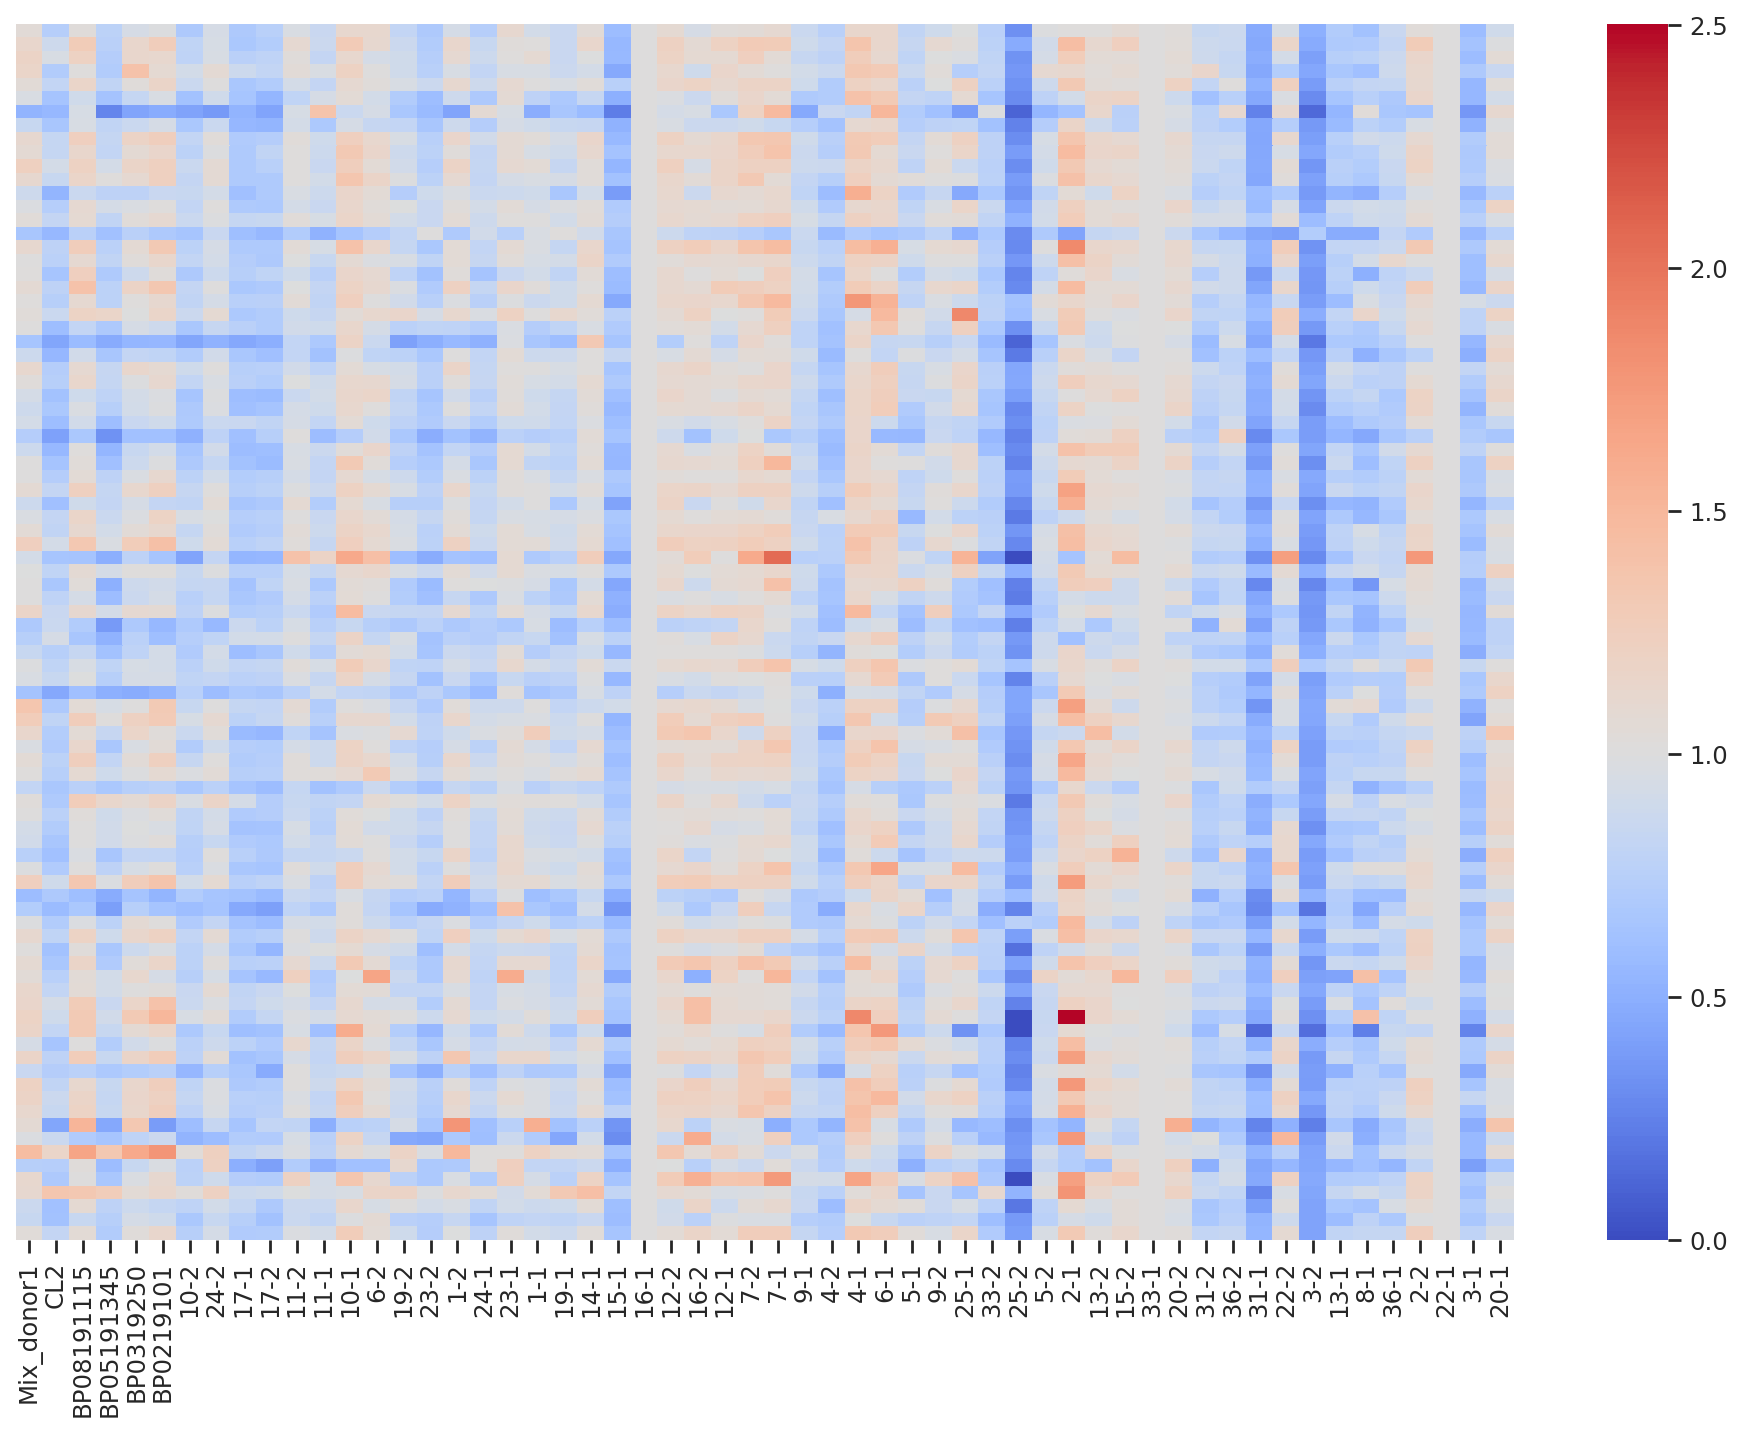

In [32]:
df_p = pd.DataFrame(p)
df_p.index = metab_genes.index
patients = adata_mem_metab.obs['patient'].unique().astype(str)
patients.sort()
df_p.columns = patients

# Plot in order of increasing WHO score
#patients_WHO = adata_mem_metab.obs.sort_values(by='WHO_scale', axis=0)['patient'].unique()
#patients_ICU = adata.obs.sort_values(by='ICU_status', axis=0)['patient'].unique()
#patients_age = adata.obs.sort_values(by='Age_at_baseline', axis=0)['patient'].unique()
#patients_days = adata.obs.sort_values(by='Days_since_onset_of_symptoms', axis=0)['patient'].unique()
df_p = df_p.reindex(columns=patients_WHO, fill_value=1)
df_p = df_p.loc[:, patients_WHO]

ax = plt.figure(figsize=(15, 10))
ax = sns.heatmap(df_p, cmap='coolwarm', yticklabels=[], vmin=0,
                     norm=DivergingNorm(1.0))
ax.set_yticks([])
ax.set_ylabel('')
ax.set_xlabel('')

In [33]:
df_p = pd.DataFrame(p)
df_p.index = metab_genes.index
patients = adata_mem_metab.obs['patient'].unique().astype(str)
patients.sort()
df_p.columns = patients

# Other patient attributes
adata_obs_by_patient = adata.obs.copy()
adata_obs_by_patient.index = adata_obs_by_patient['patient']
#adata_obs_by_patient.groupby(by='patient').first()
adata_obs_by_patient = adata_obs_by_patient.reset_index(drop=True)
adata_obs_by_patient = adata_obs_by_patient.groupby(by='patient').first() # All characteristics except clustering should be the same
adata_obs_by_patient['WHO_scale'] = adata_obs_by_patient['WHO_scale'].astype(int)
adata_obs_by_patient['Age_at_baseline'] = adata_obs_by_patient['Age_at_baseline'].str.replace('Not Recorded', 
                                                                                              '0').astype(int)
adata_obs_by_patient['Age_at_baseline'] = adata_obs_by_patient['Age_at_baseline'].astype(int)

# Plot in order of increasing WHO score
#patients_WHO = adata_mem_metab.obs.sort_values(by='WHO_scale', axis=0)['patient'].unique()
#patients_ICU = adata.obs.sort_values(by='ICU_status', axis=0)['patient'].unique()
#patients_age = adata.obs.sort_values(by='Age_at_baseline', axis=0)['patient'].unique()
#patients_days = adata.obs.sort_values(by='Days_since_onset_of_symptoms', axis=0)['patient'].unique()
df_p = df_p.reindex(columns=list(patients_WHO)).dropna(axis=1)

spr_corr = df_p.apply(lambda col: spearmanr(col, adata_obs_by_patient.loc[df_p.columns, ['WHO_scale']])[0], 
                      axis=1)
spr_pvalues = df_p.apply(lambda col: spearmanr(col, adata_obs_by_patient.loc[df_p.columns, ['WHO_scale']])[1], 
                         axis=1)

sig_pathways = pd.DataFrame([spr_corr, spr_pvalues]).transpose()
sig_pathways = sig_pathways[sig_pathways.loc[:, 1]<0.05]
sig_pathways.columns = ['Spearman', 'p-value']
sig_pathways['Spearman_abs'] = abs(sig_pathways['Spearman'])
sig_pathways = sig_pathways.sort_values(by='Spearman_abs', ascending=False)
sig_pathways['-log10(p)'] = -np.log10(sig_pathways['p-value'])
pd.DataFrame(sig_pathways).to_csv(master_dir + 'output/pathway_activity/pathway_activity_trends/' + 
                                 celltype + '-metab_cluster_1_5' + '.csv')
sig_pathways

Spearman   p-value  \
0                                                                        
Monobactam biosynthesis                            -0.610172  0.000001   
Aflatoxin biosynthesis                             -0.446635  0.000801   
Taurine and hypotaurine metabolism                  0.428569  0.001366   
Glycine, serine and threonine metabolism           -0.384883  0.004431   
Mannose type O-glycan biosynthesis                 -0.344851  0.011446   
Primary bile acid biosynthesis                      0.337419  0.013481   
Valine, leucine and isoleucine degradation         -0.316233  0.021062   
Histidine metabolism                               -0.314098  0.021995   
Glycosylphosphatidylinositol (GPI)-anchor biosy... -0.308350  0.024682   
Glyoxylate and dicarboxylate metabolism            -0.303136  0.027353   
Biotin metabolism                                  -0.294801  0.032123   
Nicotinate and nicotinamide metabolism             -0.292748  0.033398   
Propanoate metabolism                              -0.288765  0.035992   
Lipoic acid metabolism                             -0.281949  0.040818   
Neomycin, kanamycin and gentamicin biosynthesis    -0.276694  0.044891   

                                                    Spearman_abs  -log10(p)  
0                                                                            
Monobactam biosynthesis                                 0.610172   5.909803  
Aflatoxin biosynthesis                                  0.446635   3.096326  
Taurine and hypotaurine metabolism                      0.428569   2.864428  
Glycine, serine and threonine metabolism                0.384883   2.353456  
Mannose type O-glycan biosynthesis                      0.344851   1.941354  
Primary bile acid biosynthesis                          0.337419   1.870286  
Valine, leucine and isoleucine degradation              0.316233   1.676492  
Histidine metabolism                                    0.314098   1.657668  
Glycosylphosphatidylinositol (GPI)-anchor biosy...      0.308350   1.607614  
Glyoxylate and dicarboxylate metabolism                 0.303136   1.562990  
Biotin metabolism                                       0.294801   1.493186  
Nicotinate and nicotinamide metabolism                  0.292748   1.476276  
Propanoate metabolism                                   0.288765   1.443789  
Lipoic acid metabolism                                  0.281949   1.389153  
Neomycin, kanamycin and gentamicin biosynthesis         0.276694   1.347840

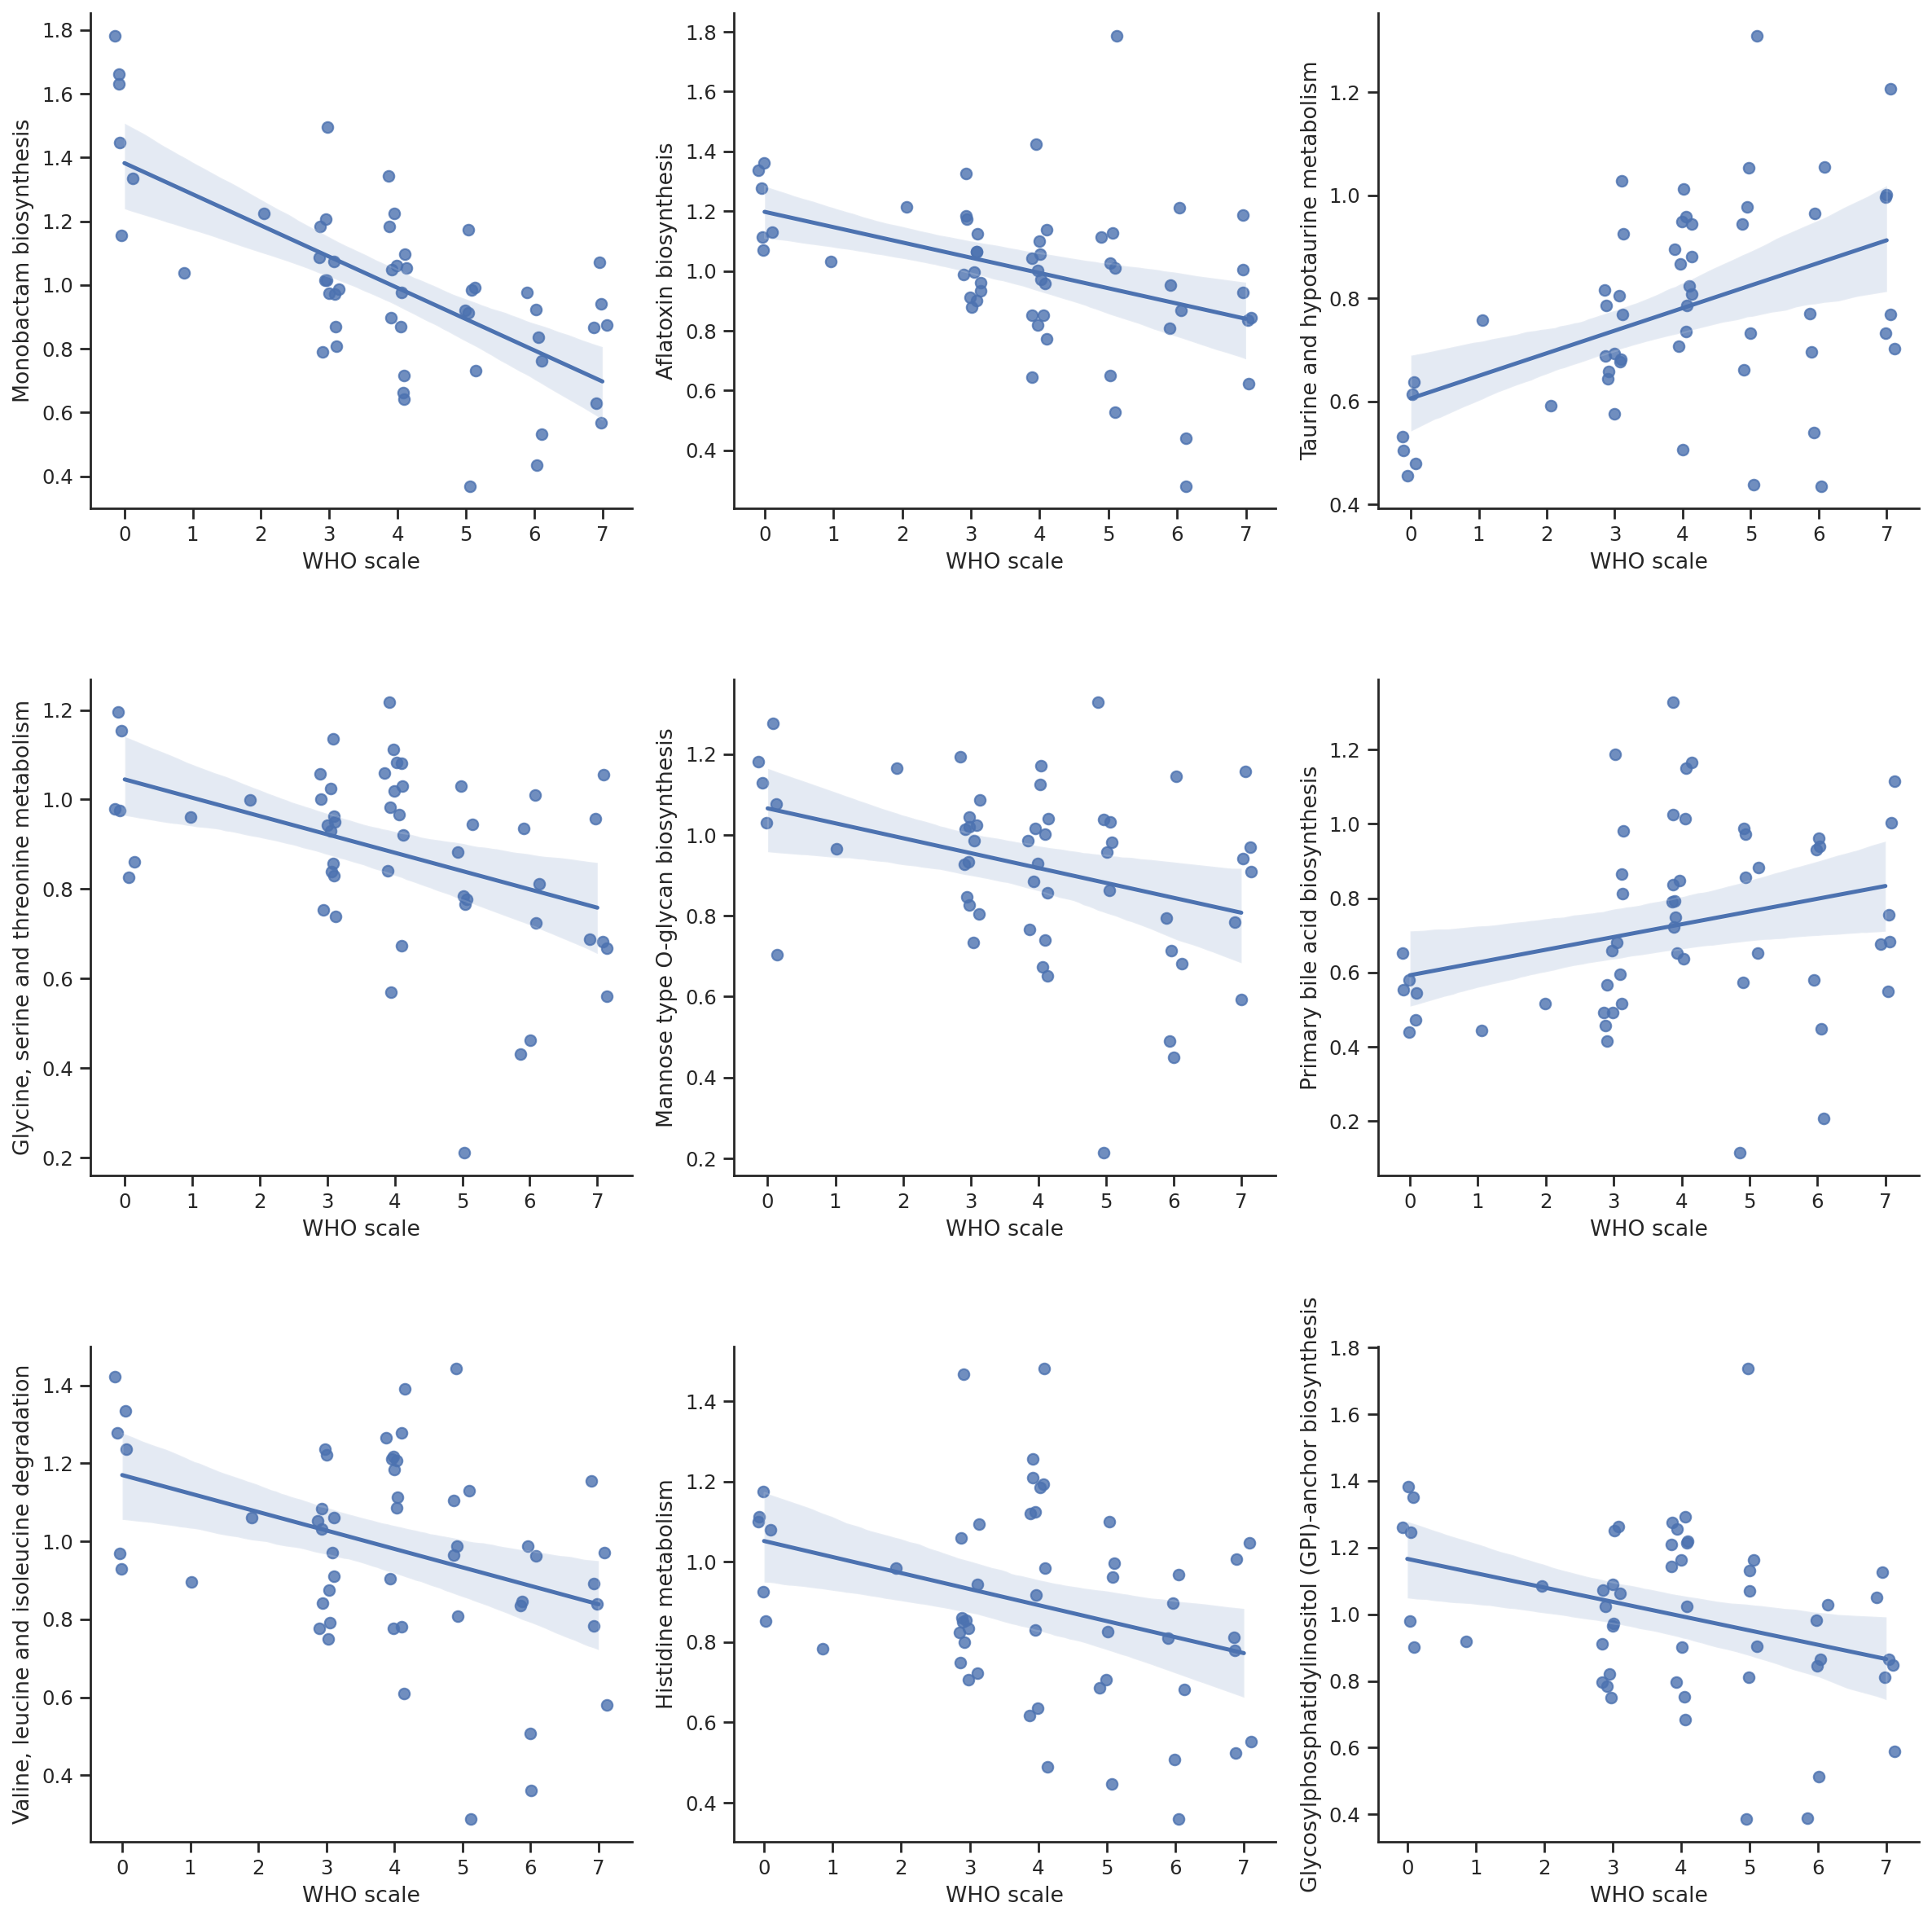

In [34]:
# Plot the top corresponding ones
sns.set_style('white')
sns.set_style('ticks')
f, axes = plt.subplots(3, 3, figsize=(15, 15), sharex=False, sharey=False)
sns.despine()

k = 0
x = adata_obs_by_patient.loc[df_p.columns, ['WHO_scale']]
for i in range(3):
    for j in range(3):
        f = sns.regplot(x=x, y=df_p.loc[sig_pathways.index[k]], x_jitter=0.15, ax=axes[i, j])
        f.set_ylabel(sig_pathways.index[k])
        f.set_xlabel('WHO scale')
        f.set_xticks(range(8))
        k += 1

plt.tight_layout()

0
Histidine metabolism                                                            Amino acid metabolism
Valine, leucine and isoleucine degradation                                      Amino acid metabolism
Glycine, serine and threonine metabolism                                        Amino acid metabolism
Neomycin, kanamycin and gentamicin biosynthesis           Biosynthesis of other secondary metabolites
Aflatoxin biosynthesis                                    Biosynthesis of other secondary metabolites
Monobactam biosynthesis                                   Biosynthesis of other secondary metabolites
Propanoate metabolism                                                         Carbohydrate metabolism
Glyoxylate and dicarboxylate metabolism                                       Carbohydrate metabolism
Glycosylphosphatidylinositol (GPI)-anchor biosynthesis             Glycan biosynthesis and metabolism
Mannose type O-glycan biosynthesis                                 Glycan biosyn

<ipython-input-19-83e3f223a9cd>:21: MatplotlibDeprecationWarning: 
The DivergingNorm class was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use TwoSlopeNorm instead.
  norm=DivergingNorm(1.0))


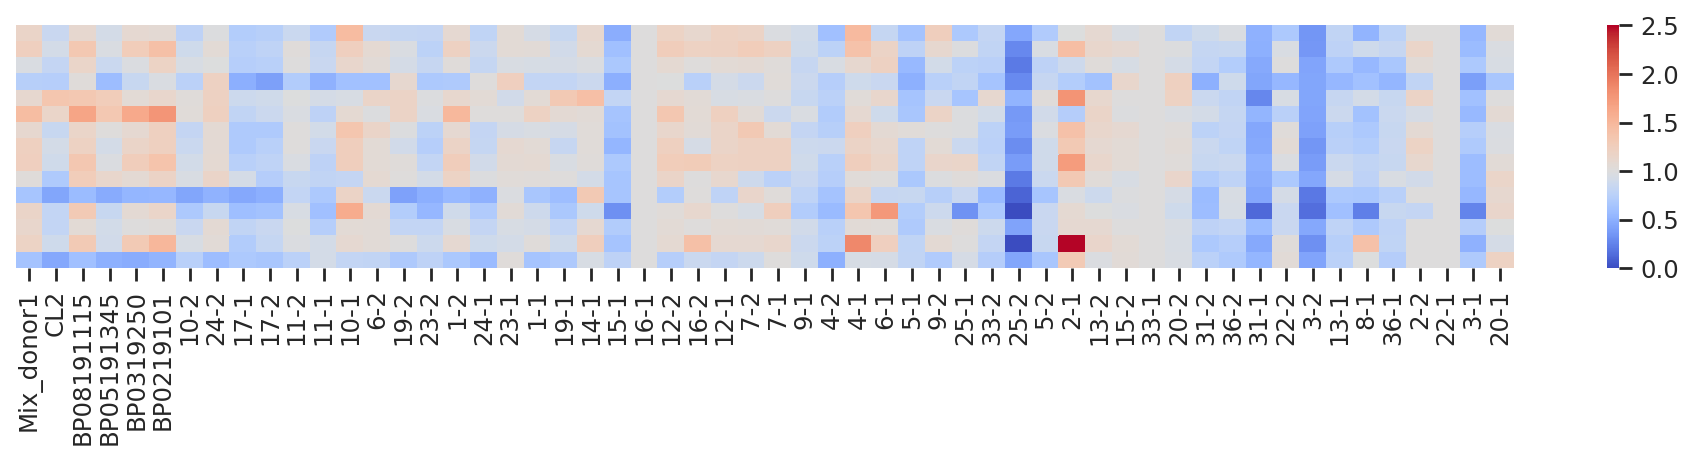

In [35]:
df_corresponding = plot_corresponding(p, sig_pathways, adata_mem_metab, figsize=(15, 2))

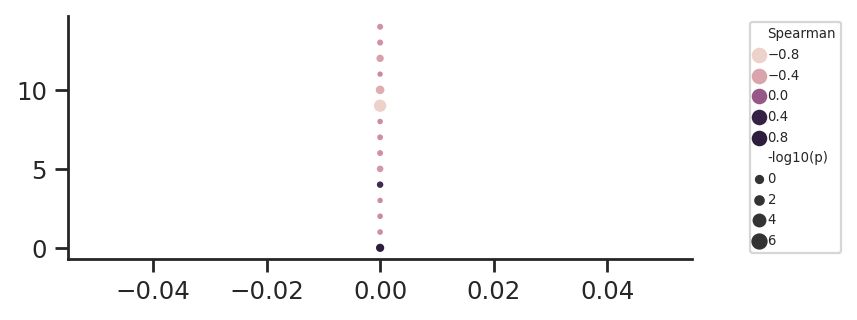

In [36]:
plot_spearman_dots(sig_pathways, df_corresponding, figsize=(5, 2))

### Addendum 1

In [ ]:
adata.obs['louvain_metab'] = adata_metab.obs['louvain']

adata_obs_by_patient = adata.obs.copy()
adata_obs_by_patient.index = adata_obs_by_patient['patient']
#adata_obs_by_patient.groupby(by='patient').first()
adata_obs_by_patient = adata_obs_by_patient.reset_index(drop=True)
adata_obs_by_patient = adata_obs_by_patient.groupby(by='patient').first() # All characteristics except clustering should be the same
adata_obs_by_patient['WHO_scale'] = adata_obs_by_patient['WHO_scale'].astype(int)
adata_obs_by_patient['Age_at_baseline'] = adata_obs_by_patient['Age_at_baseline'].str.replace('Not Recorded', 
                                                                                              '0').astype(int)
adata_obs_by_patient['Age_at_baseline'] = adata_obs_by_patient['Age_at_baseline'].astype(int)

eff_metab = ['0', '1']
adata_eff_metab = adata[adata.obs['louvain_metab'].isin(eff_metab)].copy()
adata_metab_eff_metab = adata_metab[adata.obs['louvain_metab'].isin(eff_metab)].copy()
# Not using subpopulations here for now
p = pathway_activity(adata_eff_metab, adata_metab_eff_metab, 'patient')#, print_labels=True)

df_p = pd.DataFrame(p)
df_p.to_csv(master_dir + 'output/pathway_activity/' + celltype + '-metab_cluster_0_1'
            '-metab-patient-pathway_activity.tabular', 
                       sep='\t', header=None, index=None)

df_p.index = metab_genes.index
patients = adata_eff_metab.obs['patient'].unique().astype(str)
patients.sort()
df_p.columns = patients

# Plot in order of increasing WHO score
patients_WHO = adata.obs.sort_values(by='WHO_scale', axis=0)['patient'].unique()
df_p = df_p.reindex(columns=patients_WHO)#, fill_value=1)

spr_corr = df_p.apply(lambda col: spearmanr(col, adata_obs_by_patient.loc[patients_WHO, ['WHO_scale']],
                                           nan_policy='omit')[0], axis=1)
spr_pvalues = df_p.apply(lambda col: spearmanr(col, adata_obs_by_patient.loc[patients_WHO, ['WHO_scale']],
                                           nan_policy='omit')[1], axis=1)

sig_pathways = pd.DataFrame([spr_corr, spr_pvalues]).transpose()
sig_pathways = sig_pathways[sig_pathways.loc[:, 1]<0.05]
sig_pathways.columns = ['Spearman', 'p-value']
sig_pathways['Spearman_abs'] = abs(sig_pathways['Spearman'])
sig_pathways = sig_pathways.sort_values(by='Spearman_abs', ascending=False)
sig_pathways['-log10(p)'] = -np.log10(sig_pathways['p-value'])
pd.DataFrame(sig_pathways).to_csv(master_dir + 'output/pathway_activity/pathway_activity_trends/' + 
                                 celltype + '-metab_cluster_0_1' + '.csv')
sig_pathways

### Addendum 2

In [12]:
adata.obs['louvain_metab'] = adata_metab.obs['louvain']

adata_obs_by_patient = adata.obs.copy()
adata_obs_by_patient.index = adata_obs_by_patient['patient']
#adata_obs_by_patient.groupby(by='patient').first()
adata_obs_by_patient = adata_obs_by_patient.reset_index(drop=True)
adata_obs_by_patient = adata_obs_by_patient.groupby(by='patient').first() # All characteristics except clustering should be the same
adata_obs_by_patient['WHO_scale'] = adata_obs_by_patient['WHO_scale'].astype(int)
adata_obs_by_patient['Age_at_baseline'] = adata_obs_by_patient['Age_at_baseline'].str.replace('Not Recorded', 
                                                                                              '0').astype(int)
adata_obs_by_patient['Age_at_baseline'] = adata_obs_by_patient['Age_at_baseline'].astype(int)

eff_metab = ['0', '1']
adata_eff_metab = adata[adata.obs['louvain_metab'].isin(eff_metab)].copy()
adata_metab_eff_metab = adata_metab[adata.obs['louvain_metab'].isin(eff_metab)].copy()
# Not using subpopulations here for now
p = pathway_activity(adata_eff_metab, adata_metab_eff_metab, 'patient')#, print_labels=True)

df_p = pd.DataFrame(p)
df_p.to_csv(master_dir + 'output/pathway_activity/' + celltype + '-metab_cluster_0_1'
            '-metab-patient-pathway_activity.tabular', 
                       sep='\t', header=None, index=None)

df_p.index = metab_genes.index
patients = adata_eff_metab.obs['patient'].unique().astype(str)
patients.sort()
df_p.columns = patients

# Plot in order of increasing WHO score
patients_WHO = adata.obs.sort_values(by='WHO_scale', axis=0)['patient'].unique()
df_p = df_p.reindex(columns=patients_WHO)#, fill_value=1)

spr_corr = df_p.apply(lambda col: spearmanr(col, adata_obs_by_patient.loc[patients_WHO, ['WHO_scale']],
                                           nan_policy='omit')[0], axis=1)
spr_pvalues = df_p.apply(lambda col: spearmanr(col, adata_obs_by_patient.loc[patients_WHO, ['WHO_scale']],
                                           nan_policy='omit')[1], axis=1)

sig_pathways = pd.DataFrame([spr_corr, spr_pvalues]).transpose()
sig_pathways = sig_pathways[sig_pathways.loc[:, 1]<0.05]
sig_pathways.columns = ['Spearman', 'p-value']
sig_pathways['Spearman_abs'] = abs(sig_pathways['Spearman'])
sig_pathways = sig_pathways.sort_values(by='Spearman_abs', ascending=False)
sig_pathways['-log10(p)'] = -np.log10(sig_pathways['p-value'])
pd.DataFrame(sig_pathways).to_csv(master_dir + 'output/pathway_activity/pathway_activity_trends/' + 
                                 celltype + '-metab_cluster_0_1' + '.csv')
sig_pathways

Spearman   p-value  \
0                                                                      
Caffeine metabolism                               0.413801  0.001524   
Steroid hormone biosynthesis                      0.408408  0.001779   
Histidine metabolism                             -0.391811  0.002824   
Glycosaminoglycan biosynthesis - keratan sulfate  0.357400  0.006848   
Thiamine metabolism                               0.355591  0.007156   
Mucin type O-glycan biosynthesis                  0.334993  0.011613   
One carbon pool by folate                         0.307367  0.021204   
Terpenoid backbone biosynthesis                   0.284821  0.033369   
Prodigiosin biosynthesis                          0.278941  0.037357   
Synthesis and degradation of ketone bodies        0.274209  0.040846   
Folate biosynthesis                               0.271112  0.043271   
N-Glycan biosynthesis                             0.270346  0.043889   

                                                  Spearman_abs  -log10(p)  
0                                                                          
Caffeine metabolism                                   0.413801   2.817150  
Steroid hormone biosynthesis                          0.408408   2.749759  
Histidine metabolism                                  0.391811   2.549191  
Glycosaminoglycan biosynthesis - keratan sulfate      0.357400   2.164459  
Thiamine metabolism                                   0.355591   2.145338  
Mucin type O-glycan biosynthesis                      0.334993   1.935067  
One carbon pool by folate                             0.307367   1.673588  
Terpenoid backbone biosynthesis                       0.284821   1.476656  
Prodigiosin biosynthesis                              0.278941   1.427625  
Synthesis and degradation of ketone bodies            0.274209   1.388850  
Folate biosynthesis                                   0.271112   1.363801  
N-Glycan biosynthesis                                 0.270346   1.357648